In [1]:
from pathlib import Path
import json
import pandas as pd
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
from collections import defaultdict
pd.set_option('display.max_rows', 100)

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True


In [2]:
PATH_OCUS_EXPLAIN = Path("/home/emilio/research/OCUSExplain/")
PATH_POST_PAPER= PATH_OCUS_EXPLAIN / "conferences/2021_IJCAI/results/post_paper/output/" 
PATH_POST_PAPER_RESULTS = PATH_POST_PAPER / "2021050517/"
PATH_COSTS_RESUTS = PATH_POST_PAPER / "costs/"
PATH_FIGURES_POST_PAPER = Path("/home/emilio/research/holygrail/latex/conferences/ijcai21/figures_post_paper/")

In [3]:
def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
            
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict



In [4]:
def list_json_dir(folder):
    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.json']
    return files

def replace_none(json_dict):
    new_json_dict = dict(json_dict)
    for k, v in json_dict.items():
        if isinstance(v, dict):
            new_json_dict[k] = replace_none(v)
        elif v is None:
            new_json_dict[k] = "ignore"
    
    return new_json_dict

def read_json(f_path):
    with f_path.open('r') as fp:
        json_dict = json.load(fp)
        json_dict["filepath"] = f_path
        json_dict["filename"] = Path(f_path).name

    return replace_none(json_dict)

In [5]:

def pbs_to_params_dir(folder):

    p = Path(folder)

    # list files in dir
    files = [f for f in p.iterdir() if f.suffix == '.pbs']
    pbs_param_dict = {}
    for f in files:
        path_file = p / f
        with path_file.open('r') as fp:
            for line in fp:
                if not line.startswith("python3"):
                    continue
                s = line.replace("python3 reuseSS.py --output ", "")
                result_json_fpath = s.split(" --puzzle ")[0]
                result_json_fpath = result_json_fpath.replace("/data/brussel/101/vsc10143/", "/home/emilio/research/")
                json_fname =    Path(result_json_fpath).name
                pbs_param_dict[json_fname] = str(p / str(f).replace(".pbs", ".json"))

    return pbs_param_dict


In [6]:
def jsonFilesToExtendedDf(jsonFiles, output_folder, param_matching=False):
    """ dictionary hierarchy
        'time' = {
            # number of hitting sets computed
            "totalTime": 0,
            # time spent in hitting set ?
            "hs": [],
            # time spent in optimising hitting set
            "opt": [],
            # time spent in sat
            "sat": [],
            # time spent in grow
            "grow": [],
            # time to find an explanation 
            "explain": [],
            # time propagating information
            "prop": [],
            # time spent in computing a MUS
            "mus":[],
            # time spent in computing a MUS
            "greedyBestStep":[],
            "preprocess":0,
            "preseeding":[],
            "postprocessing":[],
            "timeout": 0,
            "timedout": False
        },
        'numbers' = {
            # number of hitting sets computed
            "hs": [],
            # number of opt calls
            "opt": [],
            # number of sat calls
            "sat": [],
            # number of grow calls
            "grow": [],
            # number of literal explain calls skipped
            "skipped": [],
            # number of calls to propagation
            "prop": 0
        },
        'explanation': [
            'constraints': [], 'derived': [], 'cost': int}
        ]
    """
    if param_matching:
        input_folder = output_folder.replace("output/", "input/")
        pbs_params_dict = pbs_to_params_dir(input_folder)

    pd_dict = {}
    # prepopulate dictionary with good structure
    # print(jsonFiles)

    for f_json in jsonFiles:
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k] = []
                continue

            for ki, vi in v.items():
                k_name = k + "_" + ki
                if k_name not in pd_dict:
                    pd_dict[k_name] = []

    for id, f_json in enumerate(jsonFiles):
        filled_keys = []
        for k,v in f_json.items():
            if not isinstance(v, dict):
                pd_dict[k].append(v)
                filled_keys.append(k)
                continue

            if k == 'time' and not 'timedout' in v:
                pd_dict['time_timedout'].append(True if v["totalTime"] == 7200 else False)
                filled_keys.append('time_timedout')

            for ki, vi in v.items():
                k_name = k + "_" + ki
                pd_dict[k_name].append(vi)
                filled_keys.append(k_name)

        for k in pd_dict:
            if k not in filled_keys:
                pd_dict[k].append("ignore")
    
        if param_matching:
            output_filename = f_json["filename"]
            params_path = pbs_params_dict[output_filename]
            params_f_json = read_json(Path(params_path))

            for k,v in params_f_json.items():
                key_params = "params_" + k
                if key_params not in pd_dict:
                    pd_dict[key_params] = []

                pd_dict[key_params].append(v)

    df = pd.DataFrame(pd_dict)

    return df


def folders_to_df(folders, param_matching=False, n=None):
    df = pd.DataFrame()

    for folder in folders:
        if n:
            files = [read_json(f) for f in list_json_dir(folder)[:n] if f.stat().st_size > 5]
        else:
            files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        files = [read_json(f) for f in list_json_dir(folder) if f.stat().st_size > 5]
        df_folder = jsonFilesToExtendedDf(files, folder, param_matching)
        df = df.append(df_folder)
    return df


In [7]:

def folder_to_pandas_df_pickle(output_folders, pickle_name, param_matching=False, n=None):
    path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
    path_output_dirs = [path_base_output_dir + o for o in output_folders]
    df = folders_to_df(path_output_dirs, param_matching=param_matching, n=n)
    # df.to_pickle(pickle_name)
    return df

def best_puzzle_explanation_computer_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance", "params_explanation_computer"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer

def best_puzzle_config(df_not_timedout):
    df_min_query = df_not_timedout.groupby(["params_instance"])["time_totalTime"].idxmin()
    df_puzzle_computer = df_not_timedout.loc[df_min_query]

    return df_puzzle_computer


In [8]:
def pickle_to_research_questions(pickle_path):
    df = pd.read_pickle(pickle_path)
    all_column_names = ['time_totalTime', 'time_hs', 'time_opt', 'time_sat', 'time_grow', 'time_explain', 'time_prop', 'time_mus', 'time_greedyBestStep', 'time_preprocess', 'time_preseeding', 'time_postprocessing', 'time_timedout', 'numbers_hs', 'numbers_opt', 'numbers_sat', 'numbers_grow', 'numbers_skipped', 'numbers_prop', 'explanation', 'filepath', 'filename', 'params_output', 'params_instance', 'params_timeout', 'params_explanation_computer', 'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals', 'params_filepath', 'params_filename']
    col_inst_time_config = ["params_instance", 'params_explanation_computer', "time_totalTime",'params_grow', 'params_maxsatpolarity', 'params_interpretation', 'params_weighing', 'params_reuse_SSes', 'params_sort_literals']

    # best configuration for all epxlnaation computers
    df_not_timedout = df[(df["time_totalTime"] < 7200) & (df["time_totalTime"] > 0)]

    df_not_timedout_not_MUS = df_not_timedout[df_not_timedout["params_explanation_computer"] != "MUS"]
    df_not_timedout_OCUS = df_not_timedout[df_not_timedout["params_explanation_computer"] == "OCUS"]

    # Best configuration for all explanation computer and all puzzles
    df_best_puzzle_computer_config = best_puzzle_explanation_computer_config(df_not_timedout)[col_inst_time_config]

    # Best configuraiton for all puzzles
    df_best_puzzle_config = best_puzzle_config(df_not_timedout)[col_inst_time_config]
    df_best_puzzle_config_not_MUS = best_puzzle_config(df_not_timedout_not_MUS)[col_inst_time_config]
    df_best_puzzle_config_OCUS = best_puzzle_config(df_not_timedout_OCUS)[col_inst_time_config]


## Applying transformations before plotting 
### 1. Enhancing the data

In [9]:
# ensure totTime is timeout
def cumul_expl_time(row):
    expl_time = row["texpl"]
    cumul_expl = []
    cumul_time = 0
    
    for t in expl_time:
        cumul_time += t
        cumul_expl.append(cumul_time)
    if row["timeout"]:
        cumul_expl.append(row["param_timeout"])
    return cumul_expl

def cumul_lits_derived(row):
    expls = row["explanation"]
    cumul_lits = 0
    cumul_lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        cumul_lits += n_lits_derived
        cumul_lit_seq.append(cumul_lits)
    return cumul_lit_seq

def lits_derived(row):
    expls = row["explanation"]
    lit_seq = []
    for explanation in expls:
        n_lits_derived = len(explanation["derived"])
        lit_seq.append(n_lits_derived)
    return lit_seq

def joint_lits_time(row):
    expls = row["expl_seq"]
    texpl = row["texpl"]
    lit_seq = []
    cumul_time = 0
    for explanation, time_expl  in zip(expls, texpl):
        cumul_time += time_expl
        n_lits_derived = len(explanation["derived"])
        lit_seq.append((cumul_time, n_lits_derived))
    
    if row["timeout"]:
        lit_seq.append((row["param_timeout"], 0))
    return lit_seq


def rename_config(row):
    if row["param_explanation_computer"] == "OCUS":
        if row["param_disableConstrained"]:
            return "OCUS"
        return "OCUS+I"
    elif row["param_explanation_computer"] == "OUS":
        if row["param_reuse_SSes"]:
            return "OUS+I"
        return "OUS"
    elif row["param_explanation_computer"] == "MUS":
        return "MUS"

def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"Sat", 
        'SUBSET_MAXIMAL':"Greedy-Sat-Full", 
        'SUBSET_MAXIMAL_I0': "Greedy-Sat-Initial", 
        'SUBSET_MAXIMAL_ACTUAL': "Greedy-Sat-Actual", 
        'ignore': "ignore",
        None: "ignore", 
    }
    if row["param_grow"] in ["SUBSET_MAXIMAL", "SUBSET_MAXIMAL_I0", "SUBSET_MAXIMAL_ACTUAL", 'ignore', None, "SAT"]:
        return grow_renaming[row["param_grow"]]

    weights_renaming = {
        'ACTUAL_UNIF': "Actual-Unif",
        'ACTUAL_INV': "Actual-Inv",
        'FULL_POS': "Full-Pos", 
        'FULL_UNIF': "Full-Unif",
        'INITIAL_INV': "Initial-Inv",
        'INITIAL_POS': "Initial-Pos", 
        'ACTUAL_POS': "Actual-Pos",
        'INITIAL_UNIF': "Initial-Unif",
        'FULL_INV':"Full-Inv", 
        'ignore':'ignore', 
        None: "ignore"
    }
    
    return grow_renaming[row["param_grow"]] + "-" + weights_renaming[row["param_weighing"]]


def average_lits_derived_time(row):
    penalty = 7200
    max_lits_puzzle = {
        'origin-problem':150,
         'p12':150,
         'p13':150,
         'p16':150,
         'p18':150,
         'p19':250,
         'p20':150,
         'p25':150,
         'p93':150,
         "frietkot":0,
         "simple":0,
         'pastaPuzzle':96
    }

    avg_lits_derived_times = [(0, 0)]
    j = 1
    tot_time = 0
    print(j)
    for lits_derived, texpl in zip(row["lits_derived"], row["time_explain"]):
        print("lits_derived=", lits_derived)
        tot_time += texpl
        for i in range(lits_derived):
            print("adding=", (j, tot_time))
            avg_lits_derived_times.append((j,tot_time))
            j+= 1

    if row["time_timedout"]:
        tot_time = penalty
        print("timedout !")
        for k in range(j, 251):
            print((k, penalty))
            avg_lits_derived_times.append((k, penalty))
        j = max_lits_puzzle[row["params_instance"]]

    elif j< 250:
        for i in range(j, 251):
            print((i, tot_time))
            avg_lits_derived_times.append((i, tot_time))
            
    return avg_lits_derived_times

def mus_size(expl_seq):
    sizes = []
    for expl in expl_seq:
        size = len(expl["constraints"]) + 1
        sizes.append(size)
    
    return sizes


def enhance_dataframe(df):
    df["lits_derived"] = df.apply(lambda row: lits_derived(row), axis=1)
    df["average_lits_derived_time"] = df.apply(lambda row: average_lits_derived_time(row), axis=1)
    df['cumul_explain_time'] = df.apply(
        lambda row: [sum(row["time_explain"][:x]) for x in range(1, len(row["time_explain"])+1)]
    , axis=1)
    
    return df

### 2. Filtering on best configuration

In [10]:
# finding the best configuration for every explanation computer
def best_configs_explanation_computer_puzzles(df):
    #print(df.columns.to_list())
    #print(set(df["params_explanation_computer"]))
    expl_comp_gb_cols = ['params_explanation_computer',
                         'params_grow', 
                         'params_maxsatpolarity',
                         'params_interpretation',
                         'params_weighing',
                         'params_reuse_SSes',
                         'params_sort_literals']

    grouped_expl_computer_config = df\
                                .groupby(by=expl_comp_gb_cols)["time_totalTime"]\
                                .sum().reset_index()\
                                .rename(columns={'time_totalTime':'sum_totalTime'})
    
    #print(grouped_expl_computer_config)
    df_grouped_expl_computer = grouped_expl_computer_config \
                               .loc[grouped_expl_computer_config \
                               .groupby(by=["params_explanation_computer", "params_reuse_SSes"])["sum_totalTime"].idxmin()]
    
    df_grouped_expl_computer_mus = df[df["params_explanation_computer"] == "MUS"] \
                                   .groupby(by=['params_explanation_computer'])["time_totalTime"]\
                                   .sum().reset_index().rename(columns={'time_totalTime':'sum_totalTime'})

    # add the columns and default to NONE
    for col in ['params_grow', 'params_maxsatpolarity','params_interpretation','params_weighing','params_reuse_SSes','params_sort_literals']:
        df_grouped_expl_computer_mus[col] =  df_grouped_expl_computer_mus.apply(lambda row: None, axis=1)

    df_grouped_expl_computer = df_grouped_expl_computer.append(df_grouped_expl_computer_mus, ignore_index=True)

    df_expl_comp_config = pd.merge(df, df_grouped_expl_computer, how='inner')
    return df_expl_comp_config

In [11]:
def cumulative_lits_derived_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"
    x = [0]
    y = [0]
    times_lits_derived = []
    
    # one whole list
    for id, row in df.iterrows():
        times_lits_derived += row["joint_lits_time"]

    # sorting on cumulative time
    times_lits_derived.sort(key=lambda x: x[0])
    n_cumul_lits = 0

    # computing the 
    for (t, nlit) in times_lits_derived:
        n_cumul_lits += nlit
        y.append(t)
        x.append(n_cumul_lits)
    
    return x, y

def cumulative_expl_time(df):
    """Given a specific configuration plot the cumulative explanation time
    with respect to the number of ltierals derived."""
    assert len(set(df["param_explanation_computer"])) == 1, "making sure there is only 1 config"
    assert len(set(df["param_instance"])) == 10, "Making sure we have all puzzles"
    assert len(df) == 10, "Only 10 puzzle configs"

    expls_derived = [0]
    
    for id, row in df.iterrows():
        expls_derived += row["cumul_expl"]
    
    expls_derived.sort()
    x = list(range(len(expls_derived)))
    
    return x, expls_derived

def cactus_cumulative_lits_derived_time(df, column_name="param_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    
    x = []
    y = []
    max_y = []
    label = []

    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values

    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_lits_derived_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)

        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))

    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    for id, _ in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative number of literals derived",fontsize=26)
    plt.ylabel("Time [s]",fontsize=24)
    # plt.title("Cumulative Literals derived time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()

def cactus_cumulative_expl_time(df, column_name="param_explanation_config", figure_path=None, xlog=True, figsize=(16, 8), mapping=None, ordering=None,next_to_graph=False):
    plt.figure(figsize=figsize)
    
    all_column_values = set(df[column_name])
    x = []
    y = []
    max_y = []
    label = []

    
    if ordering:
        ordering_column_Values = ordering
    else:
        ordering_column_Values = all_column_values
        
    for id, column_value in enumerate(ordering_column_Values):
        xi, yi = cumulative_expl_time(df[df[column_name] == column_value])
        x.append(xi)
        y.append(yi)
        if mapping:
            label.append(mapping[column_value])
        else:
            label.append(column_value)
        
        if int(max(yi)) < 7200:
            max_y.append((id, max(yi)))
        else:
            max_y.append((id, max(yi) + 10000 - max(xi)))
    if not ordering:
        max_y.sort(key=lambda xs: xs[1])
    
    
    for id, my in max_y:
        plt.plot(x[id], y[id], label=label[id], linewidth=4)
    
    if next_to_graph:
        plt.legend(fontsize=20, loc='center left', bbox_to_anchor=(1.0, 0.5))
    else:
        plt.legend(loc="upper left", fontsize=20)

    if xlog:
        plt.xscale('log')
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.xlabel("Cumulative number of Explanation steps",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    # plt.title("Cumulative explanation-time",fontsize=28)
    plt.grid(True)
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()
    

def config_cumulative_exec_time(df):
    df_cumul = df.groupby(by=["params_explanation_computer"])["cumul_explain_time"].apply(lambda x : sorted(x.sum())).reset_index().rename(columns={'cumul_explain_time':'cumul_explain_time'})
    df_cumul["cumul_explain_step"] = df_cumul.apply(
                lambda row: [x for x in range(1, len(row["cumul_explain_time"])+1)]
        , axis=1)
    #df_cumul["cumul_literals_derived"] = df_cumul.apply(
    #            lambda row: cumulative_lits_derived_time(row)
    #    , axis=1)
    return df_cumul

In [12]:
def cactus_plot(df):
    display(df)
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of explanations",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative explanation-time",fontsize=28)
    plt.grid(True)
    #plt.savefig("/home/emilio/research/OCUSExplain/code/pyexplain/benchmark/cactus" +datetime.now().strftime("%Y%m%d%H%M%S%f")+".png")
    plt.show()
    # print("printing cactus plot")

In [13]:


def cactus_plot_derived_lits(df):
    plt.figure(figsize=(20, 12))
    for i, row in df.iterrows():
        x, y, label = row["cumul_explain_step"], row["cumul_explain_time"], row["params_explanation_computer"]
        plt.plot(x, y, label=label.replace('_','-'), linewidth=3)
    plt.legend(loc="upper left", fontsize=20)
    #plt.xscale('log')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel("Cumulative $\#$ of literals",fontsize=28)
    plt.ylabel("Time [s]",fontsize=28)
    plt.title("Log-scaled cumulative derived literals time",fontsize=28)
    plt.grid(True)
    #plt.savefig("/home/emilio/research/OCUSExplain/code/pyexplain/benchmark/cactus_derived_lits" +datetime.now().strftime("%Y%m%d%H%M%S%f")+".png")
    plt.show()

# Importing Data from folder

In [14]:
output_folders = ["2021043010"]
pickle_name ="pickles/2021042719.pkl"

path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
path_output_dirs = [path_base_output_dir + o for o in output_folders]
df = folder_to_pandas_df_pickle(output_folders, pickle_name, False)

print()

In [15]:
df = enhance_dataframe(df)

1
lits_derived= 1
adding= (1, 4.926731109619141)
lits_derived= 4
adding= (2, 9.817392110824585)
adding= (3, 9.817392110824585)
adding= (4, 9.817392110824585)
adding= (5, 9.817392110824585)
lits_derived= 4
adding= (6, 14.884117364883423)
adding= (7, 14.884117364883423)
adding= (8, 14.884117364883423)
adding= (9, 14.884117364883423)
lits_derived= 2
adding= (10, 52.237332820892334)
adding= (11, 52.237332820892334)
timedout !
(12, 7200)
(13, 7200)
(14, 7200)
(15, 7200)
(16, 7200)
(17, 7200)
(18, 7200)
(19, 7200)
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(6

lits_derived= 1
adding= (55, 693.1337330341339)
lits_derived= 1
adding= (56, 708.5525531768799)
lits_derived= 1
adding= (57, 724.2553849220276)
lits_derived= 1
adding= (58, 740.2823624610901)
lits_derived= 1
adding= (59, 754.6526021957397)
lits_derived= 1
adding= (60, 769.7154603004456)
lits_derived= 3
adding= (61, 818.2625684738159)
adding= (62, 818.2625684738159)
adding= (63, 818.2625684738159)
lits_derived= 3
adding= (64, 872.3236825466156)
adding= (65, 872.3236825466156)
adding= (66, 872.3236825466156)
lits_derived= 1
adding= (67, 902.5656957626343)
lits_derived= 1
adding= (68, 923.5994262695312)
lits_derived= 1
adding= (69, 937.3731129169464)
lits_derived= 1
adding= (70, 950.9691307544708)
lits_derived= 1
adding= (71, 964.7628493309021)
lits_derived= 1
adding= (72, 982.3322460651398)
lits_derived= 2
adding= (73, 1010.91747879982)
adding= (74, 1010.91747879982)
lits_derived= 1
adding= (75, 1037.0304656028748)
lits_derived= 1
adding= (76, 1056.9347922801971)
lits_derived= 1
adding= 

adding= (65, 33.503806591033936)
adding= (66, 33.503806591033936)
lits_derived= 2
adding= (67, 33.91878318786621)
adding= (68, 33.91878318786621)
lits_derived= 1
adding= (69, 34.37410259246826)
lits_derived= 1
adding= (70, 34.78416728973389)
lits_derived= 1
adding= (71, 39.28359079360962)
lits_derived= 1
adding= (72, 39.765891551971436)
lits_derived= 1
adding= (73, 40.14292502403259)
lits_derived= 1
adding= (74, 40.48407864570618)
lits_derived= 1
adding= (75, 40.85139775276184)
lits_derived= 1
adding= (76, 41.19012451171875)
lits_derived= 1
adding= (77, 41.539583921432495)
lits_derived= 1
adding= (78, 41.92071509361267)
lits_derived= 1
adding= (79, 44.523380517959595)
lits_derived= 1
adding= (80, 45.260009765625)
lits_derived= 1
adding= (81, 45.914069414138794)
lits_derived= 1
adding= (82, 46.62333369255066)
lits_derived= 3
adding= (83, 52.285400390625)
adding= (84, 52.285400390625)
adding= (85, 52.285400390625)
lits_derived= 3
adding= (86, 52.64323854446411)
adding= (87, 52.6432385444

adding= (78, 1447.0636055469513)
lits_derived= 1
adding= (79, 1474.6438393592834)
lits_derived= 1
adding= (80, 1494.1843738555908)
lits_derived= 1
adding= (81, 1507.6717581748962)
lits_derived= 1
adding= (82, 1516.6665456295013)
lits_derived= 1
adding= (83, 1528.9847753047943)
lits_derived= 1
adding= (84, 1658.3171627521515)
lits_derived= 1
adding= (85, 1667.3513309955597)
lits_derived= 1
adding= (86, 1707.7232451438904)
lits_derived= 1
adding= (87, 1724.472252368927)
lits_derived= 1
adding= (88, 1733.7387657165527)
lits_derived= 1
adding= (89, 1761.5742144584656)
lits_derived= 1
adding= (90, 1833.4036598205566)
lits_derived= 1
adding= (91, 1899.1190533638)
lits_derived= 1
adding= (92, 1965.7753703594208)
lits_derived= 1
adding= (93, 2036.6472380161285)
lits_derived= 1
adding= (94, 2110.2634692192078)
lits_derived= 1
adding= (95, 2190.6931812763214)
lits_derived= 1
adding= (96, 2271.703165769577)
lits_derived= 1
adding= (97, 2335.1462841033936)
lits_derived= 1
adding= (98, 2396.1803882

lits_derived= 1
adding= (45, 325.1358485221863)
lits_derived= 1
adding= (46, 331.7782127857208)
lits_derived= 1
adding= (47, 338.98568415641785)
lits_derived= 1
adding= (48, 344.83712220191956)
lits_derived= 1
adding= (49, 350.0419325828552)
lits_derived= 4
adding= (50, 360.79891705513)
adding= (51, 360.79891705513)
adding= (52, 360.79891705513)
adding= (53, 360.79891705513)
lits_derived= 1
adding= (54, 370.2151446342468)
lits_derived= 1
adding= (55, 381.96180748939514)
lits_derived= 3
adding= (56, 391.17764544487)
adding= (57, 391.17764544487)
adding= (58, 391.17764544487)
lits_derived= 1
adding= (59, 401.1834318637848)
lits_derived= 1
adding= (60, 411.1607542037964)
lits_derived= 1
adding= (61, 420.7825231552124)
lits_derived= 1
adding= (62, 430.6138594150543)
lits_derived= 1
adding= (63, 440.5067539215088)
lits_derived= 1
adding= (64, 450.04288601875305)
lits_derived= 1
adding= (65, 459.53016448020935)
lits_derived= 1
adding= (66, 468.3075635433197)
lits_derived= 1
adding= (67, 477.

(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138,

(161, 388.52694177627563)
(162, 388.52694177627563)
(163, 388.52694177627563)
(164, 388.52694177627563)
(165, 388.52694177627563)
(166, 388.52694177627563)
(167, 388.52694177627563)
(168, 388.52694177627563)
(169, 388.52694177627563)
(170, 388.52694177627563)
(171, 388.52694177627563)
(172, 388.52694177627563)
(173, 388.52694177627563)
(174, 388.52694177627563)
(175, 388.52694177627563)
(176, 388.52694177627563)
(177, 388.52694177627563)
(178, 388.52694177627563)
(179, 388.52694177627563)
(180, 388.52694177627563)
(181, 388.52694177627563)
(182, 388.52694177627563)
(183, 388.52694177627563)
(184, 388.52694177627563)
(185, 388.52694177627563)
(186, 388.52694177627563)
(187, 388.52694177627563)
(188, 388.52694177627563)
(189, 388.52694177627563)
(190, 388.52694177627563)
(191, 388.52694177627563)
(192, 388.52694177627563)
(193, 388.52694177627563)
(194, 388.52694177627563)
(195, 388.52694177627563)
(196, 388.52694177627563)
(197, 388.52694177627563)
(198, 388.52694177627563)
(199, 388.52

lits_derived= 1
adding= (21, 713.563413143158)
lits_derived= 1
adding= (22, 779.1094908714294)
lits_derived= 4
adding= (23, 858.8639228343964)
adding= (24, 858.8639228343964)
adding= (25, 858.8639228343964)
adding= (26, 858.8639228343964)
lits_derived= 4
adding= (27, 920.8729057312012)
adding= (28, 920.8729057312012)
adding= (29, 920.8729057312012)
adding= (30, 920.8729057312012)
lits_derived= 1
adding= (31, 974.8055310249329)
lits_derived= 1
adding= (32, 1034.4080941677094)
lits_derived= 1
adding= (33, 1086.4683566093445)
lits_derived= 1
adding= (34, 1136.6146886348724)
lits_derived= 1
adding= (35, 1178.9940705299377)
lits_derived= 1
adding= (36, 1231.6001431941986)
lits_derived= 1
adding= (37, 1286.9961438179016)
lits_derived= 1
adding= (38, 1341.0672307014465)
lits_derived= 1
adding= (39, 1387.6289038658142)
lits_derived= 1
adding= (40, 1436.6310985088348)
lits_derived= 2
adding= (41, 1720.1255705356598)
adding= (42, 1720.1255705356598)
lits_derived= 1
adding= (43, 2147.755181074142

adding= (1, 3.6162664890289307)
lits_derived= 1
adding= (2, 5.8119659423828125)
lits_derived= 1
adding= (3, 8.618086099624634)
lits_derived= 4
adding= (4, 13.070827960968018)
adding= (5, 13.070827960968018)
adding= (6, 13.070827960968018)
adding= (7, 13.070827960968018)
lits_derived= 4
adding= (8, 15.283666849136353)
adding= (9, 15.283666849136353)
adding= (10, 15.283666849136353)
adding= (11, 15.283666849136353)
lits_derived= 1
adding= (12, 18.179691553115845)
lits_derived= 4
adding= (13, 20.96381950378418)
adding= (14, 20.96381950378418)
adding= (15, 20.96381950378418)
adding= (16, 20.96381950378418)
lits_derived= 4
adding= (17, 22.783235788345337)
adding= (18, 22.783235788345337)
adding= (19, 22.783235788345337)
adding= (20, 22.783235788345337)
lits_derived= 1
adding= (21, 24.96735167503357)
lits_derived= 1
adding= (22, 28.694075107574463)
lits_derived= 4
adding= (23, 31.797574758529663)
adding= (24, 31.797574758529663)
adding= (25, 31.797574758529663)
adding= (26, 31.79757475852966

(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)

(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208

(157, 1611.9886238574982)
(158, 1611.9886238574982)
(159, 1611.9886238574982)
(160, 1611.9886238574982)
(161, 1611.9886238574982)
(162, 1611.9886238574982)
(163, 1611.9886238574982)
(164, 1611.9886238574982)
(165, 1611.9886238574982)
(166, 1611.9886238574982)
(167, 1611.9886238574982)
(168, 1611.9886238574982)
(169, 1611.9886238574982)
(170, 1611.9886238574982)
(171, 1611.9886238574982)
(172, 1611.9886238574982)
(173, 1611.9886238574982)
(174, 1611.9886238574982)
(175, 1611.9886238574982)
(176, 1611.9886238574982)
(177, 1611.9886238574982)
(178, 1611.9886238574982)
(179, 1611.9886238574982)
(180, 1611.9886238574982)
(181, 1611.9886238574982)
(182, 1611.9886238574982)
(183, 1611.9886238574982)
(184, 1611.9886238574982)
(185, 1611.9886238574982)
(186, 1611.9886238574982)
(187, 1611.9886238574982)
(188, 1611.9886238574982)
(189, 1611.9886238574982)
(190, 1611.9886238574982)
(191, 1611.9886238574982)
(192, 1611.9886238574982)
(193, 1611.9886238574982)
(194, 1611.9886238574982)
(195, 1611.9

adding= (20, 12.986035585403442)
lits_derived= 1
adding= (21, 13.572360038757324)
lits_derived= 1
adding= (22, 14.136924028396606)
lits_derived= 4
adding= (23, 14.662615299224854)
adding= (24, 14.662615299224854)
adding= (25, 14.662615299224854)
adding= (26, 14.662615299224854)
lits_derived= 4
adding= (27, 15.080826997756958)
adding= (28, 15.080826997756958)
adding= (29, 15.080826997756958)
adding= (30, 15.080826997756958)
lits_derived= 1
adding= (31, 15.505227327346802)
lits_derived= 1
adding= (32, 15.935365200042725)
lits_derived= 1
adding= (33, 16.32144260406494)
lits_derived= 1
adding= (34, 16.705749988555908)
lits_derived= 1
adding= (35, 17.090217351913452)
lits_derived= 1
adding= (36, 23.017186641693115)
lits_derived= 1
adding= (37, 25.47774076461792)
lits_derived= 1
adding= (38, 26.21689748764038)
lits_derived= 1
adding= (39, 29.49816107749939)
lits_derived= 4
adding= (40, 30.33472967147827)
adding= (41, 30.33472967147827)
adding= (42, 30.33472967147827)
adding= (43, 30.33472967

lits_derived= 1
adding= (136, 476.8592884540558)
lits_derived= 2
adding= (137, 483.64096570014954)
adding= (138, 483.64096570014954)
lits_derived= 1
adding= (139, 484.7149920463562)
lits_derived= 1
adding= (140, 486.1020610332489)
lits_derived= 1
adding= (141, 486.5540096759796)
lits_derived= 1
adding= (142, 487.8216280937195)
lits_derived= 1
adding= (143, 488.3265883922577)
lits_derived= 1
adding= (144, 491.5827076435089)
lits_derived= 1
adding= (145, 492.15605115890503)
lits_derived= 1
adding= (146, 492.44641637802124)
lits_derived= 1
adding= (147, 492.68361616134644)
lits_derived= 1
adding= (148, 493.4820911884308)
lits_derived= 1
adding= (149, 493.64675998687744)
lits_derived= 1
adding= (150, 493.7114288806915)
(151, 493.7114288806915)
(152, 493.7114288806915)
(153, 493.7114288806915)
(154, 493.7114288806915)
(155, 493.7114288806915)
(156, 493.7114288806915)
(157, 493.7114288806915)
(158, 493.7114288806915)
(159, 493.7114288806915)
(160, 493.7114288806915)
(161, 493.7114288806915)


lits_derived= 1
adding= (74, 49.35798931121826)
lits_derived= 1
adding= (75, 49.73576092720032)
lits_derived= 1
adding= (76, 50.08019995689392)
lits_derived= 1
adding= (77, 50.49042582511902)
lits_derived= 1
adding= (78, 50.82684302330017)
lits_derived= 1
adding= (79, 51.507344484329224)
lits_derived= 1
adding= (80, 52.28489637374878)
lits_derived= 1
adding= (81, 52.65030550956726)
lits_derived= 1
adding= (82, 53.391276121139526)
lits_derived= 3
adding= (83, 87.01689529418945)
adding= (84, 87.01689529418945)
adding= (85, 87.01689529418945)
lits_derived= 3
adding= (86, 87.41161155700684)
adding= (87, 87.41161155700684)
adding= (88, 87.41161155700684)
lits_derived= 1
adding= (89, 87.82480835914612)
lits_derived= 1
adding= (90, 88.13588452339172)
lits_derived= 3
adding= (91, 88.45755171775818)
adding= (92, 88.45755171775818)
adding= (93, 88.45755171775818)
lits_derived= 4
adding= (94, 88.75642919540405)
adding= (95, 88.75642919540405)
adding= (96, 88.75642919540405)
adding= (97, 88.756429

lits_derived= 3
adding= (23, 102.89396524429321)
adding= (24, 102.89396524429321)
adding= (25, 102.89396524429321)
lits_derived= 2
adding= (26, 119.29398512840271)
adding= (27, 119.29398512840271)
lits_derived= 2
adding= (28, 136.12158203125)
adding= (29, 136.12158203125)
lits_derived= 3
adding= (30, 151.48156642913818)
adding= (31, 151.48156642913818)
adding= (32, 151.48156642913818)
lits_derived= 1
adding= (33, 180.89584302902222)
lits_derived= 1
adding= (34, 221.16221928596497)
lits_derived= 1
adding= (35, 290.0465359687805)
lits_derived= 1
adding= (36, 346.7558877468109)
lits_derived= 1
adding= (37, 414.1571683883667)
lits_derived= 1
adding= (38, 473.1056523323059)
lits_derived= 1
adding= (39, 561.5510473251343)
lits_derived= 1
adding= (40, 569.3454236984253)
lits_derived= 4
adding= (41, 594.8747589588165)
adding= (42, 594.8747589588165)
adding= (43, 594.8747589588165)
adding= (44, 594.8747589588165)
lits_derived= 1
adding= (45, 606.6932096481323)
lits_derived= 1
adding= (46, 616.1

(40, 0.06789398193359375)
(41, 0.06789398193359375)
(42, 0.06789398193359375)
(43, 0.06789398193359375)
(44, 0.06789398193359375)
(45, 0.06789398193359375)
(46, 0.06789398193359375)
(47, 0.06789398193359375)
(48, 0.06789398193359375)
(49, 0.06789398193359375)
(50, 0.06789398193359375)
(51, 0.06789398193359375)
(52, 0.06789398193359375)
(53, 0.06789398193359375)
(54, 0.06789398193359375)
(55, 0.06789398193359375)
(56, 0.06789398193359375)
(57, 0.06789398193359375)
(58, 0.06789398193359375)
(59, 0.06789398193359375)
(60, 0.06789398193359375)
(61, 0.06789398193359375)
(62, 0.06789398193359375)
(63, 0.06789398193359375)
(64, 0.06789398193359375)
(65, 0.06789398193359375)
(66, 0.06789398193359375)
(67, 0.06789398193359375)
(68, 0.06789398193359375)
(69, 0.06789398193359375)
(70, 0.06789398193359375)
(71, 0.06789398193359375)
(72, 0.06789398193359375)
(73, 0.06789398193359375)
(74, 0.06789398193359375)
(75, 0.06789398193359375)
(76, 0.06789398193359375)
(77, 0.06789398193359375)
(78, 0.06789

lits_derived= 2
adding= (67, 254.29647040367126)
adding= (68, 254.29647040367126)
lits_derived= 1
adding= (69, 258.0055274963379)
lits_derived= 1
adding= (70, 261.4145345687866)
lits_derived= 1
adding= (71, 268.90971517562866)
lits_derived= 1
adding= (72, 273.2402775287628)
lits_derived= 1
adding= (73, 276.8063499927521)
lits_derived= 1
adding= (74, 280.9871048927307)
lits_derived= 1
adding= (75, 285.02702713012695)
lits_derived= 1
adding= (76, 288.80636858940125)
lits_derived= 1
adding= (77, 292.4381637573242)
lits_derived= 1
adding= (78, 295.81511974334717)
lits_derived= 1
adding= (79, 300.4958772659302)
lits_derived= 1
adding= (80, 305.73373889923096)
lits_derived= 1
adding= (81, 310.4159326553345)
lits_derived= 1
adding= (82, 315.3267230987549)
lits_derived= 3
adding= (83, 323.7751820087433)
adding= (84, 323.7751820087433)
adding= (85, 323.7751820087433)
lits_derived= 3
adding= (86, 327.61828875541687)
adding= (87, 327.61828875541687)
adding= (88, 327.61828875541687)
lits_derived= 

lits_derived= 4
adding= (31, 114.57082557678223)
adding= (32, 114.57082557678223)
adding= (33, 114.57082557678223)
adding= (34, 114.57082557678223)
lits_derived= 4
adding= (35, 137.59215092658997)
adding= (36, 137.59215092658997)
adding= (37, 137.59215092658997)
adding= (38, 137.59215092658997)
lits_derived= 1
adding= (39, 141.9905128479004)
lits_derived= 1
adding= (40, 145.86698055267334)
lits_derived= 1
adding= (41, 174.6698877811432)
lits_derived= 1
adding= (42, 188.6867425441742)
lits_derived= 1
adding= (43, 197.30530405044556)
lits_derived= 4
adding= (44, 209.8625636100769)
adding= (45, 209.8625636100769)
adding= (46, 209.8625636100769)
adding= (47, 209.8625636100769)
lits_derived= 1
adding= (48, 223.63348126411438)
lits_derived= 1
adding= (49, 236.23913168907166)
lits_derived= 1
adding= (50, 249.23253893852234)
lits_derived= 1
adding= (51, 260.78639364242554)
lits_derived= 1
adding= (52, 270.36117601394653)
lits_derived= 1
adding= (53, 278.5068507194519)
lits_derived= 1
adding= (

adding= (5, 21.992574214935303)
lits_derived= 4
adding= (6, 22.41123628616333)
adding= (7, 22.41123628616333)
adding= (8, 22.41123628616333)
adding= (9, 22.41123628616333)
lits_derived= 1
adding= (10, 22.793978929519653)
lits_derived= 4
adding= (11, 28.00514245033264)
adding= (12, 28.00514245033264)
adding= (13, 28.00514245033264)
adding= (14, 28.00514245033264)
lits_derived= 4
adding= (15, 28.429823875427246)
adding= (16, 28.429823875427246)
adding= (17, 28.429823875427246)
adding= (18, 28.429823875427246)
lits_derived= 1
adding= (19, 28.847054481506348)
lits_derived= 1
adding= (20, 30.501967668533325)
lits_derived= 1
adding= (21, 31.084182739257812)
lits_derived= 1
adding= (22, 31.47029757499695)
lits_derived= 1
adding= (23, 32.02921271324158)
lits_derived= 1
adding= (24, 32.657384634017944)
lits_derived= 4
adding= (25, 41.072949171066284)
adding= (26, 41.072949171066284)
adding= (27, 41.072949171066284)
adding= (28, 41.072949171066284)
lits_derived= 4
adding= (29, 41.45152521133423)

adding= (70, 977.6395437717438)
lits_derived= 1
adding= (71, 989.7972619533539)
lits_derived= 1
adding= (72, 995.6579842567444)
lits_derived= 1
adding= (73, 999.646534204483)
lits_derived= 1
adding= (74, 1002.658497095108)
lits_derived= 1
adding= (75, 1005.9474580287933)
lits_derived= 1
adding= (76, 1010.6403739452362)
lits_derived= 1
adding= (77, 1013.2478444576263)
lits_derived= 1
adding= (78, 1016.7922341823578)
lits_derived= 1
adding= (79, 1021.0082495212555)
lits_derived= 1
adding= (80, 1024.962307691574)
lits_derived= 1
adding= (81, 1032.5211791992188)
lits_derived= 1
adding= (82, 1035.7731068134308)
lits_derived= 1
adding= (83, 1106.1353900432587)
lits_derived= 1
adding= (84, 1187.9676370620728)
lits_derived= 1
adding= (85, 1192.6341722011566)
lits_derived= 1
adding= (86, 1197.7175602912903)
lits_derived= 1
adding= (87, 1204.5852003097534)
lits_derived= 1
adding= (88, 1209.1640672683716)
lits_derived= 1
adding= (89, 1221.0239713191986)
lits_derived= 3
adding= (90, 1224.435905694

adding= (144, 6579.083766460419)
lits_derived= 1
adding= (145, 6579.9333283901215)
lits_derived= 1
adding= (146, 6580.243016242981)
lits_derived= 1
adding= (147, 6580.95223736763)
lits_derived= 1
adding= (148, 6581.600119352341)
lits_derived= 1
adding= (149, 6581.690215826035)
lits_derived= 1
adding= (150, 6582.038038492203)
(151, 6582.038038492203)
(152, 6582.038038492203)
(153, 6582.038038492203)
(154, 6582.038038492203)
(155, 6582.038038492203)
(156, 6582.038038492203)
(157, 6582.038038492203)
(158, 6582.038038492203)
(159, 6582.038038492203)
(160, 6582.038038492203)
(161, 6582.038038492203)
(162, 6582.038038492203)
(163, 6582.038038492203)
(164, 6582.038038492203)
(165, 6582.038038492203)
(166, 6582.038038492203)
(167, 6582.038038492203)
(168, 6582.038038492203)
(169, 6582.038038492203)
(170, 6582.038038492203)
(171, 6582.038038492203)
(172, 6582.038038492203)
(173, 6582.038038492203)
(174, 6582.038038492203)
(175, 6582.038038492203)
(176, 6582.038038492203)
(177, 6582.038038492203

(242, 0.010250568389892578)
(243, 0.010250568389892578)
(244, 0.010250568389892578)
(245, 0.010250568389892578)
(246, 0.010250568389892578)
(247, 0.010250568389892578)
(248, 0.010250568389892578)
(249, 0.010250568389892578)
(250, 0.010250568389892578)
1
lits_derived= 1
adding= (1, 48.929243326187134)
lits_derived= 4
adding= (2, 63.6245379447937)
adding= (3, 63.6245379447937)
adding= (4, 63.6245379447937)
adding= (5, 63.6245379447937)
lits_derived= 4
adding= (6, 72.53385066986084)
adding= (7, 72.53385066986084)
adding= (8, 72.53385066986084)
adding= (9, 72.53385066986084)
lits_derived= 1
adding= (10, 80.80202078819275)
lits_derived= 4
adding= (11, 91.60705757141113)
adding= (12, 91.60705757141113)
adding= (13, 91.60705757141113)
adding= (14, 91.60705757141113)
lits_derived= 4
adding= (15, 101.84345746040344)
adding= (16, 101.84345746040344)
adding= (17, 101.84345746040344)
adding= (18, 101.84345746040344)
lits_derived= 1
adding= (19, 109.83232641220093)
lits_derived= 1
adding= (20, 117.

lits_derived= 1
adding= (62, 613.3441712856293)
lits_derived= 1
adding= (63, 620.4839754104614)
lits_derived= 1
adding= (64, 634.1106290817261)
lits_derived= 1
adding= (65, 647.0211100578308)
lits_derived= 4
adding= (66, 663.6325423717499)
adding= (67, 663.6325423717499)
adding= (68, 663.6325423717499)
adding= (69, 663.6325423717499)
lits_derived= 1
adding= (70, 670.5725481510162)
lits_derived= 1
adding= (71, 710.0998950004578)
lits_derived= 3
adding= (72, 755.6327872276306)
adding= (73, 755.6327872276306)
adding= (74, 755.6327872276306)
lits_derived= 3
adding= (75, 768.4157426357269)
adding= (76, 768.4157426357269)
adding= (77, 768.4157426357269)
lits_derived= 1
adding= (78, 798.0870969295502)
lits_derived= 1
adding= (79, 829.4839940071106)
lits_derived= 3
adding= (80, 852.8348445892334)
adding= (81, 852.8348445892334)
adding= (82, 852.8348445892334)
lits_derived= 2
adding= (83, 864.6128549575806)
adding= (84, 864.6128549575806)
lits_derived= 1
adding= (85, 872.2682287693024)
lits_der

(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 2
adding= (1, 0.8559346199035645)
adding= (2, 0.8559346199035645)
lits_derived= 1
adding= (3, 2.008167266845703)
lits_derived= 4
adding= (4, 2.142679214477539)
adding= (5, 2.142679214477539)
adding= (6, 2.142679214477539)
adding= (7, 2.142679214477539)
lits_derive

(233, 764.4274837970734)
(234, 764.4274837970734)
(235, 764.4274837970734)
(236, 764.4274837970734)
(237, 764.4274837970734)
(238, 764.4274837970734)
(239, 764.4274837970734)
(240, 764.4274837970734)
(241, 764.4274837970734)
(242, 764.4274837970734)
(243, 764.4274837970734)
(244, 764.4274837970734)
(245, 764.4274837970734)
(246, 764.4274837970734)
(247, 764.4274837970734)
(248, 764.4274837970734)
(249, 764.4274837970734)
(250, 764.4274837970734)
1
lits_derived= 1
adding= (1, 6.721279621124268)
lits_derived= 1
adding= (2, 8.505332946777344)
lits_derived= 4
adding= (3, 10.218732357025146)
adding= (4, 10.218732357025146)
adding= (5, 10.218732357025146)
adding= (6, 10.218732357025146)
lits_derived= 4
adding= (7, 11.685450315475464)
adding= (8, 11.685450315475464)
adding= (9, 11.685450315475464)
adding= (10, 11.685450315475464)
lits_derived= 1
adding= (11, 13.609147787094116)
lits_derived= 4
adding= (12, 47.60297131538391)
adding= (13, 47.60297131538391)
adding= (14, 47.60297131538391)
addi

adding= (112, 106.80273795127869)
lits_derived= 1
adding= (113, 106.9103696346283)
lits_derived= 1
adding= (114, 107.6205723285675)
lits_derived= 1
adding= (115, 109.08689093589783)
lits_derived= 1
adding= (116, 110.11738991737366)
lits_derived= 1
adding= (117, 112.77343988418579)
lits_derived= 1
adding= (118, 113.46869158744812)
lits_derived= 1
adding= (119, 116.2433512210846)
lits_derived= 1
adding= (120, 116.42678618431091)
lits_derived= 1
adding= (121, 116.57512259483337)
lits_derived= 1
adding= (122, 116.91618299484253)
lits_derived= 1
adding= (123, 117.02275204658508)
lits_derived= 1
adding= (124, 117.10204219818115)
lits_derived= 1
adding= (125, 117.26229071617126)
lits_derived= 1
adding= (126, 117.38767862319946)
lits_derived= 1
adding= (127, 117.4588577747345)
lits_derived= 1
adding= (128, 120.36177968978882)
lits_derived= 2
adding= (129, 120.62281584739685)
adding= (130, 120.62281584739685)
lits_derived= 1
adding= (131, 121.07405066490173)
lits_derived= 1
adding= (132, 121.15

adding= (24, 382.1381754875183)
adding= (25, 382.1381754875183)
lits_derived= 2
adding= (26, 470.3773138523102)
adding= (27, 470.3773138523102)
lits_derived= 2
adding= (28, 644.8886830806732)
adding= (29, 644.8886830806732)
lits_derived= 3
adding= (30, 820.4674472808838)
adding= (31, 820.4674472808838)
adding= (32, 820.4674472808838)
lits_derived= 1
adding= (33, 1246.9213852882385)
lits_derived= 1
adding= (34, 1673.7344708442688)
lits_derived= 1
adding= (35, 3225.605610847473)
lits_derived= 1
adding= (36, 3860.6201272010803)
lits_derived= 1
adding= (37, 4745.9311764240265)
lits_derived= 1
adding= (38, 5931.654322862625)
lits_derived= 1
adding= (39, 7108.188802719116)
timedout !
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 

adding= (6, 65.02468729019165)
adding= (7, 65.02468729019165)
adding= (8, 65.02468729019165)
adding= (9, 65.02468729019165)
lits_derived= 1
adding= (10, 318.70585536956787)
lits_derived= 4
adding= (11, 320.6733021736145)
adding= (12, 320.6733021736145)
adding= (13, 320.6733021736145)
adding= (14, 320.6733021736145)
lits_derived= 4
adding= (15, 408.3576560020447)
adding= (16, 408.3576560020447)
adding= (17, 408.3576560020447)
adding= (18, 408.3576560020447)
lits_derived= 1
adding= (19, 590.3523716926575)
lits_derived= 1
adding= (20, 1322.882131099701)
lits_derived= 1
adding= (21, 1607.847085237503)
timedout !
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)

lits_derived= 1
adding= (140, 1001.0832796096802)
lits_derived= 1
adding= (141, 1001.947925567627)
lits_derived= 1
adding= (142, 1003.5007984638214)
lits_derived= 1
adding= (143, 1003.9467782974243)
lits_derived= 1
adding= (144, 1004.5074315071106)
lits_derived= 1
adding= (145, 1004.9207019805908)
lits_derived= 1
adding= (146, 1005.2986550331116)
lits_derived= 1
adding= (147, 1005.6296994686127)
lits_derived= 1
adding= (148, 1005.9863665103912)
lits_derived= 1
adding= (149, 1006.1993730068207)
lits_derived= 1
adding= (150, 1006.2399346828461)
(151, 1006.2399346828461)
(152, 1006.2399346828461)
(153, 1006.2399346828461)
(154, 1006.2399346828461)
(155, 1006.2399346828461)
(156, 1006.2399346828461)
(157, 1006.2399346828461)
(158, 1006.2399346828461)
(159, 1006.2399346828461)
(160, 1006.2399346828461)
(161, 1006.2399346828461)
(162, 1006.2399346828461)
(163, 1006.2399346828461)
(164, 1006.2399346828461)
(165, 1006.2399346828461)
(166, 1006.2399346828461)
(167, 1006.2399346828461)
(168, 100

adding= (59, 64.16032814979553)
lits_derived= 1
adding= (60, 64.52685832977295)
lits_derived= 1
adding= (61, 64.76933789253235)
lits_derived= 1
adding= (62, 65.04669713973999)
lits_derived= 1
adding= (63, 65.3297049999237)
lits_derived= 1
adding= (64, 65.78057599067688)
lits_derived= 1
adding= (65, 66.07507395744324)
lits_derived= 1
adding= (66, 66.55364894866943)
lits_derived= 1
adding= (67, 66.77982473373413)
lits_derived= 1
adding= (68, 67.00098824501038)
lits_derived= 1
adding= (69, 67.24133205413818)
lits_derived= 1
adding= (70, 67.48507356643677)
lits_derived= 1
adding= (71, 67.72130703926086)
lits_derived= 1
adding= (72, 67.93807768821716)
lits_derived= 1
adding= (73, 70.11597752571106)
lits_derived= 4
adding= (74, 70.5776937007904)
adding= (75, 70.5776937007904)
adding= (76, 70.5776937007904)
adding= (77, 70.5776937007904)
lits_derived= 1
adding= (78, 71.13443279266357)
lits_derived= 1
adding= (79, 71.34402060508728)
lits_derived= 1
adding= (80, 71.5825560092926)
lits_derived= 

adding= (60, 283.60214042663574)
adding= (61, 283.60214042663574)
lits_derived= 1
adding= (62, 289.2244656085968)
lits_derived= 1
adding= (63, 294.4912898540497)
lits_derived= 1
adding= (64, 302.6926362514496)
lits_derived= 2
adding= (65, 311.5629949569702)
adding= (66, 311.5629949569702)
lits_derived= 2
adding= (67, 316.74611043930054)
adding= (68, 316.74611043930054)
lits_derived= 1
adding= (69, 321.98274850845337)
lits_derived= 1
adding= (70, 326.7750053405762)
lits_derived= 1
adding= (71, 336.5875825881958)
lits_derived= 1
adding= (72, 342.6588497161865)
lits_derived= 1
adding= (73, 347.6872022151947)
lits_derived= 1
adding= (74, 353.7573730945587)
lits_derived= 1
adding= (75, 359.56168031692505)
lits_derived= 1
adding= (76, 364.9625234603882)
lits_derived= 1
adding= (77, 370.14399552345276)
lits_derived= 1
adding= (78, 374.8651123046875)
lits_derived= 1
adding= (79, 381.40159273147583)
lits_derived= 1
adding= (80, 388.6827869415283)
lits_derived= 1
adding= (81, 395.2497537136078)


(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 0.013722658157348633)
lits_derived= 1
adding= (2, 0.016955137252807617)
lits_derived= 1
adding= (3, 0.018141984939575195)
lits_derived= 1
adding= (4, 0.020862340927124023)
lits_derived= 1
adding= (5, 0.02128744125366211)
(6, 0.02128744125366211)
(7, 0.02128744125366211)
(8, 0.02128744125366211)
(9, 0.02128744125366211)
(10, 0.02128744125366211)
(11, 0.02128744125366211)
(12, 0.02128744125366211)
(13, 0.02128744125366211)
(14, 0.02128744125366211)
(15, 0.02128744125366211)
(16, 0.02128744125366211)
(17, 0.02128744125366211)
(18, 0.02128744125366211)
(19, 0.02128744125366211)
(20, 0.02128744125366211)
(21, 0.02128744125366211)
(22, 0.02128744125366211)
(23, 0.0212874412536621

(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247

adding= (16, 29.133837938308716)
lits_derived= 1
adding= (17, 31.152079820632935)
lits_derived= 3
adding= (18, 34.46888065338135)
adding= (19, 34.46888065338135)
adding= (20, 34.46888065338135)
lits_derived= 1
adding= (21, 35.213313817977905)
lits_derived= 1
adding= (22, 36.14449501037598)
lits_derived= 4
adding= (23, 37.50301432609558)
adding= (24, 37.50301432609558)
adding= (25, 37.50301432609558)
adding= (26, 37.50301432609558)
lits_derived= 4
adding= (27, 38.149147510528564)
adding= (28, 38.149147510528564)
adding= (29, 38.149147510528564)
adding= (30, 38.149147510528564)
lits_derived= 1
adding= (31, 38.79741024971008)
lits_derived= 1
adding= (32, 39.40108847618103)
lits_derived= 1
adding= (33, 40.003039836883545)
lits_derived= 1
adding= (34, 40.59479284286499)
lits_derived= 1
adding= (35, 41.1799955368042)
lits_derived= 1
adding= (36, 54.408783197402954)
lits_derived= 1
adding= (37, 65.85902738571167)
lits_derived= 1
adding= (38, 67.06692600250244)
lits_derived= 1
adding= (39, 79.

(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 16.297243356704712)
lits_derived= 1
adding= (2, 27.857911348342896)
lits_derived= 1
adding= (3, 39.331257581710815)
lits_derived= 4
adding= (4, 53.831977128982544)
adding= (5, 53.831977128982544)
adding= (6, 53.831977128982544)
adding= (7, 53.831977128982544)
lits_derived= 4
adding= (8, 60.869171142578125)
adding= (9, 60.869171142578125)
adding= (10, 60.869171142578125)
adding= (11, 60.869171142578125)
lits_derived= 1
adding= (12, 73.19897675514221)
lits_derived= 4
adding= (13, 83.374342918396)
adding= (14, 83.374342918396)
adding= (15, 83.374342918396)
adding= (16, 83.374342918396)
lits_derived= 4
adding= (17, 90.2913191318512)
adding= (18, 90.2913191318512)
ad

lits_derived= 2
adding= (138, 4820.217600822449)
adding= (139, 4820.217600822449)
lits_derived= 1
adding= (140, 4840.3161363601685)
lits_derived= 1
adding= (141, 4864.888601303101)
lits_derived= 1
adding= (142, 4887.811997413635)
lits_derived= 1
adding= (143, 4910.257006406784)
lits_derived= 1
adding= (144, 4930.979713916779)
lits_derived= 1
adding= (145, 4952.453540325165)
lits_derived= 1
adding= (146, 4973.344898223877)
lits_derived= 1
adding= (147, 4993.2437200546265)
lits_derived= 1
adding= (148, 5011.814103603363)
lits_derived= 1
adding= (149, 5044.107818603516)
lits_derived= 1
adding= (150, 5062.272803544998)
lits_derived= 1
adding= (151, 5082.043158531189)
lits_derived= 1
adding= (152, 5101.9462890625)
lits_derived= 1
adding= (153, 5118.70488858223)
lits_derived= 1
adding= (154, 5135.435075759888)
lits_derived= 1
adding= (155, 5160.692867517471)
lits_derived= 1
adding= (156, 5178.987409591675)
lits_derived= 1
adding= (157, 5196.032968759537)
lits_derived= 1
adding= (158, 5212.69

adding= (47, 55.31579232215881)
lits_derived= 1
adding= (48, 55.933408975601196)
lits_derived= 1
adding= (49, 56.199307441711426)
lits_derived= 1
adding= (50, 56.467857122421265)
lits_derived= 1
adding= (51, 56.734102725982666)
lits_derived= 1
adding= (52, 57.07730317115784)
lits_derived= 1
adding= (53, 57.36486744880676)
lits_derived= 1
adding= (54, 57.6632924079895)
lits_derived= 1
adding= (55, 57.92431855201721)
lits_derived= 1
adding= (56, 58.1794490814209)
lits_derived= 1
adding= (57, 58.43747806549072)
lits_derived= 5
adding= (58, 71.85687065124512)
adding= (59, 71.85687065124512)
adding= (60, 71.85687065124512)
adding= (61, 71.85687065124512)
adding= (62, 71.85687065124512)
lits_derived= 1
adding= (63, 72.40105891227722)
lits_derived= 1
adding= (64, 72.6518325805664)
lits_derived= 1
adding= (65, 72.89976167678833)
lits_derived= 1
adding= (66, 74.3511266708374)
lits_derived= 2
adding= (67, 75.4651517868042)
adding= (68, 75.4651517868042)
lits_derived= 2
adding= (69, 75.7016887664

(224, 1345.0047519207)
(225, 1345.0047519207)
(226, 1345.0047519207)
(227, 1345.0047519207)
(228, 1345.0047519207)
(229, 1345.0047519207)
(230, 1345.0047519207)
(231, 1345.0047519207)
(232, 1345.0047519207)
(233, 1345.0047519207)
(234, 1345.0047519207)
(235, 1345.0047519207)
(236, 1345.0047519207)
(237, 1345.0047519207)
(238, 1345.0047519207)
(239, 1345.0047519207)
(240, 1345.0047519207)
(241, 1345.0047519207)
(242, 1345.0047519207)
(243, 1345.0047519207)
(244, 1345.0047519207)
(245, 1345.0047519207)
(246, 1345.0047519207)
(247, 1345.0047519207)
(248, 1345.0047519207)
(249, 1345.0047519207)
(250, 1345.0047519207)
1
lits_derived= 1
adding= (1, 2.2239551544189453)
lits_derived= 1
adding= (2, 5.1050801277160645)
lits_derived= 4
adding= (3, 7.535846948623657)
adding= (4, 7.535846948623657)
adding= (5, 7.535846948623657)
adding= (6, 7.535846948623657)
lits_derived= 4
adding= (7, 9.487082958221436)
adding= (8, 9.487082958221436)
adding= (9, 9.487082958221436)
adding= (10, 9.487082958221436)


(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(1

adding= (83, 945.8523728847504)
adding= (84, 945.8523728847504)
lits_derived= 1
adding= (85, 949.1803593635559)
lits_derived= 1
adding= (86, 954.8061430454254)
lits_derived= 2
adding= (87, 957.2055375576019)
adding= (88, 957.2055375576019)
lits_derived= 1
adding= (89, 963.0122957229614)
lits_derived= 1
adding= (90, 965.4320294857025)
lits_derived= 1
adding= (91, 974.8719732761383)
lits_derived= 1
adding= (92, 977.6203422546387)
lits_derived= 1
adding= (93, 984.1800873279572)
lits_derived= 1
adding= (94, 988.9511694908142)
lits_derived= 1
adding= (95, 997.6748666763306)
lits_derived= 1
adding= (96, 1000.6788969039917)
lits_derived= 1
adding= (97, 1014.3416435718536)
lits_derived= 1
adding= (98, 1016.5264029502869)
lits_derived= 1
adding= (99, 1021.5081217288971)
lits_derived= 1
adding= (100, 1048.4701631069183)
lits_derived= 1
adding= (101, 1089.4558320045471)
lits_derived= 1
adding= (102, 1107.89901471138)
lits_derived= 4
adding= (103, 1111.2220015525818)
adding= (104, 1111.22200155258

adding= (114, 388.8440771102905)
lits_derived= 1
adding= (115, 392.11291694641113)
lits_derived= 1
adding= (116, 396.6221492290497)
lits_derived= 1
adding= (117, 400.1764397621155)
lits_derived= 1
adding= (118, 404.2343657016754)
lits_derived= 1
adding= (119, 408.2138900756836)
lits_derived= 2
adding= (120, 409.3721375465393)
adding= (121, 409.3721375465393)
lits_derived= 1
adding= (122, 411.8656015396118)
lits_derived= 1
adding= (123, 413.64753580093384)
lits_derived= 1
adding= (124, 421.63048791885376)
lits_derived= 1
adding= (125, 424.79970502853394)
lits_derived= 1
adding= (126, 427.7837769985199)
lits_derived= 1
adding= (127, 428.5241644382477)
lits_derived= 1
adding= (128, 429.9285297393799)
lits_derived= 1
adding= (129, 447.7489857673645)
lits_derived= 1
adding= (130, 449.55872869491577)
lits_derived= 1
adding= (131, 450.40416193008423)
lits_derived= 1
adding= (132, 450.963504076004)
lits_derived= 1
adding= (133, 451.37861943244934)
lits_derived= 1
adding= (134, 453.095417499542

(247, 955.9750075340271)
(248, 955.9750075340271)
(249, 955.9750075340271)
(250, 955.9750075340271)
1
lits_derived= 1
adding= (1, 16.09386968612671)
lits_derived= 2
adding= (2, 18.438260316848755)
adding= (3, 18.438260316848755)
lits_derived= 1
adding= (4, 20.865395069122314)
lits_derived= 2
adding= (5, 23.699759483337402)
adding= (6, 23.699759483337402)
lits_derived= 1
adding= (7, 26.721394777297974)
lits_derived= 1
adding= (8, 30.572312593460083)
lits_derived= 3
adding= (9, 98.11722326278687)
adding= (10, 98.11722326278687)
adding= (11, 98.11722326278687)
lits_derived= 2
adding= (12, 98.88592863082886)
adding= (13, 98.88592863082886)
lits_derived= 1
adding= (14, 111.77698040008545)
lits_derived= 1
adding= (15, 112.73363947868347)
lits_derived= 2
adding= (16, 137.8991813659668)
adding= (17, 137.8991813659668)
lits_derived= 1
adding= (18, 160.88171124458313)
lits_derived= 1
adding= (19, 177.61900806427002)
lits_derived= 1
adding= (20, 187.4142189025879)
lits_derived= 1
adding= (21, 229

(181, 114.32342171669006)
(182, 114.32342171669006)
(183, 114.32342171669006)
(184, 114.32342171669006)
(185, 114.32342171669006)
(186, 114.32342171669006)
(187, 114.32342171669006)
(188, 114.32342171669006)
(189, 114.32342171669006)
(190, 114.32342171669006)
(191, 114.32342171669006)
(192, 114.32342171669006)
(193, 114.32342171669006)
(194, 114.32342171669006)
(195, 114.32342171669006)
(196, 114.32342171669006)
(197, 114.32342171669006)
(198, 114.32342171669006)
(199, 114.32342171669006)
(200, 114.32342171669006)
(201, 114.32342171669006)
(202, 114.32342171669006)
(203, 114.32342171669006)
(204, 114.32342171669006)
(205, 114.32342171669006)
(206, 114.32342171669006)
(207, 114.32342171669006)
(208, 114.32342171669006)
(209, 114.32342171669006)
(210, 114.32342171669006)
(211, 114.32342171669006)
(212, 114.32342171669006)
(213, 114.32342171669006)
(214, 114.32342171669006)
(215, 114.32342171669006)
(216, 114.32342171669006)
(217, 114.32342171669006)
(218, 114.32342171669006)
(219, 114.32

lits_derived= 3
adding= (90, 284.6944317817688)
adding= (91, 284.6944317817688)
adding= (92, 284.6944317817688)
lits_derived= 1
adding= (93, 285.2171382904053)
lits_derived= 3
adding= (94, 285.80595207214355)
adding= (95, 285.80595207214355)
adding= (96, 285.80595207214355)
lits_derived= 3
adding= (97, 286.53417801856995)
adding= (98, 286.53417801856995)
adding= (99, 286.53417801856995)
lits_derived= 1
adding= (100, 286.99991631507874)
lits_derived= 1
adding= (101, 287.45703506469727)
lits_derived= 1
adding= (102, 287.8819854259491)
lits_derived= 1
adding= (103, 288.28643822669983)
lits_derived= 1
adding= (104, 288.67410159111023)
lits_derived= 1
adding= (105, 289.68704438209534)
lits_derived= 2
adding= (106, 291.5514373779297)
adding= (107, 291.5514373779297)
lits_derived= 1
adding= (108, 291.9116771221161)
lits_derived= 1
adding= (109, 292.8319556713104)
lits_derived= 1
adding= (110, 293.21533131599426)
lits_derived= 2
adding= (111, 293.54755663871765)
adding= (112, 293.5475566387176

(176, 1901.4632959365845)
(177, 1901.4632959365845)
(178, 1901.4632959365845)
(179, 1901.4632959365845)
(180, 1901.4632959365845)
(181, 1901.4632959365845)
(182, 1901.4632959365845)
(183, 1901.4632959365845)
(184, 1901.4632959365845)
(185, 1901.4632959365845)
(186, 1901.4632959365845)
(187, 1901.4632959365845)
(188, 1901.4632959365845)
(189, 1901.4632959365845)
(190, 1901.4632959365845)
(191, 1901.4632959365845)
(192, 1901.4632959365845)
(193, 1901.4632959365845)
(194, 1901.4632959365845)
(195, 1901.4632959365845)
(196, 1901.4632959365845)
(197, 1901.4632959365845)
(198, 1901.4632959365845)
(199, 1901.4632959365845)
(200, 1901.4632959365845)
(201, 1901.4632959365845)
(202, 1901.4632959365845)
(203, 1901.4632959365845)
(204, 1901.4632959365845)
(205, 1901.4632959365845)
(206, 1901.4632959365845)
(207, 1901.4632959365845)
(208, 1901.4632959365845)
(209, 1901.4632959365845)
(210, 1901.4632959365845)
(211, 1901.4632959365845)
(212, 1901.4632959365845)
(213, 1901.4632959365845)
(214, 1901.4

adding= (34, 51.43484091758728)
lits_derived= 4
adding= (35, 70.72275185585022)
adding= (36, 70.72275185585022)
adding= (37, 70.72275185585022)
adding= (38, 70.72275185585022)
lits_derived= 1
adding= (39, 71.51076245307922)
lits_derived= 1
adding= (40, 72.25026345252991)
lits_derived= 1
adding= (41, 78.72715997695923)
lits_derived= 1
adding= (42, 80.04925060272217)
lits_derived= 1
adding= (43, 80.82527494430542)
lits_derived= 4
adding= (44, 81.54286313056946)
adding= (45, 81.54286313056946)
adding= (46, 81.54286313056946)
adding= (47, 81.54286313056946)
lits_derived= 1
adding= (48, 82.21956825256348)
lits_derived= 1
adding= (49, 82.8873462677002)
lits_derived= 1
adding= (50, 83.56107020378113)
lits_derived= 1
adding= (51, 84.22587704658508)
lits_derived= 1
adding= (52, 84.90047550201416)
lits_derived= 1
adding= (53, 85.53805828094482)
lits_derived= 1
adding= (54, 86.15357398986816)
lits_derived= 1
adding= (55, 86.74904727935791)
lits_derived= 1
adding= (56, 87.71680641174316)
lits_deri

lits_derived= 1
adding= (81, 576.7262380123138)
lits_derived= 1
adding= (82, 580.6661038398743)
lits_derived= 1
adding= (83, 584.8739309310913)
lits_derived= 2
adding= (84, 589.4811980724335)
adding= (85, 589.4811980724335)
lits_derived= 1
adding= (86, 592.7475624084473)
lits_derived= 1
adding= (87, 599.373368024826)
lits_derived= 2
adding= (88, 603.9695365428925)
adding= (89, 603.9695365428925)
lits_derived= 2
adding= (90, 608.0127067565918)
adding= (91, 608.0127067565918)
lits_derived= 1
adding= (92, 612.9601857662201)
lits_derived= 1
adding= (93, 617.9079966545105)
lits_derived= 1
adding= (94, 622.714831829071)
lits_derived= 1
adding= (95, 627.2364277839661)
lits_derived= 1
adding= (96, 631.4799768924713)
lits_derived= 1
adding= (97, 635.6944532394409)
lits_derived= 1
adding= (98, 639.6556167602539)
lits_derived= 1
adding= (99, 644.9923853874207)
lits_derived= 1
adding= (100, 649.1199433803558)
lits_derived= 1
adding= (101, 652.7382168769836)
lits_derived= 1
adding= (102, 656.085636

(250, 7200)
1
lits_derived= 1
adding= (1, 40.6073112487793)
lits_derived= 1
adding= (2, 52.91378092765808)
lits_derived= 4
adding= (3, 59.948983907699585)
adding= (4, 59.948983907699585)
adding= (5, 59.948983907699585)
adding= (6, 59.948983907699585)
lits_derived= 4
adding= (7, 67.11366939544678)
adding= (8, 67.11366939544678)
adding= (9, 67.11366939544678)
adding= (10, 67.11366939544678)
lits_derived= 1
adding= (11, 75.37107563018799)
lits_derived= 4
adding= (12, 93.96757388114929)
adding= (13, 93.96757388114929)
adding= (14, 93.96757388114929)
adding= (15, 93.96757388114929)
lits_derived= 4
adding= (16, 108.0779972076416)
adding= (17, 108.0779972076416)
adding= (18, 108.0779972076416)
adding= (19, 108.0779972076416)
lits_derived= 1
adding= (20, 116.46043181419373)
lits_derived= 1
adding= (21, 124.12309670448303)
lits_derived= 3
adding= (22, 134.33899545669556)
adding= (23, 134.33899545669556)
adding= (24, 134.33899545669556)
lits_derived= 3
adding= (25, 143.8721923828125)
adding= (26

lits_derived= 4
adding= (41, 553.6998891830444)
adding= (42, 553.6998891830444)
adding= (43, 553.6998891830444)
adding= (44, 553.6998891830444)
lits_derived= 1
adding= (45, 575.328592300415)
lits_derived= 1
adding= (46, 590.1643736362457)
lits_derived= 1
adding= (47, 601.2688188552856)
lits_derived= 1
adding= (48, 607.7164309024811)
lits_derived= 1
adding= (49, 658.2894639968872)
lits_derived= 4
adding= (50, 695.5226027965546)
adding= (51, 695.5226027965546)
adding= (52, 695.5226027965546)
adding= (53, 695.5226027965546)
lits_derived= 1
adding= (54, 709.1219096183777)
lits_derived= 1
adding= (55, 759.0129680633545)
lits_derived= 3
adding= (56, 776.7492179870605)
adding= (57, 776.7492179870605)
adding= (58, 776.7492179870605)
lits_derived= 1
adding= (59, 832.0153994560242)
lits_derived= 1
adding= (60, 885.433117389679)
lits_derived= 1
adding= (61, 935.3674440383911)
lits_derived= 1
adding= (62, 991.3032178878784)
lits_derived= 1
adding= (63, 1040.5789618492126)
lits_derived= 1
adding= (

lits_derived= 1
adding= (95, 308.9334728717804)
lits_derived= 1
adding= (96, 312.01344656944275)
lits_derived= 1
adding= (97, 312.70079040527344)
lits_derived= 1
adding= (98, 313.2511556148529)
lits_derived= 1
adding= (99, 313.7832911014557)
lits_derived= 1
adding= (100, 314.29793882369995)
lits_derived= 1
adding= (101, 314.82003378868103)
lits_derived= 1
adding= (102, 315.40973138809204)
lits_derived= 4
adding= (103, 315.9265034198761)
adding= (104, 315.9265034198761)
adding= (105, 315.9265034198761)
adding= (106, 315.9265034198761)
lits_derived= 1
adding= (107, 316.2909207344055)
lits_derived= 1
adding= (108, 316.6155319213867)
lits_derived= 1
adding= (109, 530.8006408214569)
lits_derived= 3
adding= (110, 531.6895799636841)
adding= (111, 531.6895799636841)
adding= (112, 531.6895799636841)
lits_derived= 3
adding= (113, 532.4689271450043)
adding= (114, 532.4689271450043)
adding= (115, 532.4689271450043)
lits_derived= 1
adding= (116, 533.1699707508087)
lits_derived= 1
adding= (117, 533.

adding= (31, 268.46185874938965)
lits_derived= 1
adding= (32, 279.4628834724426)
lits_derived= 1
adding= (33, 291.5393431186676)
lits_derived= 1
adding= (34, 311.67470955848694)
lits_derived= 1
adding= (35, 330.3712911605835)
lits_derived= 1
adding= (36, 351.4935586452484)
lits_derived= 3
adding= (37, 375.1560637950897)
adding= (38, 375.1560637950897)
adding= (39, 375.1560637950897)
lits_derived= 1
adding= (40, 388.85112857818604)
lits_derived= 4
adding= (41, 405.10055208206177)
adding= (42, 405.10055208206177)
adding= (43, 405.10055208206177)
adding= (44, 405.10055208206177)
lits_derived= 1
adding= (45, 427.36767959594727)
lits_derived= 1
adding= (46, 439.5346157550812)
lits_derived= 1
adding= (47, 451.19875264167786)
lits_derived= 1
adding= (48, 462.407833814621)
lits_derived= 1
adding= (49, 486.33892703056335)
lits_derived= 4
adding= (50, 520.335150718689)
adding= (51, 520.335150718689)
adding= (52, 520.335150718689)
adding= (53, 520.335150718689)
lits_derived= 1
adding= (54, 536.25

lits_derived= 1
adding= (26, 35.22032880783081)
lits_derived= 1
adding= (27, 35.60276389122009)
lits_derived= 1
adding= (28, 36.61486864089966)
lits_derived= 2
adding= (29, 37.310312032699585)
adding= (30, 37.310312032699585)
lits_derived= 1
adding= (31, 37.823582887649536)
lits_derived= 1
adding= (32, 38.52600073814392)
lits_derived= 1
adding= (33, 39.24943995475769)
lits_derived= 1
adding= (34, 46.1091034412384)
lits_derived= 1
adding= (35, 46.83371543884277)
lits_derived= 1
adding= (36, 51.52925086021423)
lits_derived= 3
adding= (37, 52.39008378982544)
adding= (38, 52.39008378982544)
adding= (39, 52.39008378982544)
lits_derived= 1
adding= (40, 53.73775029182434)
lits_derived= 4
adding= (41, 56.97923421859741)
adding= (42, 56.97923421859741)
adding= (43, 56.97923421859741)
adding= (44, 56.97923421859741)
lits_derived= 1
adding= (45, 57.51421523094177)
lits_derived= 1
adding= (46, 57.92567181587219)
lits_derived= 1
adding= (47, 58.21814680099487)
lits_derived= 1
adding= (48, 58.979171

adding= (47, 331.01588797569275)
lits_derived= 4
adding= (48, 347.99187183380127)
adding= (49, 347.99187183380127)
adding= (50, 347.99187183380127)
adding= (51, 347.99187183380127)
lits_derived= 3
adding= (52, 354.807168006897)
adding= (53, 354.807168006897)
adding= (54, 354.807168006897)
lits_derived= 1
adding= (55, 384.45110845565796)
lits_derived= 1
adding= (56, 390.6966679096222)
lits_derived= 4
adding= (57, 434.6097719669342)
adding= (58, 434.6097719669342)
adding= (59, 434.6097719669342)
adding= (60, 434.6097719669342)
lits_derived= 1
adding= (61, 453.5686762332916)
lits_derived= 1
adding= (62, 466.44845724105835)
lits_derived= 1
adding= (63, 472.0373685359955)
lits_derived= 1
adding= (64, 478.09684014320374)
lits_derived= 1
adding= (65, 483.82417345046997)
lits_derived= 1
adding= (66, 493.9554693698883)
lits_derived= 4
adding= (67, 499.9936776161194)
adding= (68, 499.9936776161194)
adding= (69, 499.9936776161194)
adding= (70, 499.9936776161194)
lits_derived= 1
adding= (71, 505.2

adding= (52, 1073.3745000362396)
adding= (53, 1073.3745000362396)
adding= (54, 1073.3745000362396)
adding= (55, 1073.3745000362396)
lits_derived= 3
adding= (56, 1080.0847840309143)
adding= (57, 1080.0847840309143)
adding= (58, 1080.0847840309143)
lits_derived= 1
adding= (59, 1095.9646236896515)
lits_derived= 1
adding= (60, 1107.722112417221)
lits_derived= 1
adding= (61, 1115.923376083374)
lits_derived= 1
adding= (62, 1121.5585248470306)
lits_derived= 1
adding= (63, 1134.8887820243835)
lits_derived= 2
adding= (64, 1144.8157756328583)
adding= (65, 1144.8157756328583)
lits_derived= 1
adding= (66, 1158.7121851444244)
lits_derived= 1
adding= (67, 1171.4196932315826)
lits_derived= 1
adding= (68, 1190.3479318618774)
lits_derived= 1
adding= (69, 1203.3069376945496)
lits_derived= 1
adding= (70, 2522.5304374694824)
lits_derived= 1
adding= (71, 3843.210207462311)
lits_derived= 1
adding= (72, 4231.7746324539185)
lits_derived= 1
adding= (73, 4487.3552124500275)
lits_derived= 1
adding= (74, 4586.316

(214, 608.9675052165985)
(215, 608.9675052165985)
(216, 608.9675052165985)
(217, 608.9675052165985)
(218, 608.9675052165985)
(219, 608.9675052165985)
(220, 608.9675052165985)
(221, 608.9675052165985)
(222, 608.9675052165985)
(223, 608.9675052165985)
(224, 608.9675052165985)
(225, 608.9675052165985)
(226, 608.9675052165985)
(227, 608.9675052165985)
(228, 608.9675052165985)
(229, 608.9675052165985)
(230, 608.9675052165985)
(231, 608.9675052165985)
(232, 608.9675052165985)
(233, 608.9675052165985)
(234, 608.9675052165985)
(235, 608.9675052165985)
(236, 608.9675052165985)
(237, 608.9675052165985)
(238, 608.9675052165985)
(239, 608.9675052165985)
(240, 608.9675052165985)
(241, 608.9675052165985)
(242, 608.9675052165985)
(243, 608.9675052165985)
(244, 608.9675052165985)
(245, 608.9675052165985)
(246, 608.9675052165985)
(247, 608.9675052165985)
(248, 608.9675052165985)
(249, 608.9675052165985)
(250, 608.9675052165985)
1
lits_derived= 1
adding= (1, 47.40029740333557)
lits_derived= 2
adding= (2

adding= (50, 910.9639282226562)
lits_derived= 1
adding= (51, 962.6279158592224)
lits_derived= 1
adding= (52, 1006.2073295116425)
lits_derived= 3
adding= (53, 1056.1583323478699)
adding= (54, 1056.1583323478699)
adding= (55, 1056.1583323478699)
lits_derived= 1
adding= (56, 1091.1724300384521)
lits_derived= 1
adding= (57, 1128.2319133281708)
lits_derived= 1
adding= (58, 1158.811208486557)
lits_derived= 1
adding= (59, 1193.193437576294)
lits_derived= 3
adding= (60, 1221.360767364502)
adding= (61, 1221.360767364502)
adding= (62, 1221.360767364502)
lits_derived= 1
adding= (63, 1248.4419372081757)
lits_derived= 1
adding= (64, 1274.3471615314484)
lits_derived= 1
adding= (65, 1299.4187264442444)
lits_derived= 1
adding= (66, 1322.110410451889)
lits_derived= 1
adding= (67, 1343.6871311664581)
lits_derived= 1
adding= (68, 1365.7512311935425)
lits_derived= 1
adding= (69, 1387.725899219513)
lits_derived= 1
adding= (70, 1409.8271968364716)
lits_derived= 1
adding= (71, 1435.0730011463165)
lits_derive

lits_derived= 1
adding= (57, 628.8008787631989)
lits_derived= 5
adding= (58, 687.7557599544525)
adding= (59, 687.7557599544525)
adding= (60, 687.7557599544525)
adding= (61, 687.7557599544525)
adding= (62, 687.7557599544525)
lits_derived= 1
adding= (63, 689.8077104091644)
lits_derived= 1
adding= (64, 691.365701675415)
lits_derived= 1
adding= (65, 692.9006223678589)
lits_derived= 1
adding= (66, 698.1895880699158)
lits_derived= 2
adding= (67, 700.242026090622)
adding= (68, 700.242026090622)
lits_derived= 2
adding= (69, 702.7199358940125)
adding= (70, 702.7199358940125)
lits_derived= 1
adding= (71, 704.3793287277222)
lits_derived= 1
adding= (72, 705.8824234008789)
lits_derived= 1
adding= (73, 707.2639887332916)
lits_derived= 1
adding= (74, 708.6031310558319)
lits_derived= 1
adding= (75, 709.9943027496338)
lits_derived= 1
adding= (76, 711.3383519649506)
lits_derived= 1
adding= (77, 712.7216284275055)
lits_derived= 1
adding= (78, 714.0719571113586)
lits_derived= 1
adding= (79, 715.4034712314

lits_derived= 1
adding= (147, 2964.644413948059)
lits_derived= 1
adding= (148, 2974.120712518692)
lits_derived= 1
adding= (149, 2989.415508031845)
lits_derived= 1
adding= (150, 2999.160946369171)
lits_derived= 1
adding= (151, 3013.279796361923)
lits_derived= 1
adding= (152, 3024.2385561466217)
lits_derived= 1
adding= (153, 3152.5720257759094)
lits_derived= 1
adding= (154, 3167.52153301239)
lits_derived= 1
adding= (155, 3205.236074924469)
lits_derived= 4
adding= (156, 3214.035663843155)
adding= (157, 3214.035663843155)
adding= (158, 3214.035663843155)
adding= (159, 3214.035663843155)
lits_derived= 1
adding= (160, 3221.4197402000427)
lits_derived= 1
adding= (161, 3229.131118297577)
lits_derived= 1
adding= (162, 3253.713454723358)
lits_derived= 1
adding= (163, 3265.7393221855164)
lits_derived= 1
adding= (164, 3273.913252592087)
lits_derived= 1
adding= (165, 3285.604812145233)
lits_derived= 1
adding= (166, 3297.289562225342)
lits_derived= 1
adding= (167, 3373.2855019569397)
lits_derived= 3

(210, 0.3294532299041748)
(211, 0.3294532299041748)
(212, 0.3294532299041748)
(213, 0.3294532299041748)
(214, 0.3294532299041748)
(215, 0.3294532299041748)
(216, 0.3294532299041748)
(217, 0.3294532299041748)
(218, 0.3294532299041748)
(219, 0.3294532299041748)
(220, 0.3294532299041748)
(221, 0.3294532299041748)
(222, 0.3294532299041748)
(223, 0.3294532299041748)
(224, 0.3294532299041748)
(225, 0.3294532299041748)
(226, 0.3294532299041748)
(227, 0.3294532299041748)
(228, 0.3294532299041748)
(229, 0.3294532299041748)
(230, 0.3294532299041748)
(231, 0.3294532299041748)
(232, 0.3294532299041748)
(233, 0.3294532299041748)
(234, 0.3294532299041748)
(235, 0.3294532299041748)
(236, 0.3294532299041748)
(237, 0.3294532299041748)
(238, 0.3294532299041748)
(239, 0.3294532299041748)
(240, 0.3294532299041748)
(241, 0.3294532299041748)
(242, 0.3294532299041748)
(243, 0.3294532299041748)
(244, 0.3294532299041748)
(245, 0.3294532299041748)
(246, 0.3294532299041748)
(247, 0.3294532299041748)
(248, 0.3294

lits_derived= 1
adding= (226, 1970.6048004627228)
lits_derived= 2
adding= (227, 1971.1938722133636)
adding= (228, 1971.1938722133636)
lits_derived= 2
adding= (229, 1971.347716331482)
adding= (230, 1971.347716331482)
lits_derived= 1
adding= (231, 1971.4863588809967)
lits_derived= 1
adding= (232, 1971.7493786811829)
lits_derived= 1
adding= (233, 1984.7456855773926)
lits_derived= 1
adding= (234, 1987.5633685588837)
lits_derived= 1
adding= (235, 1988.1923673152924)
lits_derived= 1
adding= (236, 1988.283277273178)
lits_derived= 1
adding= (237, 1990.0958168506622)
lits_derived= 1
adding= (238, 1990.1741139888763)
lits_derived= 1
adding= (239, 1990.2552437782288)
lits_derived= 1
adding= (240, 1990.3247592449188)
lits_derived= 1
adding= (241, 1990.46528840065)
lits_derived= 1
adding= (242, 1990.6517729759216)
lits_derived= 1
adding= (243, 1990.8339157104492)
lits_derived= 1
adding= (244, 1990.888944864273)
lits_derived= 1
adding= (245, 1993.3954582214355)
lits_derived= 1
adding= (246, 1993.497

(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230

lits_derived= 2
adding= (2, 114.67569208145142)
adding= (3, 114.67569208145142)
lits_derived= 1
adding= (4, 119.06481742858887)
lits_derived= 2
adding= (5, 122.00128746032715)
adding= (6, 122.00128746032715)
lits_derived= 1
adding= (7, 127.08959698677063)
lits_derived= 1
adding= (8, 132.54958176612854)
lits_derived= 3
adding= (9, 374.49376916885376)
adding= (10, 374.49376916885376)
adding= (11, 374.49376916885376)
lits_derived= 2
adding= (12, 375.62882375717163)
adding= (13, 375.62882375717163)
lits_derived= 1
adding= (14, 430.0869297981262)
lits_derived= 1
adding= (15, 431.5036873817444)
lits_derived= 1
adding= (16, 502.7104330062866)
lits_derived= 1
adding= (17, 612.1857228279114)
lits_derived= 1
adding= (18, 741.0194668769836)
lits_derived= 1
adding= (19, 766.0078763961792)
lits_derived= 1
adding= (20, 885.3992533683777)
lits_derived= 1
adding= (21, 971.5176820755005)
lits_derived= 1
adding= (22, 1065.539294242859)
lits_derived= 1
adding= (23, 1230.1492404937744)
lits_derived= 1
add

(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236

(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233

(11, 7200)
(12, 7200)
(13, 7200)
(14, 7200)
(15, 7200)
(16, 7200)
(17, 7200)
(18, 7200)
(19, 7200)
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 720

adding= (37, 291.06741094589233)
lits_derived= 4
adding= (38, 430.9151282310486)
adding= (39, 430.9151282310486)
adding= (40, 430.9151282310486)
adding= (41, 430.9151282310486)
lits_derived= 1
adding= (42, 510.2850806713104)
lits_derived= 1
adding= (43, 512.7155604362488)
lits_derived= 1
adding= (44, 673.6674544811249)
lits_derived= 1
adding= (45, 701.3221578598022)
lits_derived= 1
adding= (46, 705.9301598072052)
lits_derived= 4
adding= (47, 708.1883962154388)
adding= (48, 708.1883962154388)
adding= (49, 708.1883962154388)
adding= (50, 708.1883962154388)
lits_derived= 1
adding= (51, 710.934267282486)
lits_derived= 1
adding= (52, 714.4019289016724)
lits_derived= 1
adding= (53, 716.8598964214325)
lits_derived= 1
adding= (54, 719.1165633201599)
lits_derived= 1
adding= (55, 721.833286523819)
lits_derived= 1
adding= (56, 723.2278521060944)
lits_derived= 1
adding= (57, 725.2361402511597)
lits_derived= 1
adding= (58, 727.3976669311523)
lits_derived= 1
adding= (59, 729.7881627082825)
lits_deri

lits_derived= 1
adding= (82, 54.992960929870605)
lits_derived= 3
adding= (83, 60.88514471054077)
adding= (84, 60.88514471054077)
adding= (85, 60.88514471054077)
lits_derived= 3
adding= (86, 61.08975577354431)
adding= (87, 61.08975577354431)
adding= (88, 61.08975577354431)
lits_derived= 1
adding= (89, 62.08433651924133)
lits_derived= 1
adding= (90, 62.40856385231018)
lits_derived= 3
adding= (91, 62.89156484603882)
adding= (92, 62.89156484603882)
adding= (93, 62.89156484603882)
lits_derived= 4
adding= (94, 63.0764365196228)
adding= (95, 63.0764365196228)
adding= (96, 63.0764365196228)
adding= (97, 63.0764365196228)
lits_derived= 1
adding= (98, 63.610154151916504)
lits_derived= 1
adding= (99, 63.784942388534546)
lits_derived= 1
adding= (100, 63.93072295188904)
lits_derived= 1
adding= (101, 64.09953308105469)
lits_derived= 1
adding= (102, 64.24069356918335)
lits_derived= 1
adding= (103, 64.37574577331543)
lits_derived= 1
adding= (104, 67.67925477027893)
lits_derived= 1
adding= (105, 68.522

lits_derived= 1
adding= (117, 1846.9360573291779)
lits_derived= 1
adding= (118, 1894.924993276596)
lits_derived= 1
adding= (119, 1941.442277431488)
lits_derived= 1
adding= (120, 1965.4823744297028)
lits_derived= 1
adding= (121, 1978.86909532547)
lits_derived= 1
adding= (122, 2004.9283075332642)
lits_derived= 1
adding= (123, 2019.0164210796356)
lits_derived= 1
adding= (124, 2109.8617990016937)
lits_derived= 1
adding= (125, 2157.60377573967)
lits_derived= 1
adding= (126, 2173.7717101573944)
lits_derived= 1
adding= (127, 2193.588713645935)
lits_derived= 1
adding= (128, 2256.7549378871918)
lits_derived= 1
adding= (129, 2274.464586496353)
lits_derived= 1
adding= (130, 2355.750831604004)
lits_derived= 1
adding= (131, 2490.459767103195)
lits_derived= 2
adding= (132, 2533.4336490631104)
adding= (133, 2533.4336490631104)
lits_derived= 1
adding= (134, 2673.1673901081085)
lits_derived= 1
adding= (135, 2809.7021749019623)
lits_derived= 1
adding= (136, 2915.076108455658)
lits_derived= 1
adding= (13

adding= (5, 11.781254529953003)
adding= (6, 11.781254529953003)
adding= (7, 11.781254529953003)
lits_derived= 4
adding= (8, 13.360335111618042)
adding= (9, 13.360335111618042)
adding= (10, 13.360335111618042)
adding= (11, 13.360335111618042)
lits_derived= 1
adding= (12, 15.682053565979004)
lits_derived= 4
adding= (13, 26.21182107925415)
adding= (14, 26.21182107925415)
adding= (15, 26.21182107925415)
adding= (16, 26.21182107925415)
lits_derived= 4
adding= (17, 28.264252424240112)
adding= (18, 28.264252424240112)
adding= (19, 28.264252424240112)
adding= (20, 28.264252424240112)
lits_derived= 1
adding= (21, 30.4726619720459)
lits_derived= 2
adding= (22, 43.68988609313965)
adding= (23, 43.68988609313965)
lits_derived= 1
adding= (24, 47.75188231468201)
lits_derived= 2
adding= (25, 54.80371427536011)
adding= (26, 54.80371427536011)
lits_derived= 1
adding= (27, 57.88100624084473)
lits_derived= 1
adding= (28, 62.29219627380371)
lits_derived= 3
adding= (29, 66.71081614494324)
adding= (30, 66.71

lits_derived= 2
adding= (83, 80.6897463798523)
adding= (84, 80.6897463798523)
lits_derived= 1
adding= (85, 81.0433132648468)
lits_derived= 1
adding= (86, 81.46487736701965)
lits_derived= 2
adding= (87, 82.17477750778198)
adding= (88, 82.17477750778198)
lits_derived= 1
adding= (89, 82.58516812324524)
lits_derived= 1
adding= (90, 82.90231370925903)
lits_derived= 1
adding= (91, 83.47070598602295)
lits_derived= 1
adding= (92, 83.78488945960999)
lits_derived= 1
adding= (93, 84.08884024620056)
lits_derived= 1
adding= (94, 84.38649439811707)
lits_derived= 1
adding= (95, 84.72257661819458)
lits_derived= 1
adding= (96, 85.36617684364319)
lits_derived= 1
adding= (97, 85.80581378936768)
lits_derived= 1
adding= (98, 86.18400168418884)
lits_derived= 1
adding= (99, 86.44560956954956)
lits_derived= 1
adding= (100, 86.70842218399048)
lits_derived= 1
adding= (101, 86.9624433517456)
lits_derived= 1
adding= (102, 87.26027059555054)
lits_derived= 4
adding= (103, 87.5381350517273)
adding= (104, 87.53813505

(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 5.171787738800049)
lits_derived= 2
adding= (2, 24.78230047225952)
adding= (3, 24.78230047225952)
lits_derived= 1
adding= (4, 78.21053266525269)
lits_derived= 1
adding= (5, 127.42893290519714)
lits_derived= 1
adding= (6, 158.04123425483704)
lits_derived= 3
adding= (7, 161.04435801506042)
adding= (8, 161.04435801506042)
adding= (9, 161.04435801506042)
lits_derived= 4
adding= (10, 165.6324746608734)
adding= (11, 165.6324746608734)
adding= (12, 165.6324746608734)
adding= (13, 165.6324746608734)
lits_derived= 1
adding= (14, 292.2294306755066)
lits_derived= 1
adding= (15, 347.96295070648193)
lits_derived= 1
adding= (16, 581.165611743927)
lits_derived= 1
adding= (17, 583.9759516716003)
lits_derived= 1
adding= (18, 637.896214723587)
lits_derived= 1
adding= (19, 955.0625295639038)
timedout !
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 72

lits_derived= 1
adding= (58, 174.98868107795715)
lits_derived= 1
adding= (59, 175.98538970947266)
lits_derived= 1
adding= (60, 303.10300397872925)
lits_derived= 1
adding= (61, 306.1544008255005)
lits_derived= 1
adding= (62, 321.7719089984894)
lits_derived= 1
adding= (63, 323.19385027885437)
lits_derived= 1
adding= (64, 324.6281750202179)
lits_derived= 1
adding= (65, 326.1796164512634)
lits_derived= 4
adding= (66, 327.51151609420776)
adding= (67, 327.51151609420776)
adding= (68, 327.51151609420776)
adding= (69, 327.51151609420776)
lits_derived= 1
adding= (70, 328.705739736557)
lits_derived= 1
adding= (71, 337.3199632167816)
lits_derived= 3
adding= (72, 342.6443943977356)
adding= (73, 342.6443943977356)
adding= (74, 342.6443943977356)
lits_derived= 3
adding= (75, 343.74469542503357)
adding= (76, 343.74469542503357)
adding= (77, 343.74469542503357)
lits_derived= 1
adding= (78, 344.72732400894165)
lits_derived= 1
adding= (79, 345.67887020111084)
lits_derived= 3
adding= (80, 346.61568808555

lits_derived= 1
adding= (21, 181.56192708015442)
lits_derived= 1
adding= (22, 182.82252144813538)
lits_derived= 1
adding= (23, 185.10442471504211)
lits_derived= 1
adding= (24, 188.4883770942688)
lits_derived= 4
adding= (25, 298.3243954181671)
adding= (26, 298.3243954181671)
adding= (27, 298.3243954181671)
adding= (28, 298.3243954181671)
lits_derived= 4
adding= (29, 300.0006535053253)
adding= (30, 300.0006535053253)
adding= (31, 300.0006535053253)
adding= (32, 300.0006535053253)
lits_derived= 1
adding= (33, 317.9608807563782)
lits_derived= 1
adding= (34, 319.38594460487366)
lits_derived= 1
adding= (35, 357.6653094291687)
lits_derived= 1
adding= (36, 399.3823883533478)
lits_derived= 1
adding= (37, 417.3066842556)
lits_derived= 1
adding= (38, 445.0296232700348)
lits_derived= 1
adding= (39, 475.3366889953613)
lits_derived= 1
adding= (40, 477.8949565887451)
lits_derived= 1
adding= (41, 574.1689887046814)
lits_derived= 3
adding= (42, 616.1017472743988)
adding= (43, 616.1017472743988)
adding=

(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 

adding= (68, 2690.695767879486)
lits_derived= 1
adding= (69, 3182.8301639556885)
lits_derived= 1
adding= (70, 3562.1122126579285)
lits_derived= 1
adding= (71, 3932.525842189789)
lits_derived= 1
adding= (72, 4699.315383195877)
lits_derived= 1
adding= (73, 4943.195581197739)
lits_derived= 1
adding= (74, 4958.375352859497)
lits_derived= 1
adding= (75, 4967.198867797852)
lits_derived= 1
adding= (76, 5606.810212850571)
lits_derived= 1
adding= (77, 6336.031619310379)
lits_derived= 2
adding= (78, 7154.339417457581)
adding= (79, 7154.339417457581)
lits_derived= 1
adding= (80, 7166.113092660904)
lits_derived= 1
adding= (81, 7175.389676809311)
lits_derived= 4
adding= (82, 7185.200696706772)
adding= (83, 7185.200696706772)
adding= (84, 7185.200696706772)
adding= (85, 7185.200696706772)
timedout !
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(

(83, 0.009047508239746094)
(84, 0.009047508239746094)
(85, 0.009047508239746094)
(86, 0.009047508239746094)
(87, 0.009047508239746094)
(88, 0.009047508239746094)
(89, 0.009047508239746094)
(90, 0.009047508239746094)
(91, 0.009047508239746094)
(92, 0.009047508239746094)
(93, 0.009047508239746094)
(94, 0.009047508239746094)
(95, 0.009047508239746094)
(96, 0.009047508239746094)
(97, 0.009047508239746094)
(98, 0.009047508239746094)
(99, 0.009047508239746094)
(100, 0.009047508239746094)
(101, 0.009047508239746094)
(102, 0.009047508239746094)
(103, 0.009047508239746094)
(104, 0.009047508239746094)
(105, 0.009047508239746094)
(106, 0.009047508239746094)
(107, 0.009047508239746094)
(108, 0.009047508239746094)
(109, 0.009047508239746094)
(110, 0.009047508239746094)
(111, 0.009047508239746094)
(112, 0.009047508239746094)
(113, 0.009047508239746094)
(114, 0.009047508239746094)
(115, 0.009047508239746094)
(116, 0.009047508239746094)
(117, 0.009047508239746094)
(118, 0.009047508239746094)
(119, 0.0

lits_derived= 1
adding= (100, 265.72007751464844)
lits_derived= 1
adding= (101, 268.7828550338745)
lits_derived= 1
adding= (102, 271.29040122032166)
lits_derived= 1
adding= (103, 273.04800820350647)
lits_derived= 1
adding= (104, 324.1337833404541)
lits_derived= 1
adding= (105, 326.0581078529358)
lits_derived= 2
adding= (106, 327.3984339237213)
adding= (107, 327.3984339237213)
lits_derived= 1
adding= (108, 329.33715987205505)
lits_derived= 1
adding= (109, 331.2894308567047)
lits_derived= 2
adding= (110, 332.6949532032013)
adding= (111, 332.6949532032013)
lits_derived= 3
adding= (112, 334.9747705459595)
adding= (113, 334.9747705459595)
adding= (114, 334.9747705459595)
lits_derived= 1
adding= (115, 336.1345410346985)
lits_derived= 1
adding= (116, 337.4233772754669)
lits_derived= 1
adding= (117, 338.23725414276123)
lits_derived= 1
adding= (118, 339.52212619781494)
lits_derived= 1
adding= (119, 340.78379821777344)
lits_derived= 1
adding= (120, 341.8152301311493)
lits_derived= 1
adding= (121

adding= (15, 2.646787166595459)
adding= (16, 2.646787166595459)
adding= (17, 2.646787166595459)
adding= (18, 2.646787166595459)
adding= (19, 2.646787166595459)
adding= (20, 2.646787166595459)
adding= (21, 2.646787166595459)
adding= (22, 2.646787166595459)
adding= (23, 2.646787166595459)
adding= (24, 2.646787166595459)
adding= (25, 2.646787166595459)
lits_derived= 1
adding= (26, 7.243560075759888)
lits_derived= 1
adding= (27, 21.990556001663208)
lits_derived= 1
adding= (28, 23.568469524383545)
lits_derived= 1
adding= (29, 37.411431550979614)
lits_derived= 1
adding= (30, 51.724228620529175)
lits_derived= 1
adding= (31, 53.27410364151001)
lits_derived= 1
adding= (32, 67.36383128166199)
lits_derived= 1
adding= (33, 84.05401420593262)
lits_derived= 1
adding= (34, 101.40530824661255)
lits_derived= 1
adding= (35, 102.97905945777893)
lits_derived= 1
adding= (36, 118.11503911018372)
lits_derived= 1
adding= (37, 137.31040692329407)
lits_derived= 4
adding= (38, 141.08064532279968)
adding= (39, 14

(38, 0.005638837814331055)
(39, 0.005638837814331055)
(40, 0.005638837814331055)
(41, 0.005638837814331055)
(42, 0.005638837814331055)
(43, 0.005638837814331055)
(44, 0.005638837814331055)
(45, 0.005638837814331055)
(46, 0.005638837814331055)
(47, 0.005638837814331055)
(48, 0.005638837814331055)
(49, 0.005638837814331055)
(50, 0.005638837814331055)
(51, 0.005638837814331055)
(52, 0.005638837814331055)
(53, 0.005638837814331055)
(54, 0.005638837814331055)
(55, 0.005638837814331055)
(56, 0.005638837814331055)
(57, 0.005638837814331055)
(58, 0.005638837814331055)
(59, 0.005638837814331055)
(60, 0.005638837814331055)
(61, 0.005638837814331055)
(62, 0.005638837814331055)
(63, 0.005638837814331055)
(64, 0.005638837814331055)
(65, 0.005638837814331055)
(66, 0.005638837814331055)
(67, 0.005638837814331055)
(68, 0.005638837814331055)
(69, 0.005638837814331055)
(70, 0.005638837814331055)
(71, 0.005638837814331055)
(72, 0.005638837814331055)
(73, 0.005638837814331055)
(74, 0.005638837814331055)
(

adding= (42, 318.61749267578125)
lits_derived= 4
adding= (43, 325.87470149993896)
adding= (44, 325.87470149993896)
adding= (45, 325.87470149993896)
adding= (46, 325.87470149993896)
lits_derived= 1
adding= (47, 354.31989669799805)
lits_derived= 4
adding= (48, 373.0624644756317)
adding= (49, 373.0624644756317)
adding= (50, 373.0624644756317)
adding= (51, 373.0624644756317)
lits_derived= 3
adding= (52, 381.00357484817505)
adding= (53, 381.00357484817505)
adding= (54, 381.00357484817505)
lits_derived= 1
adding= (55, 413.28959369659424)
lits_derived= 1
adding= (56, 420.3605008125305)
lits_derived= 4
adding= (57, 467.5107126235962)
adding= (58, 467.5107126235962)
adding= (59, 467.5107126235962)
adding= (60, 467.5107126235962)
lits_derived= 1
adding= (61, 488.18529319763184)
lits_derived= 1
adding= (62, 502.6388063430786)
lits_derived= 1
adding= (63, 509.1436767578125)
lits_derived= 1
adding= (64, 516.3216347694397)
lits_derived= 1
adding= (65, 523.3582372665405)
lits_derived= 1
adding= (66, 

(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139

adding= (41, 135.42618942260742)
adding= (42, 135.42618942260742)
lits_derived= 1
adding= (43, 143.29476237297058)
lits_derived= 1
adding= (44, 151.00778031349182)
lits_derived= 1
adding= (45, 165.01512622833252)
lits_derived= 1
adding= (46, 172.10095143318176)
lits_derived= 1
adding= (47, 180.43299984931946)
lits_derived= 1
adding= (48, 188.0009377002716)
lits_derived= 2
adding= (49, 197.336767911911)
adding= (50, 197.336767911911)
lits_derived= 2
adding= (51, 207.2093243598938)
adding= (52, 207.2093243598938)
lits_derived= 1
adding= (53, 213.3459632396698)
lits_derived= 2
adding= (54, 222.6164309978485)
adding= (55, 222.6164309978485)
lits_derived= 1
adding= (56, 226.1237108707428)
lits_derived= 1
adding= (57, 229.40219283103943)
lits_derived= 1
adding= (58, 234.22429847717285)
lits_derived= 1
adding= (59, 243.69100284576416)
lits_derived= 1
adding= (60, 246.57935333251953)
lits_derived= 1
adding= (61, 258.9438405036926)
lits_derived= 1
adding= (62, 270.5981583595276)
lits_derived= 1

lits_derived= 2
adding= (107, 4074.821037530899)
adding= (108, 4074.821037530899)
lits_derived= 1
adding= (109, 4124.4771900177)
lits_derived= 2
adding= (110, 4144.966615438461)
adding= (111, 4144.966615438461)
lits_derived= 1
adding= (112, 4165.323043584824)
lits_derived= 1
adding= (113, 4184.654443979263)
lits_derived= 1
adding= (114, 4254.606903553009)
lits_derived= 2
adding= (115, 4287.24477481842)
adding= (116, 4287.24477481842)
lits_derived= 1
adding= (117, 4314.282117366791)
lits_derived= 1
adding= (118, 4344.0712890625)
lits_derived= 1
adding= (119, 4373.802127122879)
lits_derived= 1
adding= (120, 4403.188658475876)
lits_derived= 1
adding= (121, 4429.483859300613)
lits_derived= 1
adding= (122, 4456.651838302612)
lits_derived= 1
adding= (123, 4480.2434594631195)
lits_derived= 1
adding= (124, 4506.294517278671)
lits_derived= 1
adding= (125, 4553.5797996521)
lits_derived= 4
adding= (126, 4581.640918970108)
adding= (127, 4581.640918970108)
adding= (128, 4581.640918970108)
adding= (

(154, 771.2073090076447)
(155, 771.2073090076447)
(156, 771.2073090076447)
(157, 771.2073090076447)
(158, 771.2073090076447)
(159, 771.2073090076447)
(160, 771.2073090076447)
(161, 771.2073090076447)
(162, 771.2073090076447)
(163, 771.2073090076447)
(164, 771.2073090076447)
(165, 771.2073090076447)
(166, 771.2073090076447)
(167, 771.2073090076447)
(168, 771.2073090076447)
(169, 771.2073090076447)
(170, 771.2073090076447)
(171, 771.2073090076447)
(172, 771.2073090076447)
(173, 771.2073090076447)
(174, 771.2073090076447)
(175, 771.2073090076447)
(176, 771.2073090076447)
(177, 771.2073090076447)
(178, 771.2073090076447)
(179, 771.2073090076447)
(180, 771.2073090076447)
(181, 771.2073090076447)
(182, 771.2073090076447)
(183, 771.2073090076447)
(184, 771.2073090076447)
(185, 771.2073090076447)
(186, 771.2073090076447)
(187, 771.2073090076447)
(188, 771.2073090076447)
(189, 771.2073090076447)
(190, 771.2073090076447)
(191, 771.2073090076447)
(192, 771.2073090076447)
(193, 771.2073090076447)


(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215

adding= (57, 524.6853218078613)
lits_derived= 5
adding= (58, 815.1538834571838)
adding= (59, 815.1538834571838)
adding= (60, 815.1538834571838)
adding= (61, 815.1538834571838)
adding= (62, 815.1538834571838)
lits_derived= 1
adding= (63, 818.0406320095062)
lits_derived= 1
adding= (64, 820.0876126289368)
lits_derived= 1
adding= (65, 821.9429547786713)
lits_derived= 1
adding= (66, 825.1418735980988)
lits_derived= 2
adding= (67, 828.250970363617)
adding= (68, 828.250970363617)
lits_derived= 2
adding= (69, 829.6697132587433)
adding= (70, 829.6697132587433)
lits_derived= 1
adding= (71, 831.0139603614807)
lits_derived= 1
adding= (72, 832.3469939231873)
lits_derived= 1
adding= (73, 833.688462972641)
lits_derived= 1
adding= (74, 835.0047142505646)
lits_derived= 1
adding= (75, 836.339025259018)
lits_derived= 1
adding= (76, 837.6268730163574)
lits_derived= 1
adding= (77, 838.9597411155701)
lits_derived= 1
adding= (78, 840.2258894443512)
lits_derived= 1
adding= (79, 841.4775595664978)
lits_derived

lits_derived= 1
adding= (84, 2360.598533153534)
lits_derived= 1
adding= (85, 2365.771454334259)
lits_derived= 1
adding= (86, 2377.05827999115)
lits_derived= 1
adding= (87, 2383.851527452469)
lits_derived= 1
adding= (88, 2389.206142425537)
lits_derived= 1
adding= (89, 2394.7455563545227)
lits_derived= 3
adding= (90, 2397.350157737732)
adding= (91, 2397.350157737732)
adding= (92, 2397.350157737732)
lits_derived= 1
adding= (93, 2401.6626868247986)
lits_derived= 3
adding= (94, 2407.6059651374817)
adding= (95, 2407.6059651374817)
adding= (96, 2407.6059651374817)
lits_derived= 3
adding= (97, 2413.2093052864075)
adding= (98, 2413.2093052864075)
adding= (99, 2413.2093052864075)
lits_derived= 1
adding= (100, 2414.5363190174103)
lits_derived= 1
adding= (101, 2418.343380689621)
lits_derived= 1
adding= (102, 2428.916250228882)
lits_derived= 1
adding= (103, 2430.1163697242737)
lits_derived= 1
adding= (104, 2431.612011194229)
lits_derived= 1
adding= (105, 2434.5689222812653)
lits_derived= 2
adding= 

(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246

(154, 1689.1407103538513)
(155, 1689.1407103538513)
(156, 1689.1407103538513)
(157, 1689.1407103538513)
(158, 1689.1407103538513)
(159, 1689.1407103538513)
(160, 1689.1407103538513)
(161, 1689.1407103538513)
(162, 1689.1407103538513)
(163, 1689.1407103538513)
(164, 1689.1407103538513)
(165, 1689.1407103538513)
(166, 1689.1407103538513)
(167, 1689.1407103538513)
(168, 1689.1407103538513)
(169, 1689.1407103538513)
(170, 1689.1407103538513)
(171, 1689.1407103538513)
(172, 1689.1407103538513)
(173, 1689.1407103538513)
(174, 1689.1407103538513)
(175, 1689.1407103538513)
(176, 1689.1407103538513)
(177, 1689.1407103538513)
(178, 1689.1407103538513)
(179, 1689.1407103538513)
(180, 1689.1407103538513)
(181, 1689.1407103538513)
(182, 1689.1407103538513)
(183, 1689.1407103538513)
(184, 1689.1407103538513)
(185, 1689.1407103538513)
(186, 1689.1407103538513)
(187, 1689.1407103538513)
(188, 1689.1407103538513)
(189, 1689.1407103538513)
(190, 1689.1407103538513)
(191, 1689.1407103538513)
(192, 1689.1

(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)

lits_derived= 4
adding= (52, 1112.591802597046)
adding= (53, 1112.591802597046)
adding= (54, 1112.591802597046)
adding= (55, 1112.591802597046)
lits_derived= 3
adding= (56, 1121.0629525184631)
adding= (57, 1121.0629525184631)
adding= (58, 1121.0629525184631)
lits_derived= 1
adding= (59, 1533.1924104690552)
lits_derived= 1
adding= (60, 1546.153834104538)
lits_derived= 1
adding= (61, 1558.7649676799774)
lits_derived= 1
adding= (62, 1574.2540299892426)
lits_derived= 1
adding= (63, 1601.2898998260498)
lits_derived= 2
adding= (64, 1627.2863419055939)
adding= (65, 1627.2863419055939)
lits_derived= 1
adding= (66, 1646.5098938941956)
lits_derived= 1
adding= (67, 1661.0630872249603)
lits_derived= 1
adding= (68, 1674.3885724544525)
lits_derived= 1
adding= (69, 1681.7061085700989)
lits_derived= 1
adding= (70, 3146.6352541446686)
lits_derived= 1
adding= (71, 3528.474035024643)
lits_derived= 1
adding= (72, 3681.494784116745)
lits_derived= 1
adding= (73, 3786.6782433986664)
lits_derived= 1
adding= (

(151, 127.60607743263245)
(152, 127.60607743263245)
(153, 127.60607743263245)
(154, 127.60607743263245)
(155, 127.60607743263245)
(156, 127.60607743263245)
(157, 127.60607743263245)
(158, 127.60607743263245)
(159, 127.60607743263245)
(160, 127.60607743263245)
(161, 127.60607743263245)
(162, 127.60607743263245)
(163, 127.60607743263245)
(164, 127.60607743263245)
(165, 127.60607743263245)
(166, 127.60607743263245)
(167, 127.60607743263245)
(168, 127.60607743263245)
(169, 127.60607743263245)
(170, 127.60607743263245)
(171, 127.60607743263245)
(172, 127.60607743263245)
(173, 127.60607743263245)
(174, 127.60607743263245)
(175, 127.60607743263245)
(176, 127.60607743263245)
(177, 127.60607743263245)
(178, 127.60607743263245)
(179, 127.60607743263245)
(180, 127.60607743263245)
(181, 127.60607743263245)
(182, 127.60607743263245)
(183, 127.60607743263245)
(184, 127.60607743263245)
(185, 127.60607743263245)
(186, 127.60607743263245)
(187, 127.60607743263245)
(188, 127.60607743263245)
(189, 127.60

adding= (105, 5755.974322557449)
adding= (106, 5755.974322557449)
lits_derived= 1
adding= (107, 5869.168724298477)
lits_derived= 1
adding= (108, 5949.887677907944)
lits_derived= 1
adding= (109, 6002.826263427734)
lits_derived= 1
adding= (110, 6040.191203832626)
lits_derived= 1
adding= (111, 6113.431757211685)
lits_derived= 1
adding= (112, 6185.907068014145)
lits_derived= 1
adding= (113, 6260.496287584305)
lits_derived= 1
adding= (114, 6297.723105192184)
lits_derived= 1
adding= (115, 6529.8066239356995)
lits_derived= 1
adding= (116, 6645.503156423569)
lits_derived= 1
adding= (117, 6726.783998012543)
lits_derived= 1
adding= (118, 6771.089556217194)
lits_derived= 1
adding= (119, 6929.967641115189)
lits_derived= 2
adding= (120, 7032.864052057266)
adding= (121, 7032.864052057266)
timedout !
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)

lits_derived= 3
adding= (76, 78.58009243011475)
adding= (77, 78.58009243011475)
adding= (78, 78.58009243011475)
lits_derived= 1
adding= (79, 80.1087749004364)
lits_derived= 1
adding= (80, 81.53936719894409)
lits_derived= 1
adding= (81, 82.90205478668213)
lits_derived= 1
adding= (82, 84.16708827018738)
lits_derived= 1
adding= (83, 85.42627787590027)
lits_derived= 4
adding= (84, 86.65978837013245)
adding= (85, 86.65978837013245)
adding= (86, 86.65978837013245)
adding= (87, 86.65978837013245)
lits_derived= 1
adding= (88, 87.80257749557495)
lits_derived= 6
adding= (89, 88.94711351394653)
adding= (90, 88.94711351394653)
adding= (91, 88.94711351394653)
adding= (92, 88.94711351394653)
adding= (93, 88.94711351394653)
adding= (94, 88.94711351394653)
lits_derived= 3
adding= (95, 89.93826007843018)
adding= (96, 89.93826007843018)
adding= (97, 89.93826007843018)
lits_derived= 1
adding= (98, 90.88206481933594)
lits_derived= 1
adding= (99, 91.81109523773193)
lits_derived= 3
adding= (100, 92.72216582

adding= (8, 67.4812364578247)
adding= (9, 67.4812364578247)
adding= (10, 67.4812364578247)
lits_derived= 3
adding= (11, 68.46112155914307)
adding= (12, 68.46112155914307)
adding= (13, 68.46112155914307)
lits_derived= 1
adding= (14, 69.34477972984314)
lits_derived= 1
adding= (15, 70.27716875076294)
lits_derived= 1
adding= (16, 72.72256374359131)
lits_derived= 1
adding= (17, 73.91351509094238)
lits_derived= 1
adding= (18, 75.7711079120636)
lits_derived= 1
adding= (19, 77.5798602104187)
lits_derived= 1
adding= (20, 96.6185827255249)
lits_derived= 1
adding= (21, 113.64731335639954)
lits_derived= 2
adding= (22, 127.19327640533447)
adding= (23, 127.19327640533447)
lits_derived= 1
adding= (24, 133.13785696029663)
lits_derived= 1
adding= (25, 134.31734418869019)
lits_derived= 1
adding= (26, 144.43269205093384)
lits_derived= 1
adding= (27, 166.10476112365723)
lits_derived= 1
adding= (28, 189.16490602493286)
lits_derived= 2
adding= (29, 208.3011348247528)
adding= (30, 208.3011348247528)
lits_der

adding= (130, 1006.0819725990295)
lits_derived= 1
adding= (131, 1010.4692904949188)
lits_derived= 1
adding= (132, 1014.160692691803)
lits_derived= 1
adding= (133, 1017.0884656906128)
lits_derived= 1
adding= (134, 1019.3851459026337)
lits_derived= 1
adding= (135, 1022.4093544483185)
lits_derived= 1
adding= (136, 1027.4760291576385)
lits_derived= 1
adding= (137, 1030.614078760147)
lits_derived= 1
adding= (138, 1037.2729523181915)
lits_derived= 1
adding= (139, 1044.5369176864624)
lits_derived= 1
adding= (140, 1051.7166426181793)
lits_derived= 1
adding= (141, 1058.478427886963)
lits_derived= 1
adding= (142, 1064.222892999649)
lits_derived= 1
adding= (143, 1069.3051800727844)
lits_derived= 1
adding= (144, 1073.3857662677765)
lits_derived= 1
adding= (145, 1076.6350054740906)
lits_derived= 1
adding= (146, 1079.360467672348)
lits_derived= 1
adding= (147, 1083.8610088825226)
lits_derived= 1
adding= (148, 1086.699384689331)
lits_derived= 1
adding= (149, 1088.7024846076965)
lits_derived= 1
adding

adding= (87, 121.25925087928772)
lits_derived= 1
adding= (88, 122.62033939361572)
lits_derived= 3
adding= (89, 123.9478189945221)
adding= (90, 123.9478189945221)
adding= (91, 123.9478189945221)
lits_derived= 1
adding= (92, 125.16054081916809)
lits_derived= 1
adding= (93, 126.29259157180786)
lits_derived= 1
adding= (94, 127.43781018257141)
lits_derived= 1
adding= (95, 128.5855782032013)
lits_derived= 1
adding= (96, 129.63183760643005)
lits_derived= 3
adding= (97, 130.72690510749817)
adding= (98, 130.72690510749817)
adding= (99, 130.72690510749817)
lits_derived= 1
adding= (100, 131.7903745174408)
lits_derived= 1
adding= (101, 132.75185203552246)
lits_derived= 3
adding= (102, 133.74568104743958)
adding= (103, 133.74568104743958)
adding= (104, 133.74568104743958)
lits_derived= 2
adding= (105, 134.68433165550232)
adding= (106, 134.68433165550232)
lits_derived= 1
adding= (107, 135.53321290016174)
lits_derived= 1
adding= (108, 136.39268565177917)
lits_derived= 1
adding= (109, 137.219650983810

(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)


lits_derived= 1
adding= (22, 19.760981798171997)
lits_derived= 4
adding= (23, 20.857189416885376)
adding= (24, 20.857189416885376)
adding= (25, 20.857189416885376)
adding= (26, 20.857189416885376)
lits_derived= 4
adding= (27, 21.328293800354004)
adding= (28, 21.328293800354004)
adding= (29, 21.328293800354004)
adding= (30, 21.328293800354004)
lits_derived= 1
adding= (31, 21.8156418800354)
lits_derived= 1
adding= (32, 22.258933305740356)
lits_derived= 1
adding= (33, 22.690911054611206)
lits_derived= 1
adding= (34, 23.114624977111816)
lits_derived= 1
adding= (35, 23.531713247299194)
lits_derived= 1
adding= (36, 23.96839213371277)
lits_derived= 1
adding= (37, 24.387572765350342)
lits_derived= 1
adding= (38, 24.801616430282593)
lits_derived= 1
adding= (39, 25.230201721191406)
lits_derived= 1
adding= (40, 25.63836121559143)
lits_derived= 2
adding= (41, 37.03035378456116)
adding= (42, 37.03035378456116)
lits_derived= 1
adding= (43, 48.11029863357544)
lits_derived= 1
adding= (44, 52.569168090

adding= (7, 95.52518248558044)
adding= (8, 95.52518248558044)
adding= (9, 95.52518248558044)
lits_derived= 1
adding= (10, 140.57311725616455)
lits_derived= 4
adding= (11, 154.4730064868927)
adding= (12, 154.4730064868927)
adding= (13, 154.4730064868927)
adding= (14, 154.4730064868927)
lits_derived= 4
adding= (15, 240.73956871032715)
adding= (16, 240.73956871032715)
adding= (17, 240.73956871032715)
adding= (18, 240.73956871032715)
lits_derived= 1
adding= (19, 368.263813495636)
lits_derived= 1
adding= (20, 5102.153208732605)
timedout !
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200

adding= (10, 67.9875328540802)
adding= (11, 67.9875328540802)
lits_derived= 2
adding= (12, 74.13940572738647)
adding= (13, 74.13940572738647)
lits_derived= 1
adding= (14, 77.80402255058289)
lits_derived= 1
adding= (15, 81.10707259178162)
lits_derived= 2
adding= (16, 84.80384302139282)
adding= (17, 84.80384302139282)
lits_derived= 1
adding= (18, 88.63228583335876)
lits_derived= 1
adding= (19, 92.10883355140686)
lits_derived= 1
adding= (20, 95.14601039886475)
lits_derived= 1
adding= (21, 99.49735188484192)
lits_derived= 1
adding= (22, 103.09572100639343)
lits_derived= 1
adding= (23, 106.4891881942749)
lits_derived= 1
adding= (24, 154.53148436546326)
lits_derived= 1
adding= (25, 172.50004601478577)
lits_derived= 1
adding= (26, 183.77438759803772)
lits_derived= 1
adding= (27, 195.83839774131775)
lits_derived= 1
adding= (28, 206.92496132850647)
lits_derived= 1
adding= (29, 212.27381443977356)
lits_derived= 2
adding= (30, 233.4787437915802)
adding= (31, 233.4787437915802)
lits_derived= 1
add

lits_derived= 1
adding= (45, 2350.274354696274)
lits_derived= 1
adding= (46, 2618.2350993156433)
lits_derived= 1
adding= (47, 2790.4479746818542)
lits_derived= 1
adding= (48, 2933.7738745212555)
lits_derived= 2
adding= (49, 3294.1117906570435)
adding= (50, 3294.1117906570435)
lits_derived= 2
adding= (51, 3777.870767354965)
adding= (52, 3777.870767354965)
lits_derived= 1
adding= (53, 3989.930909395218)
lits_derived= 2
adding= (54, 4129.634358406067)
adding= (55, 4129.634358406067)
lits_derived= 1
adding= (56, 4278.733681917191)
lits_derived= 1
adding= (57, 4328.775561094284)
lits_derived= 1
adding= (58, 4376.248918771744)
lits_derived= 1
adding= (59, 4497.6912887096405)
lits_derived= 1
adding= (60, 4608.108736038208)
lits_derived= 1
adding= (61, 4798.589689731598)
lits_derived= 1
adding= (62, 5386.115374088287)
lits_derived= 1
adding= (63, 5677.6986293792725)
lits_derived= 1
adding= (64, 5728.253593921661)
lits_derived= 1
adding= (65, 5774.854483127594)
lits_derived= 4
adding= (66, 5820

(204, 121.17506837844849)
(205, 121.17506837844849)
(206, 121.17506837844849)
(207, 121.17506837844849)
(208, 121.17506837844849)
(209, 121.17506837844849)
(210, 121.17506837844849)
(211, 121.17506837844849)
(212, 121.17506837844849)
(213, 121.17506837844849)
(214, 121.17506837844849)
(215, 121.17506837844849)
(216, 121.17506837844849)
(217, 121.17506837844849)
(218, 121.17506837844849)
(219, 121.17506837844849)
(220, 121.17506837844849)
(221, 121.17506837844849)
(222, 121.17506837844849)
(223, 121.17506837844849)
(224, 121.17506837844849)
(225, 121.17506837844849)
(226, 121.17506837844849)
(227, 121.17506837844849)
(228, 121.17506837844849)
(229, 121.17506837844849)
(230, 121.17506837844849)
(231, 121.17506837844849)
(232, 121.17506837844849)
(233, 121.17506837844849)
(234, 121.17506837844849)
(235, 121.17506837844849)
(236, 121.17506837844849)
(237, 121.17506837844849)
(238, 121.17506837844849)
(239, 121.17506837844849)
(240, 121.17506837844849)
(241, 121.17506837844849)
(242, 121.17

lits_derived= 2
adding= (28, 185.1568853855133)
adding= (29, 185.1568853855133)
lits_derived= 3
adding= (30, 213.9636685848236)
adding= (31, 213.9636685848236)
adding= (32, 213.9636685848236)
lits_derived= 1
adding= (33, 459.97530913352966)
lits_derived= 1
adding= (34, 638.7454278469086)
lits_derived= 1
adding= (35, 1812.3564713001251)
lits_derived= 1
adding= (36, 1922.752150297165)
lits_derived= 1
adding= (37, 2099.071071624756)
lits_derived= 1
adding= (38, 2194.590833902359)
lits_derived= 1
adding= (39, 2267.895030260086)
lits_derived= 1
adding= (40, 2280.9988918304443)
lits_derived= 4
adding= (41, 2313.7217342853546)
adding= (42, 2313.7217342853546)
adding= (43, 2313.7217342853546)
adding= (44, 2313.7217342853546)
lits_derived= 1
adding= (45, 2320.470067024231)
lits_derived= 1
adding= (46, 2326.948845386505)
lits_derived= 1
adding= (47, 2333.5080819129944)
lits_derived= 1
adding= (48, 2339.844074010849)
lits_derived= 1
adding= (49, 3043.0455696582794)
lits_derived= 1
adding= (50, 32

adding= (87, 2147.926936864853)
lits_derived= 2
adding= (88, 2150.9547386169434)
adding= (89, 2150.9547386169434)
lits_derived= 2
adding= (90, 2152.606845140457)
adding= (91, 2152.606845140457)
lits_derived= 1
adding= (92, 2154.158195257187)
lits_derived= 1
adding= (93, 2155.701728105545)
lits_derived= 1
adding= (94, 2157.2762591838837)
lits_derived= 1
adding= (95, 2158.7832758426666)
lits_derived= 1
adding= (96, 2160.3103864192963)
lits_derived= 1
adding= (97, 2161.9061546325684)
lits_derived= 1
adding= (98, 2163.4702570438385)
lits_derived= 1
adding= (99, 2165.052885055542)
lits_derived= 1
adding= (100, 2166.3175518512726)
lits_derived= 1
adding= (101, 2167.8148930072784)
lits_derived= 1
adding= (102, 2168.930085659027)
lits_derived= 1
adding= (103, 2170.042948961258)
lits_derived= 1
adding= (104, 2171.1039764881134)
lits_derived= 1
adding= (105, 2172.1510486602783)
lits_derived= 1
adding= (106, 2173.166164636612)
lits_derived= 1
adding= (107, 2174.117681503296)
lits_derived= 1
addin

adding= (24, 2738.0352199077606)
lits_derived= 1
adding= (25, 3261.5819294452667)
lits_derived= 2
adding= (26, 3520.285085916519)
adding= (27, 3520.285085916519)
lits_derived= 1
adding= (28, 3521.8815066814423)
lits_derived= 1
adding= (29, 3524.6906838417053)
lits_derived= 1
adding= (30, 4100.630934238434)
lits_derived= 1
adding= (31, 4912.714354276657)
lits_derived= 1
adding= (32, 5512.089977025986)
lits_derived= 1
adding= (33, 6633.09747505188)
timedout !
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)

(194, 0.0838470458984375)
(195, 0.0838470458984375)
(196, 0.0838470458984375)
(197, 0.0838470458984375)
(198, 0.0838470458984375)
(199, 0.0838470458984375)
(200, 0.0838470458984375)
(201, 0.0838470458984375)
(202, 0.0838470458984375)
(203, 0.0838470458984375)
(204, 0.0838470458984375)
(205, 0.0838470458984375)
(206, 0.0838470458984375)
(207, 0.0838470458984375)
(208, 0.0838470458984375)
(209, 0.0838470458984375)
(210, 0.0838470458984375)
(211, 0.0838470458984375)
(212, 0.0838470458984375)
(213, 0.0838470458984375)
(214, 0.0838470458984375)
(215, 0.0838470458984375)
(216, 0.0838470458984375)
(217, 0.0838470458984375)
(218, 0.0838470458984375)
(219, 0.0838470458984375)
(220, 0.0838470458984375)
(221, 0.0838470458984375)
(222, 0.0838470458984375)
(223, 0.0838470458984375)
(224, 0.0838470458984375)
(225, 0.0838470458984375)
(226, 0.0838470458984375)
(227, 0.0838470458984375)
(228, 0.0838470458984375)
(229, 0.0838470458984375)
(230, 0.0838470458984375)
(231, 0.0838470458984375)
(232, 0.0838

timedout !
(18, 7200)
(19, 7200)
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(10

(33, 0.024701595306396484)
(34, 0.024701595306396484)
(35, 0.024701595306396484)
(36, 0.024701595306396484)
(37, 0.024701595306396484)
(38, 0.024701595306396484)
(39, 0.024701595306396484)
(40, 0.024701595306396484)
(41, 0.024701595306396484)
(42, 0.024701595306396484)
(43, 0.024701595306396484)
(44, 0.024701595306396484)
(45, 0.024701595306396484)
(46, 0.024701595306396484)
(47, 0.024701595306396484)
(48, 0.024701595306396484)
(49, 0.024701595306396484)
(50, 0.024701595306396484)
(51, 0.024701595306396484)
(52, 0.024701595306396484)
(53, 0.024701595306396484)
(54, 0.024701595306396484)
(55, 0.024701595306396484)
(56, 0.024701595306396484)
(57, 0.024701595306396484)
(58, 0.024701595306396484)
(59, 0.024701595306396484)
(60, 0.024701595306396484)
(61, 0.024701595306396484)
(62, 0.024701595306396484)
(63, 0.024701595306396484)
(64, 0.024701595306396484)
(65, 0.024701595306396484)
(66, 0.024701595306396484)
(67, 0.024701595306396484)
(68, 0.024701595306396484)
(69, 0.024701595306396484)
(

(203, 1489.4570443630219)
(204, 1489.4570443630219)
(205, 1489.4570443630219)
(206, 1489.4570443630219)
(207, 1489.4570443630219)
(208, 1489.4570443630219)
(209, 1489.4570443630219)
(210, 1489.4570443630219)
(211, 1489.4570443630219)
(212, 1489.4570443630219)
(213, 1489.4570443630219)
(214, 1489.4570443630219)
(215, 1489.4570443630219)
(216, 1489.4570443630219)
(217, 1489.4570443630219)
(218, 1489.4570443630219)
(219, 1489.4570443630219)
(220, 1489.4570443630219)
(221, 1489.4570443630219)
(222, 1489.4570443630219)
(223, 1489.4570443630219)
(224, 1489.4570443630219)
(225, 1489.4570443630219)
(226, 1489.4570443630219)
(227, 1489.4570443630219)
(228, 1489.4570443630219)
(229, 1489.4570443630219)
(230, 1489.4570443630219)
(231, 1489.4570443630219)
(232, 1489.4570443630219)
(233, 1489.4570443630219)
(234, 1489.4570443630219)
(235, 1489.4570443630219)
(236, 1489.4570443630219)
(237, 1489.4570443630219)
(238, 1489.4570443630219)
(239, 1489.4570443630219)
(240, 1489.4570443630219)
(241, 1489.4

adding= (89, 1587.6563031673431)
lits_derived= 1
adding= (90, 1616.6436574459076)
lits_derived= 1
adding= (91, 1654.2220468521118)
lits_derived= 1
adding= (92, 1669.3064227104187)
lits_derived= 1
adding= (93, 1683.5717461109161)
lits_derived= 1
adding= (94, 1718.0777566432953)
lits_derived= 3
adding= (95, 1828.9190502166748)
adding= (96, 1828.9190502166748)
adding= (97, 1828.9190502166748)
lits_derived= 2
adding= (98, 1852.3037235736847)
adding= (99, 1852.3037235736847)
lits_derived= 1
adding= (100, 1969.4260683059692)
lits_derived= 1
adding= (101, 2080.028145313263)
lits_derived= 1
adding= (102, 2211.251068353653)
lits_derived= 2
adding= (103, 2309.938852071762)
adding= (104, 2309.938852071762)
lits_derived= 3
adding= (105, 2354.9031658172607)
adding= (106, 2354.9031658172607)
adding= (107, 2354.9031658172607)
lits_derived= 1
adding= (108, 2402.9930913448334)
lits_derived= 1
adding= (109, 2435.7412967681885)
lits_derived= 1
adding= (110, 2453.932091474533)
lits_derived= 1
adding= (111

adding= (143, 1465.4923450946808)
lits_derived= 1
adding= (144, 1465.6709175109863)
lits_derived= 1
adding= (145, 1465.8365316390991)
lits_derived= 1
adding= (146, 1465.9880335330963)
lits_derived= 1
adding= (147, 1466.1469142436981)
lits_derived= 1
adding= (148, 1466.2231485843658)
lits_derived= 1
adding= (149, 1466.266696691513)
lits_derived= 1
adding= (150, 1467.2710855007172)
(151, 1467.2710855007172)
(152, 1467.2710855007172)
(153, 1467.2710855007172)
(154, 1467.2710855007172)
(155, 1467.2710855007172)
(156, 1467.2710855007172)
(157, 1467.2710855007172)
(158, 1467.2710855007172)
(159, 1467.2710855007172)
(160, 1467.2710855007172)
(161, 1467.2710855007172)
(162, 1467.2710855007172)
(163, 1467.2710855007172)
(164, 1467.2710855007172)
(165, 1467.2710855007172)
(166, 1467.2710855007172)
(167, 1467.2710855007172)
(168, 1467.2710855007172)
(169, 1467.2710855007172)
(170, 1467.2710855007172)
(171, 1467.2710855007172)
(172, 1467.2710855007172)
(173, 1467.2710855007172)
(174, 1467.27108550

(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(14

lits_derived= 1
adding= (34, 310.9911530017853)
lits_derived= 1
adding= (35, 352.02569246292114)
lits_derived= 1
adding= (36, 462.4865708351135)
lits_derived= 3
adding= (37, 687.74542760849)
adding= (38, 687.74542760849)
adding= (39, 687.74542760849)
lits_derived= 1
adding= (40, 721.1700615882874)
lits_derived= 4
adding= (41, 856.7583644390106)
adding= (42, 856.7583644390106)
adding= (43, 856.7583644390106)
adding= (44, 856.7583644390106)
lits_derived= 1
adding= (45, 894.6827230453491)
lits_derived= 1
adding= (46, 900.1330101490021)
lits_derived= 1
adding= (47, 906.8551638126373)
lits_derived= 1
adding= (48, 909.6851007938385)
lits_derived= 1
adding= (49, 912.9399526119232)
lits_derived= 4
adding= (50, 920.460408449173)
adding= (51, 920.460408449173)
adding= (52, 920.460408449173)
adding= (53, 920.460408449173)
lits_derived= 1
adding= (54, 938.0647075176239)
lits_derived= 1
adding= (55, 947.085107088089)
lits_derived= 3
adding= (56, 951.3976249694824)
adding= (57, 951.3976249694824)
ad

lits_derived= 2
adding= (65, 127.68133044242859)
adding= (66, 127.68133044242859)
lits_derived= 2
adding= (67, 130.86191725730896)
adding= (68, 130.86191725730896)
lits_derived= 1
adding= (69, 134.1352789402008)
lits_derived= 1
adding= (70, 137.42042422294617)
lits_derived= 1
adding= (71, 142.2126488685608)
lits_derived= 1
adding= (72, 147.1508228778839)
lits_derived= 1
adding= (73, 149.7341639995575)
lits_derived= 1
adding= (74, 155.73769187927246)
lits_derived= 1
adding= (75, 161.3956434726715)
lits_derived= 1
adding= (76, 166.33140802383423)
lits_derived= 1
adding= (77, 171.96768856048584)
lits_derived= 1
adding= (78, 175.52558851242065)
lits_derived= 1
adding= (79, 180.69057989120483)
lits_derived= 1
adding= (80, 202.4753909111023)
lits_derived= 1
adding= (81, 210.951753616333)
lits_derived= 1
adding= (82, 218.78822016716003)
lits_derived= 3
adding= (83, 247.18400812149048)
adding= (84, 247.18400812149048)
adding= (85, 247.18400812149048)
lits_derived= 3
adding= (86, 253.7359831333

(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 0.008378028869628906)
lits_derived= 1
adding= (2, 0.011191606521606445)
lits_derived= 1
adding= (3, 0.012644290924072266)
lits_derived= 1
adding= (4, 0.014355182647705078)
lits_derived= 1
adding= (5, 0.014861822128295898)
(6, 0.014861822128295898)
(7, 0.014861822128295898)
(8, 0.014861822128295898)
(9, 0.014861822128295898)
(10, 0.014861822128295898)
(11, 0.014861822128295898)
(12, 0.014861822128295898)
(13, 0.014861822128295898)
(14, 0.014861822128295898)
(15, 0.014861822128295898)
(16, 0.014861822128295898)
(17, 0.014861822128295898)
(18, 0.014861822128295898)
(19, 0.014861822128295898)
(20, 0.014861822128295898)
(21, 0.0148618221282958

adding= (93, 1183.5619943141937)
lits_derived= 1
adding= (94, 1195.2048501968384)
lits_derived= 3
adding= (95, 1198.8699886798859)
adding= (96, 1198.8699886798859)
adding= (97, 1198.8699886798859)
lits_derived= 1
adding= (98, 1205.4402740001678)
lits_derived= 1
adding= (99, 1211.2315020561218)
lits_derived= 1
adding= (100, 1235.9425129890442)
lits_derived= 1
adding= (101, 1259.9110689163208)
lits_derived= 1
adding= (102, 1266.4275846481323)
lits_derived= 1
adding= (103, 1294.5308692455292)
lits_derived= 3
adding= (104, 1315.902462720871)
adding= (105, 1315.902462720871)
adding= (106, 1315.902462720871)
lits_derived= 1
adding= (107, 1355.0216090679169)
lits_derived= 1
adding= (108, 1366.1491656303406)
lits_derived= 1
adding= (109, 1370.007926940918)
lits_derived= 1
adding= (110, 1380.4798805713654)
lits_derived= 3
adding= (111, 1398.2063236236572)
adding= (112, 1398.2063236236572)
adding= (113, 1398.2063236236572)
lits_derived= 1
adding= (114, 1424.154004573822)
lits_derived= 1
adding= 

adding= (38, 781.8876388072968)
adding= (39, 781.8876388072968)
adding= (40, 781.8876388072968)
lits_derived= 4
adding= (41, 788.8736672401428)
adding= (42, 788.8736672401428)
adding= (43, 788.8736672401428)
adding= (44, 788.8736672401428)
lits_derived= 1
adding= (45, 817.6017141342163)
lits_derived= 1
adding= (46, 826.4263219833374)
lits_derived= 1
adding= (47, 828.3176469802856)
lits_derived= 1
adding= (48, 837.9594180583954)
lits_derived= 1
adding= (49, 846.853503704071)
lits_derived= 1
adding= (50, 854.5557472705841)
lits_derived= 1
adding= (51, 856.1860027313232)
lits_derived= 1
adding= (52, 860.8894281387329)
lits_derived= 1
adding= (53, 862.4721360206604)
lits_derived= 1
adding= (54, 864.8717701435089)
lits_derived= 1
adding= (55, 975.7196974754333)
lits_derived= 3
adding= (56, 979.1666395664215)
adding= (57, 979.1666395664215)
adding= (58, 979.1666395664215)
lits_derived= 3
adding= (59, 981.5142495632172)
adding= (60, 981.5142495632172)
adding= (61, 981.5142495632172)
lits_deri

lits_derived= 2
adding= (54, 157.55105328559875)
adding= (55, 157.55105328559875)
lits_derived= 1
adding= (56, 162.04013586044312)
lits_derived= 1
adding= (57, 165.9814453125)
lits_derived= 1
adding= (58, 171.02360463142395)
lits_derived= 1
adding= (59, 178.51187300682068)
lits_derived= 1
adding= (60, 183.13920092582703)
lits_derived= 1
adding= (61, 195.03286743164062)
lits_derived= 1
adding= (62, 212.3515887260437)
lits_derived= 1
adding= (63, 216.33219385147095)
lits_derived= 1
adding= (64, 219.8420033454895)
lits_derived= 1
adding= (65, 228.6431849002838)
lits_derived= 4
adding= (66, 238.94405841827393)
adding= (67, 238.94405841827393)
adding= (68, 238.94405841827393)
adding= (69, 238.94405841827393)
lits_derived= 1
adding= (70, 243.2704451084137)
lits_derived= 1
adding= (71, 271.71716499328613)
lits_derived= 3
adding= (72, 293.56718826293945)
adding= (73, 293.56718826293945)
adding= (74, 293.56718826293945)
lits_derived= 3
adding= (75, 300.428364276886)
adding= (76, 300.42836427688

lits_derived= 1
adding= (23, 108.61462378501892)
lits_derived= 1
adding= (24, 119.57851767539978)
lits_derived= 4
adding= (25, 133.01276540756226)
adding= (26, 133.01276540756226)
adding= (27, 133.01276540756226)
adding= (28, 133.01276540756226)
lits_derived= 4
adding= (29, 137.52274322509766)
adding= (30, 137.52274322509766)
adding= (31, 137.52274322509766)
adding= (32, 137.52274322509766)
lits_derived= 1
adding= (33, 153.00626921653748)
lits_derived= 1
adding= (34, 157.09214448928833)
lits_derived= 1
adding= (35, 173.03825879096985)
lits_derived= 1
adding= (36, 187.87726306915283)
lits_derived= 1
adding= (37, 202.78695702552795)
lits_derived= 1
adding= (38, 217.918066740036)
lits_derived= 1
adding= (39, 232.23924469947815)
lits_derived= 1
adding= (40, 241.35600209236145)
lits_derived= 1
adding= (41, 254.7930121421814)
lits_derived= 3
adding= (42, 268.0747208595276)
adding= (43, 268.0747208595276)
adding= (44, 268.0747208595276)
lits_derived= 3
adding= (45, 274.46699237823486)
adding=

(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210

adding= (123, 1206.1937000751495)
lits_derived= 1
adding= (124, 1208.3193941116333)
lits_derived= 1
adding= (125, 1209.9822199344635)
lits_derived= 1
adding= (126, 1212.7436208724976)
lits_derived= 1
adding= (127, 1215.1868662834167)
lits_derived= 1
adding= (128, 1216.484926700592)
lits_derived= 1
adding= (129, 1218.1725630760193)
lits_derived= 1
adding= (130, 1218.953059911728)
lits_derived= 1
adding= (131, 1219.8506817817688)
lits_derived= 1
adding= (132, 1220.671998500824)
lits_derived= 1
adding= (133, 1221.2477114200592)
lits_derived= 1
adding= (134, 1223.4022858142853)
lits_derived= 1
adding= (135, 1266.3457098007202)
lits_derived= 1
adding= (136, 1268.0494108200073)
lits_derived= 1
adding= (137, 1283.930016040802)
lits_derived= 1
adding= (138, 1288.9306364059448)
lits_derived= 1
adding= (139, 1289.8083789348602)
lits_derived= 1
adding= (140, 1292.2111892700195)
lits_derived= 1
adding= (141, 1293.276820898056)
lits_derived= 1
adding= (142, 1294.3013987541199)
lits_derived= 1
addin

adding= (44, 552.2898006439209)
lits_derived= 1
adding= (45, 590.9346492290497)
lits_derived= 1
adding= (46, 706.5119278430939)
lits_derived= 1
adding= (47, 757.8668026924133)
lits_derived= 1
adding= (48, 799.9469442367554)
lits_derived= 1
adding= (49, 927.8315985202789)
lits_derived= 1
adding= (50, 952.9251198768616)
lits_derived= 1
adding= (51, 1044.6550738811493)
lits_derived= 4
adding= (52, 1081.0427587032318)
adding= (53, 1081.0427587032318)
adding= (54, 1081.0427587032318)
adding= (55, 1081.0427587032318)
lits_derived= 3
adding= (56, 1087.806985616684)
adding= (57, 1087.806985616684)
adding= (58, 1087.806985616684)
lits_derived= 1
adding= (59, 1103.441903591156)
lits_derived= 1
adding= (60, 1114.924679517746)
lits_derived= 1
adding= (61, 1123.0047163963318)
lits_derived= 1
adding= (62, 1128.476838350296)
lits_derived= 1
adding= (63, 1141.6075706481934)
lits_derived= 2
adding= (64, 1151.3141655921936)
adding= (65, 1151.3141655921936)
lits_derived= 1
adding= (66, 1164.8263227939606

adding= (33, 366.41832399368286)
lits_derived= 1
adding= (34, 407.9715633392334)
lits_derived= 1
adding= (35, 469.63857340812683)
lits_derived= 1
adding= (36, 522.0670387744904)
lits_derived= 1
adding= (37, 575.2350645065308)
lits_derived= 1
adding= (38, 628.5063292980194)
lits_derived= 1
adding= (39, 684.5208330154419)
lits_derived= 1
adding= (40, 697.429037809372)
lits_derived= 4
adding= (41, 711.4702188968658)
adding= (42, 711.4702188968658)
adding= (43, 711.4702188968658)
adding= (44, 711.4702188968658)
lits_derived= 1
adding= (45, 719.5585556030273)
lits_derived= 1
adding= (46, 727.0557749271393)
lits_derived= 1
adding= (47, 734.2602422237396)
lits_derived= 1
adding= (48, 741.3134634494781)
lits_derived= 1
adding= (49, 791.227552652359)
lits_derived= 1
adding= (50, 833.1006557941437)
lits_derived= 1
adding= (51, 884.2904675006866)
lits_derived= 1
adding= (52, 928.5781083106995)
lits_derived= 3
adding= (53, 979.617787361145)
adding= (54, 979.617787361145)
adding= (55, 979.617787361

lits_derived= 1
adding= (182, 1507.0180342197418)
lits_derived= 1
adding= (183, 1507.3529932498932)
lits_derived= 1
adding= (184, 1507.6687881946564)
lits_derived= 1
adding= (185, 1507.979501247406)
lits_derived= 1
adding= (186, 1508.3998663425446)
lits_derived= 1
adding= (187, 1508.707157611847)
lits_derived= 1
adding= (188, 1509.060669183731)
lits_derived= 1
adding= (189, 1509.3631999492645)
lits_derived= 1
adding= (190, 1509.660225391388)
lits_derived= 1
adding= (191, 1509.9541285037994)
lits_derived= 1
adding= (192, 1510.2456176280975)
lits_derived= 1
adding= (193, 1510.5660603046417)
lits_derived= 1
adding= (194, 1511.2422976493835)
lits_derived= 1
adding= (195, 1511.8459558486938)
lits_derived= 1
adding= (196, 1512.1142716407776)
lits_derived= 1
adding= (197, 1512.3784527778625)
lits_derived= 1
adding= (198, 1512.640145778656)
lits_derived= 1
adding= (199, 1512.8998758792877)
lits_derived= 1
adding= (200, 1513.150992155075)
lits_derived= 1
adding= (201, 1513.398072719574)
lits_de

adding= (57, 1876.0639278888702)
adding= (58, 1876.0639278888702)
lits_derived= 3
adding= (59, 1954.2250573635101)
adding= (60, 1954.2250573635101)
adding= (61, 1954.2250573635101)
lits_derived= 1
adding= (62, 2003.3665654659271)
lits_derived= 1
adding= (63, 2033.4848582744598)
lits_derived= 1
adding= (64, 2078.5564546585083)
lits_derived= 2
adding= (65, 2128.0392117500305)
adding= (66, 2128.0392117500305)
lits_derived= 2
adding= (67, 2169.3135180473328)
adding= (68, 2169.3135180473328)
lits_derived= 1
adding= (69, 2210.2785708904266)
lits_derived= 1
adding= (70, 2242.4162044525146)
lits_derived= 1
adding= (71, 2608.692442893982)
lits_derived= 1
adding= (72, 2740.8737621307373)
lits_derived= 1
adding= (73, 2813.358381986618)
lits_derived= 1
adding= (74, 2844.7359080314636)
lits_derived= 1
adding= (75, 2867.8853693008423)
lits_derived= 1
adding= (76, 2890.3389246463776)
lits_derived= 1
adding= (77, 2909.8823795318604)
lits_derived= 1
adding= (78, 2929.3717136383057)
lits_derived= 1
addi

(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201

lits_derived= 1
adding= (133, 201.06824731826782)
lits_derived= 1
adding= (134, 201.14977931976318)
lits_derived= 1
adding= (135, 222.39766645431519)
lits_derived= 1
adding= (136, 222.49284553527832)
lits_derived= 1
adding= (137, 222.5836524963379)
lits_derived= 1
adding= (138, 222.68251943588257)
lits_derived= 1
adding= (139, 222.76261162757874)
lits_derived= 1
adding= (140, 222.95200872421265)
lits_derived= 1
adding= (141, 223.02008366584778)
lits_derived= 1
adding= (142, 223.0834584236145)
lits_derived= 1
adding= (143, 223.13939142227173)
lits_derived= 1
adding= (144, 223.18970942497253)
lits_derived= 1
adding= (145, 223.23545384407043)
lits_derived= 1
adding= (146, 223.27162671089172)
lits_derived= 1
adding= (147, 223.40378642082214)
lits_derived= 1
adding= (148, 223.42349815368652)
lits_derived= 1
adding= (149, 223.4366946220398)
lits_derived= 1
adding= (150, 223.44573545455933)
(151, 223.44573545455933)
(152, 223.44573545455933)
(153, 223.44573545455933)
(154, 223.44573545455933)

adding= (138, 3041.2573549747467)
lits_derived= 1
adding= (139, 3060.150435447693)
lits_derived= 1
adding= (140, 3066.9913091659546)
lits_derived= 1
adding= (141, 3069.8364498615265)
lits_derived= 1
adding= (142, 3072.4638805389404)
lits_derived= 1
adding= (143, 3074.7949607372284)
lits_derived= 1
adding= (144, 3083.9356904029846)
lits_derived= 1
adding= (145, 3085.6479341983795)
lits_derived= 1
adding= (146, 3087.350337266922)
lits_derived= 1
adding= (147, 3088.7175381183624)
lits_derived= 1
adding= (148, 3098.8924429416656)
lits_derived= 1
adding= (149, 3101.8280968666077)
lits_derived= 1
adding= (150, 3102.230817556381)
(151, 3102.230817556381)
(152, 3102.230817556381)
(153, 3102.230817556381)
(154, 3102.230817556381)
(155, 3102.230817556381)
(156, 3102.230817556381)
(157, 3102.230817556381)
(158, 3102.230817556381)
(159, 3102.230817556381)
(160, 3102.230817556381)
(161, 3102.230817556381)
(162, 3102.230817556381)
(163, 3102.230817556381)
(164, 3102.230817556381)
(165, 3102.23081755

lits_derived= 1
adding= (40, 1173.2250380516052)
lits_derived= 2
adding= (41, 1862.020156621933)
adding= (42, 1862.020156621933)
lits_derived= 1
adding= (43, 2401.7101509571075)
lits_derived= 1
adding= (44, 2659.2130959033966)
lits_derived= 2
adding= (45, 3026.1386716365814)
adding= (46, 3026.1386716365814)
lits_derived= 2
adding= (47, 5583.617819786072)
adding= (48, 5583.617819786072)
lits_derived= 1
adding= (49, 5850.6379318237305)
lits_derived= 2
adding= (50, 5900.168955564499)
adding= (51, 5900.168955564499)
lits_derived= 1
adding= (52, 6076.975692510605)
lits_derived= 1
adding= (53, 6452.258630037308)
timedout !
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(

adding= (113, 3201.1670548915863)
lits_derived= 2
adding= (114, 3242.127178668976)
adding= (115, 3242.127178668976)
lits_derived= 1
adding= (116, 3433.091374874115)
lits_derived= 1
adding= (117, 3612.274481534958)
lits_derived= 2
adding= (118, 3695.340751647949)
adding= (119, 3695.340751647949)
lits_derived= 2
adding= (120, 3737.8532931804657)
adding= (121, 3737.8532931804657)
lits_derived= 1
adding= (122, 3826.3743410110474)
lits_derived= 1
adding= (123, 3892.5330085754395)
lits_derived= 1
adding= (124, 3938.040967941284)
lits_derived= 1
adding= (125, 3963.1166727542877)
lits_derived= 1
adding= (126, 4080.8133511543274)
lits_derived= 1
adding= (127, 4169.483394622803)
lits_derived= 1
adding= (128, 4236.753506183624)
lits_derived= 2
adding= (129, 4282.853687047958)
adding= (130, 4282.853687047958)
lits_derived= 1
adding= (131, 4374.066374540329)
lits_derived= 1
adding= (132, 4445.227978229523)
lits_derived= 1
adding= (133, 4493.640214920044)
lits_derived= 1
adding= (134, 4517.517615079

lits_derived= 1
adding= (5, 3.841355800628662)
lits_derived= 1
adding= (6, 4.2831830978393555)
lits_derived= 4
adding= (7, 134.81305718421936)
adding= (8, 134.81305718421936)
adding= (9, 134.81305718421936)
adding= (10, 134.81305718421936)
lits_derived= 3
adding= (11, 136.05541849136353)
adding= (12, 136.05541849136353)
adding= (13, 136.05541849136353)
lits_derived= 1
adding= (14, 137.00317978858948)
lits_derived= 1
adding= (15, 137.913245677948)
lits_derived= 1
adding= (16, 139.04031252861023)
lits_derived= 1
adding= (17, 139.9903154373169)
lits_derived= 1
adding= (18, 141.0222601890564)
lits_derived= 1
adding= (19, 141.91724801063538)
lits_derived= 1
adding= (20, 149.88920331001282)
lits_derived= 1
adding= (21, 151.52792143821716)
lits_derived= 2
adding= (22, 153.1539740562439)
adding= (23, 153.1539740562439)
lits_derived= 1
adding= (24, 154.77274632453918)
lits_derived= 1
adding= (25, 155.5795500278473)
lits_derived= 1
adding= (26, 158.12913966178894)
lits_derived= 1
adding= (27, 16

(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244

adding= (84, 2236.8947467803955)
adding= (85, 2236.8947467803955)
lits_derived= 1
adding= (86, 2239.1668899059296)
lits_derived= 1
adding= (87, 2273.505315542221)
lits_derived= 2
adding= (88, 2276.6245317459106)
adding= (89, 2276.6245317459106)
lits_derived= 2
adding= (90, 2278.338248729706)
adding= (91, 2278.338248729706)
lits_derived= 1
adding= (92, 2279.9436025619507)
lits_derived= 1
adding= (93, 2281.5489871501923)
lits_derived= 1
adding= (94, 2283.1856560707092)
lits_derived= 1
adding= (95, 2284.734973669052)
lits_derived= 1
adding= (96, 2286.4251396656036)
lits_derived= 1
adding= (97, 2288.2790410518646)
lits_derived= 1
adding= (98, 2290.1148347854614)
lits_derived= 1
adding= (99, 2291.9531767368317)
lits_derived= 1
adding= (100, 2293.454246520996)
lits_derived= 1
adding= (101, 2295.201959848404)
lits_derived= 1
adding= (102, 2296.500837802887)
lits_derived= 1
adding= (103, 2297.8005709648132)
lits_derived= 1
adding= (104, 2299.0768954753876)
lits_derived= 1
adding= (105, 2300.35

(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195

lits_derived= 1
adding= (69, 252.1618525981903)
lits_derived= 1
adding= (70, 255.24473452568054)
lits_derived= 1
adding= (71, 264.88681721687317)
lits_derived= 1
adding= (72, 269.73654770851135)
lits_derived= 1
adding= (73, 273.1451907157898)
lits_derived= 1
adding= (74, 277.8994519710541)
lits_derived= 1
adding= (75, 282.36538219451904)
lits_derived= 1
adding= (76, 286.28082752227783)
lits_derived= 1
adding= (77, 290.0307881832123)
lits_derived= 1
adding= (78, 293.2682089805603)
lits_derived= 1
adding= (79, 298.90876746177673)
lits_derived= 1
adding= (80, 306.0599148273468)
lits_derived= 1
adding= (81, 309.335985660553)
lits_derived= 1
adding= (82, 316.0076553821564)
lits_derived= 3
adding= (83, 328.80127787590027)
adding= (84, 328.80127787590027)
adding= (85, 328.80127787590027)
lits_derived= 3
adding= (86, 333.5877854824066)
adding= (87, 333.5877854824066)
adding= (88, 333.5877854824066)
lits_derived= 1
adding= (89, 341.4973328113556)
lits_derived= 1
adding= (90, 349.5189049243927)


adding= (91, 980.5980772972107)
lits_derived= 3
adding= (92, 990.6394078731537)
adding= (93, 990.6394078731537)
adding= (94, 990.6394078731537)
lits_derived= 1
adding= (95, 1001.5732758045197)
lits_derived= 1
adding= (96, 1012.8522856235504)
lits_derived= 3
adding= (97, 1026.371185541153)
adding= (98, 1026.371185541153)
adding= (99, 1026.371185541153)
lits_derived= 1
adding= (100, 1043.899292230606)
lits_derived= 1
adding= (101, 1055.028353214264)
lits_derived= 1
adding= (102, 1062.9338898658752)
lits_derived= 1
adding= (103, 1070.6910338401794)
lits_derived= 1
adding= (104, 1077.6107740402222)
lits_derived= 1
adding= (105, 1085.9029285907745)
lits_derived= 1
adding= (106, 1098.3223848342896)
lits_derived= 1
adding= (107, 1105.4144270420074)
lits_derived= 1
adding= (108, 1113.0539515018463)
lits_derived= 2
adding= (109, 1122.3322324752808)
adding= (110, 1122.3322324752808)
lits_derived= 1
adding= (111, 1132.9432787895203)
lits_derived= 1
adding= (112, 1140.6636390686035)
lits_derived= 

adding= (105, 1694.3913786411285)
lits_derived= 1
adding= (106, 1695.3071765899658)
lits_derived= 1
adding= (107, 1696.1198844909668)
lits_derived= 1
adding= (108, 1725.4675917625427)
lits_derived= 1
adding= (109, 1731.1015095710754)
lits_derived= 1
adding= (110, 1731.9421293735504)
lits_derived= 1
adding= (111, 1732.7148060798645)
lits_derived= 1
adding= (112, 1733.4147436618805)
lits_derived= 1
adding= (113, 1734.095219373703)
lits_derived= 1
adding= (114, 1734.7518005371094)
lits_derived= 1
adding= (115, 1735.3918232917786)
lits_derived= 1
adding= (116, 1736.0285112857819)
lits_derived= 1
adding= (117, 1736.6968669891357)
lits_derived= 2
adding= (118, 1737.5085554122925)
adding= (119, 1737.5085554122925)
lits_derived= 1
adding= (120, 1738.1853003501892)
lits_derived= 1
adding= (121, 1738.7064940929413)
lits_derived= 1
adding= (122, 1739.222900390625)
lits_derived= 2
adding= (123, 1739.7376291751862)
adding= (124, 1739.7376291751862)
lits_derived= 1
adding= (125, 1740.216593503952)
l

(186, 1.465355396270752)
(187, 1.465355396270752)
(188, 1.465355396270752)
(189, 1.465355396270752)
(190, 1.465355396270752)
(191, 1.465355396270752)
(192, 1.465355396270752)
(193, 1.465355396270752)
(194, 1.465355396270752)
(195, 1.465355396270752)
(196, 1.465355396270752)
(197, 1.465355396270752)
(198, 1.465355396270752)
(199, 1.465355396270752)
(200, 1.465355396270752)
(201, 1.465355396270752)
(202, 1.465355396270752)
(203, 1.465355396270752)
(204, 1.465355396270752)
(205, 1.465355396270752)
(206, 1.465355396270752)
(207, 1.465355396270752)
(208, 1.465355396270752)
(209, 1.465355396270752)
(210, 1.465355396270752)
(211, 1.465355396270752)
(212, 1.465355396270752)
(213, 1.465355396270752)
(214, 1.465355396270752)
(215, 1.465355396270752)
(216, 1.465355396270752)
(217, 1.465355396270752)
(218, 1.465355396270752)
(219, 1.465355396270752)
(220, 1.465355396270752)
(221, 1.465355396270752)
(222, 1.465355396270752)
(223, 1.465355396270752)
(224, 1.465355396270752)
(225, 1.465355396270752)


adding= (9, 4.931805610656738)
adding= (10, 4.931805610656738)
adding= (11, 4.931805610656738)
lits_derived= 1
adding= (12, 8.61290717124939)
lits_derived= 1
adding= (13, 19.306334972381592)
lits_derived= 1
adding= (14, 27.935164213180542)
lits_derived= 1
adding= (15, 33.86204981803894)
lits_derived= 1
adding= (16, 55.875285625457764)
lits_derived= 1
adding= (17, 56.593130350112915)
lits_derived= 1
adding= (18, 81.91305041313171)
lits_derived= 1
adding= (19, 82.73403668403625)
lits_derived= 2
adding= (20, 108.20417547225952)
adding= (21, 108.20417547225952)
lits_derived= 3
adding= (22, 122.58800911903381)
adding= (23, 122.58800911903381)
adding= (24, 122.58800911903381)
lits_derived= 3
adding= (25, 139.4528214931488)
adding= (26, 139.4528214931488)
adding= (27, 139.4528214931488)
lits_derived= 1
adding= (28, 184.93152928352356)
lits_derived= 1
adding= (29, 198.3966634273529)
lits_derived= 2
adding= (30, 231.11934685707092)
adding= (31, 231.11934685707092)
lits_derived= 1
adding= (32, 2

lits_derived= 1
adding= (53, 400.8005669116974)
lits_derived= 1
adding= (54, 405.6731872558594)
lits_derived= 1
adding= (55, 410.4410479068756)
lits_derived= 1
adding= (56, 415.1401946544647)
lits_derived= 1
adding= (57, 419.6714220046997)
lits_derived= 1
adding= (58, 423.9962012767792)
lits_derived= 1
adding= (59, 428.17841815948486)
lits_derived= 1
adding= (60, 435.18279576301575)
lits_derived= 3
adding= (61, 445.846759557724)
adding= (62, 445.846759557724)
adding= (63, 445.846759557724)
lits_derived= 3
adding= (64, 452.9095141887665)
adding= (65, 452.9095141887665)
adding= (66, 452.9095141887665)
lits_derived= 1
adding= (67, 459.5703053474426)
lits_derived= 1
adding= (68, 466.01056480407715)
lits_derived= 1
adding= (69, 472.4047169685364)
lits_derived= 1
adding= (70, 478.48586225509644)
lits_derived= 1
adding= (71, 484.4664475917816)
lits_derived= 1
adding= (72, 491.80322456359863)
lits_derived= 2
adding= (73, 498.42447876930237)
adding= (74, 498.42447876930237)
lits_derived= 1
addi

lits_derived= 1
adding= (43, 385.4388871192932)
lits_derived= 1
adding= (44, 412.0902998447418)
lits_derived= 1
adding= (45, 430.18063521385193)
lits_derived= 1
adding= (46, 442.3762001991272)
lits_derived= 1
adding= (47, 454.75229382514954)
lits_derived= 1
adding= (48, 474.39007687568665)
lits_derived= 1
adding= (49, 493.69392824172974)
lits_derived= 1
adding= (50, 510.153990983963)
lits_derived= 1
adding= (51, 524.1705923080444)
lits_derived= 4
adding= (52, 546.7125182151794)
adding= (53, 546.7125182151794)
adding= (54, 546.7125182151794)
adding= (55, 546.7125182151794)
lits_derived= 3
adding= (56, 566.6437969207764)
adding= (57, 566.6437969207764)
adding= (58, 566.6437969207764)
lits_derived= 1
adding= (59, 637.9507710933685)
lits_derived= 1
adding= (60, 684.4291429519653)
lits_derived= 1
adding= (61, 697.6549146175385)
lits_derived= 1
adding= (62, 710.5778403282166)
lits_derived= 1
adding= (63, 723.8852581977844)
lits_derived= 2
adding= (64, 738.2447369098663)
adding= (65, 738.2447

lits_derived= 1
adding= (62, 445.95805954933167)
lits_derived= 1
adding= (63, 451.47972893714905)
lits_derived= 1
adding= (64, 457.4168665409088)
lits_derived= 1
adding= (65, 462.9877915382385)
lits_derived= 1
adding= (66, 471.7147526741028)
lits_derived= 4
adding= (67, 477.1532452106476)
adding= (68, 477.1532452106476)
adding= (69, 477.1532452106476)
adding= (70, 477.1532452106476)
lits_derived= 1
adding= (71, 481.8839166164398)
lits_derived= 1
adding= (72, 486.378826379776)
lits_derived= 1
adding= (73, 490.71044969558716)
lits_derived= 1
adding= (74, 509.85868310928345)
lits_derived= 1
adding= (75, 520.2063887119293)
lits_derived= 1
adding= (76, 535.7393009662628)
lits_derived= 3
adding= (77, 543.4581401348114)
adding= (78, 543.4581401348114)
adding= (79, 543.4581401348114)
lits_derived= 2
adding= (80, 548.9583768844604)
adding= (81, 548.9583768844604)
lits_derived= 1
adding= (82, 555.7864198684692)
lits_derived= 1
adding= (83, 562.6157276630402)
lits_derived= 2
adding= (84, 568.0296

(182, 0.024239063262939453)
(183, 0.024239063262939453)
(184, 0.024239063262939453)
(185, 0.024239063262939453)
(186, 0.024239063262939453)
(187, 0.024239063262939453)
(188, 0.024239063262939453)
(189, 0.024239063262939453)
(190, 0.024239063262939453)
(191, 0.024239063262939453)
(192, 0.024239063262939453)
(193, 0.024239063262939453)
(194, 0.024239063262939453)
(195, 0.024239063262939453)
(196, 0.024239063262939453)
(197, 0.024239063262939453)
(198, 0.024239063262939453)
(199, 0.024239063262939453)
(200, 0.024239063262939453)
(201, 0.024239063262939453)
(202, 0.024239063262939453)
(203, 0.024239063262939453)
(204, 0.024239063262939453)
(205, 0.024239063262939453)
(206, 0.024239063262939453)
(207, 0.024239063262939453)
(208, 0.024239063262939453)
(209, 0.024239063262939453)
(210, 0.024239063262939453)
(211, 0.024239063262939453)
(212, 0.024239063262939453)
(213, 0.024239063262939453)
(214, 0.024239063262939453)
(215, 0.024239063262939453)
(216, 0.024239063262939453)
(217, 0.024239063262

(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212

adding= (33, 291.28175711631775)
lits_derived= 1
adding= (34, 315.1518409252167)
lits_derived= 1
adding= (35, 332.1092154979706)
lits_derived= 1
adding= (36, 356.34364795684814)
lits_derived= 3
adding= (37, 376.6549291610718)
adding= (38, 376.6549291610718)
adding= (39, 376.6549291610718)
lits_derived= 1
adding= (40, 385.4084014892578)
lits_derived= 4
adding= (41, 403.8395380973816)
adding= (42, 403.8395380973816)
adding= (43, 403.8395380973816)
adding= (44, 403.8395380973816)
lits_derived= 1
adding= (45, 417.2135763168335)
lits_derived= 1
adding= (46, 426.54001688957214)
lits_derived= 1
adding= (47, 436.61012721061707)
lits_derived= 1
adding= (48, 444.8218734264374)
lits_derived= 1
adding= (49, 452.11958742141724)
lits_derived= 4
adding= (50, 467.19874930381775)
adding= (51, 467.19874930381775)
adding= (52, 467.19874930381775)
adding= (53, 467.19874930381775)
lits_derived= 1
adding= (54, 480.32110714912415)
lits_derived= 1
adding= (55, 497.11405992507935)
lits_derived= 3
adding= (56, 

lits_derived= 1
adding= (145, 1433.4064400196075)
lits_derived= 1
adding= (146, 1434.463452577591)
lits_derived= 1
adding= (147, 1449.6541764736176)
lits_derived= 1
adding= (148, 1450.3017547130585)
lits_derived= 1
adding= (149, 1450.7823295593262)
lits_derived= 1
adding= (150, 1451.0087251663208)
(151, 1451.0087251663208)
(152, 1451.0087251663208)
(153, 1451.0087251663208)
(154, 1451.0087251663208)
(155, 1451.0087251663208)
(156, 1451.0087251663208)
(157, 1451.0087251663208)
(158, 1451.0087251663208)
(159, 1451.0087251663208)
(160, 1451.0087251663208)
(161, 1451.0087251663208)
(162, 1451.0087251663208)
(163, 1451.0087251663208)
(164, 1451.0087251663208)
(165, 1451.0087251663208)
(166, 1451.0087251663208)
(167, 1451.0087251663208)
(168, 1451.0087251663208)
(169, 1451.0087251663208)
(170, 1451.0087251663208)
(171, 1451.0087251663208)
(172, 1451.0087251663208)
(173, 1451.0087251663208)
(174, 1451.0087251663208)
(175, 1451.0087251663208)
(176, 1451.0087251663208)
(177, 1451.0087251663208)

adding= (81, 5545.592952251434)
adding= (82, 5545.592952251434)
adding= (83, 5545.592952251434)
adding= (84, 5545.592952251434)
lits_derived= 1
adding= (85, 5636.609091758728)
lits_derived= 1
adding= (86, 5717.879099607468)
lits_derived= 1
adding= (87, 5793.873903036118)
lits_derived= 1
adding= (88, 5866.762382745743)
lits_derived= 1
adding= (89, 5941.272103309631)
lits_derived= 1
adding= (90, 6015.775940656662)
lits_derived= 1
adding= (91, 6088.42595410347)
lits_derived= 1
adding= (92, 6164.01607298851)
lits_derived= 1
adding= (93, 6257.122558116913)
lits_derived= 4
adding= (94, 6395.474961280823)
adding= (95, 6395.474961280823)
adding= (96, 6395.474961280823)
adding= (97, 6395.474961280823)
lits_derived= 1
adding= (98, 6466.850469589233)
lits_derived= 1
adding= (99, 6536.394419908524)
lits_derived= 1
adding= (100, 6607.040669202805)
lits_derived= 1
adding= (101, 6676.786196231842)
lits_derived= 1
adding= (102, 6746.980068445206)
lits_derived= 1
adding= (103, 6884.579275846481)
lits_d

(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242

lits_derived= 1
adding= (104, 706.5131504535675)
lits_derived= 1
adding= (105, 714.1421957015991)
lits_derived= 2
adding= (106, 722.4125878810883)
adding= (107, 722.4125878810883)
lits_derived= 1
adding= (108, 726.1680583953857)
lits_derived= 1
adding= (109, 732.4113495349884)
lits_derived= 1
adding= (110, 737.4817233085632)
lits_derived= 2
adding= (111, 741.1293981075287)
adding= (112, 741.1293981075287)
lits_derived= 1
adding= (113, 745.2196657657623)
lits_derived= 1
adding= (114, 748.531023979187)
lits_derived= 1
adding= (115, 751.638585805893)
lits_derived= 1
adding= (116, 756.6439373493195)
lits_derived= 1
adding= (117, 760.5764825344086)
lits_derived= 1
adding= (118, 763.6863737106323)
lits_derived= 1
adding= (119, 767.6047194004059)
lits_derived= 1
adding= (120, 771.5201604366302)
lits_derived= 1
adding= (121, 774.6958498954773)
lits_derived= 1
adding= (122, 780.4042291641235)
lits_derived= 1
adding= (123, 782.8022108078003)
lits_derived= 1
adding= (124, 787.3883271217346)
lits_

(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 16.599507808685303)
lits_derived= 4
adding= (2, 18.124165773391724)
adding= (3, 18.124165773391724)
adding= (4, 18.124165773391724)
adding= (5, 18.124165773391724)
lits_derived= 4
adding= (6, 42.159462451934814)
adding= (7, 42.159462451934814)
adding= (8, 42.159462451934814)
adding= (9, 42.159462451934814)
lits_derived= 1
adding= (10, 106.47759366035461)
lits_derived= 4
adding= (11, 128.16117215156555)
adding= (12, 128.16117215156555)
adding= (13, 128.16117215156555)
adding= (14, 128.16117215156555)
lits_derived= 4
adding= (15, 138.55070042610168)
adding= (16, 138.55070042610168)
adding= (17

(219, 1524.9559252262115)
(220, 1524.9559252262115)
(221, 1524.9559252262115)
(222, 1524.9559252262115)
(223, 1524.9559252262115)
(224, 1524.9559252262115)
(225, 1524.9559252262115)
(226, 1524.9559252262115)
(227, 1524.9559252262115)
(228, 1524.9559252262115)
(229, 1524.9559252262115)
(230, 1524.9559252262115)
(231, 1524.9559252262115)
(232, 1524.9559252262115)
(233, 1524.9559252262115)
(234, 1524.9559252262115)
(235, 1524.9559252262115)
(236, 1524.9559252262115)
(237, 1524.9559252262115)
(238, 1524.9559252262115)
(239, 1524.9559252262115)
(240, 1524.9559252262115)
(241, 1524.9559252262115)
(242, 1524.9559252262115)
(243, 1524.9559252262115)
(244, 1524.9559252262115)
(245, 1524.9559252262115)
(246, 1524.9559252262115)
(247, 1524.9559252262115)
(248, 1524.9559252262115)
(249, 1524.9559252262115)
(250, 1524.9559252262115)
1
lits_derived= 1
adding= (1, 1.282872200012207)
lits_derived= 1
adding= (2, 1.286271572113037)
lits_derived= 1
adding= (3, 1.2891058921813965)
lits_derived= 1
adding= 

lits_derived= 1
adding= (120, 100.27531504631042)
lits_derived= 1
adding= (121, 100.35257625579834)
lits_derived= 1
adding= (122, 101.47846555709839)
lits_derived= 1
adding= (123, 101.55142664909363)
lits_derived= 1
adding= (124, 101.76228618621826)
lits_derived= 2
adding= (125, 102.74986553192139)
adding= (126, 102.74986553192139)
lits_derived= 2
adding= (127, 102.8744900226593)
adding= (128, 102.8744900226593)
lits_derived= 1
adding= (129, 103.35191869735718)
lits_derived= 2
adding= (130, 103.44211554527283)
adding= (131, 103.44211554527283)
lits_derived= 2
adding= (132, 103.49219942092896)
adding= (133, 103.49219942092896)
lits_derived= 1
adding= (134, 103.5547981262207)
lits_derived= 2
adding= (135, 103.63516068458557)
adding= (136, 103.63516068458557)
lits_derived= 2
adding= (137, 103.69018077850342)
adding= (138, 103.69018077850342)
lits_derived= 1
adding= (139, 103.93711280822754)
lits_derived= 1
adding= (140, 104.18329977989197)
lits_derived= 1
adding= (141, 104.30518460273743)

lits_derived= 1
adding= (139, 570.2391073703766)
lits_derived= 3
adding= (140, 575.2031016349792)
adding= (141, 575.2031016349792)
adding= (142, 575.2031016349792)
lits_derived= 3
adding= (143, 580.1084542274475)
adding= (144, 580.1084542274475)
adding= (145, 580.1084542274475)
lits_derived= 1
adding= (146, 584.8910207748413)
lits_derived= 4
adding= (147, 589.6020660400391)
adding= (148, 589.6020660400391)
adding= (149, 589.6020660400391)
adding= (150, 589.6020660400391)
lits_derived= 4
adding= (151, 594.1630744934082)
adding= (152, 594.1630744934082)
adding= (153, 594.1630744934082)
adding= (154, 594.1630744934082)
lits_derived= 2
adding= (155, 598.9241032600403)
adding= (156, 598.9241032600403)
lits_derived= 2
adding= (157, 603.6454343795776)
adding= (158, 603.6454343795776)
lits_derived= 1
adding= (159, 608.4970881938934)
lits_derived= 1
adding= (160, 613.1150765419006)
lits_derived= 1
adding= (161, 618.0949795246124)
lits_derived= 1
adding= (162, 622.9798464775085)
lits_derived= 1


adding= (118, 1123.018324136734)
lits_derived= 1
adding= (119, 1128.1096880435944)
lits_derived= 1
adding= (120, 1134.0277235507965)
lits_derived= 1
adding= (121, 1135.1288483142853)
lits_derived= 1
adding= (122, 1136.2425878047943)
lits_derived= 1
adding= (123, 1138.4899065494537)
lits_derived= 1
adding= (124, 1146.270000219345)
lits_derived= 1
adding= (125, 1151.8929147720337)
lits_derived= 1
adding= (126, 1154.5955848693848)
lits_derived= 1
adding= (127, 1170.151371717453)
lits_derived= 1
adding= (128, 1172.1700458526611)
lits_derived= 1
adding= (129, 1173.2022576332092)
lits_derived= 1
adding= (130, 1175.7641911506653)
lits_derived= 1
adding= (131, 1185.8626780509949)
lits_derived= 2
adding= (132, 1196.2848680019379)
adding= (133, 1196.2848680019379)
lits_derived= 1
adding= (134, 1207.6561291217804)
lits_derived= 1
adding= (135, 1210.226490020752)
lits_derived= 1
adding= (136, 1211.5459909439087)
lits_derived= 1
adding= (137, 1212.9136180877686)
lits_derived= 1
adding= (138, 1217.4

adding= (34, 2389.641764163971)
lits_derived= 1
adding= (35, 2467.1274445056915)
lits_derived= 1
adding= (36, 2544.3347692489624)
lits_derived= 1
adding= (37, 2620.0640766620636)
lits_derived= 1
adding= (38, 2707.1105370521545)
lits_derived= 1
adding= (39, 2802.065416097641)
lits_derived= 1
adding= (40, 2890.3292093276978)
lits_derived= 2
adding= (41, 3962.9363787174225)
adding= (42, 3962.9363787174225)
lits_derived= 1
adding= (43, 4630.580154180527)
lits_derived= 1
adding= (44, 5221.469933986664)
lits_derived= 1
adding= (45, 6879.026606321335)
timedout !
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200

(175, 5634.463673591614)
(176, 5634.463673591614)
(177, 5634.463673591614)
(178, 5634.463673591614)
(179, 5634.463673591614)
(180, 5634.463673591614)
(181, 5634.463673591614)
(182, 5634.463673591614)
(183, 5634.463673591614)
(184, 5634.463673591614)
(185, 5634.463673591614)
(186, 5634.463673591614)
(187, 5634.463673591614)
(188, 5634.463673591614)
(189, 5634.463673591614)
(190, 5634.463673591614)
(191, 5634.463673591614)
(192, 5634.463673591614)
(193, 5634.463673591614)
(194, 5634.463673591614)
(195, 5634.463673591614)
(196, 5634.463673591614)
(197, 5634.463673591614)
(198, 5634.463673591614)
(199, 5634.463673591614)
(200, 5634.463673591614)
(201, 5634.463673591614)
(202, 5634.463673591614)
(203, 5634.463673591614)
(204, 5634.463673591614)
(205, 5634.463673591614)
(206, 5634.463673591614)
(207, 5634.463673591614)
(208, 5634.463673591614)
(209, 5634.463673591614)
(210, 5634.463673591614)
(211, 5634.463673591614)
(212, 5634.463673591614)
(213, 5634.463673591614)
(214, 5634.463673591614)


lits_derived= 1
adding= (89, 880.3519821166992)
lits_derived= 3
adding= (90, 890.9916751384735)
adding= (91, 890.9916751384735)
adding= (92, 890.9916751384735)
lits_derived= 1
adding= (93, 906.2940964698792)
lits_derived= 3
adding= (94, 917.8991322517395)
adding= (95, 917.8991322517395)
adding= (96, 917.8991322517395)
lits_derived= 3
adding= (97, 925.6170036792755)
adding= (98, 925.6170036792755)
adding= (99, 925.6170036792755)
lits_derived= 1
adding= (100, 934.2219703197479)
lits_derived= 1
adding= (101, 942.1550283432007)
lits_derived= 1
adding= (102, 949.5950756072998)
lits_derived= 1
adding= (103, 956.8567430973053)
lits_derived= 1
adding= (104, 963.8743350505829)
lits_derived= 1
adding= (105, 982.83416223526)
lits_derived= 2
adding= (106, 1019.7280797958374)
adding= (107, 1019.7280797958374)
lits_derived= 1
adding= (108, 1037.435429573059)
lits_derived= 1
adding= (109, 1049.1013638973236)
lits_derived= 1
adding= (110, 1064.381558418274)
lits_derived= 2
adding= (111, 1072.891025304

lits_derived= 1
adding= (1, 27.939921140670776)
lits_derived= 2
adding= (2, 28.651630878448486)
adding= (3, 28.651630878448486)
lits_derived= 1
adding= (4, 29.89910054206848)
lits_derived= 2
adding= (5, 30.749757289886475)
adding= (6, 30.749757289886475)
lits_derived= 1
adding= (7, 32.110188007354736)
lits_derived= 1
adding= (8, 32.7823441028595)
lits_derived= 3
adding= (9, 93.44841027259827)
adding= (10, 93.44841027259827)
adding= (11, 93.44841027259827)
lits_derived= 2
adding= (12, 94.35858082771301)
adding= (13, 94.35858082771301)
lits_derived= 1
adding= (14, 99.93289613723755)
lits_derived= 1
adding= (15, 100.66113805770874)
lits_derived= 2
adding= (16, 104.97066283226013)
adding= (17, 104.97066283226013)
lits_derived= 1
adding= (18, 109.03405547142029)
lits_derived= 1
adding= (19, 109.9992322921753)
lits_derived= 1
adding= (20, 118.59534168243408)
lits_derived= 1
adding= (21, 141.32444953918457)
lits_derived= 1
adding= (22, 150.10183358192444)
lits_derived= 1
adding= (23, 163.9852

lits_derived= 1
adding= (130, 2059.909948825836)
lits_derived= 2
adding= (131, 2064.9542763233185)
adding= (132, 2064.9542763233185)
lits_derived= 1
adding= (133, 2070.620358467102)
lits_derived= 1
adding= (134, 2075.99418759346)
lits_derived= 1
adding= (135, 2081.195230484009)
lits_derived= 1
adding= (136, 2088.2180988788605)
lits_derived= 1
adding= (137, 2101.8161141872406)
lits_derived= 1
adding= (138, 2106.1947782039642)
lits_derived= 1
adding= (139, 2120.3565621376038)
lits_derived= 1
adding= (140, 2130.26309466362)
lits_derived= 1
adding= (141, 2133.9238045215607)
lits_derived= 1
adding= (142, 2138.9544258117676)
lits_derived= 1
adding= (143, 2141.678102493286)
lits_derived= 1
adding= (144, 2144.078050851822)
lits_derived= 1
adding= (145, 2146.2955367565155)
lits_derived= 1
adding= (146, 2150.008188724518)
lits_derived= 1
adding= (147, 2174.462236404419)
lits_derived= 1
adding= (148, 2175.4327087402344)
lits_derived= 1
adding= (149, 2176.126940727234)
lits_derived= 1
adding= (150

(204, 98.43777394294739)
(205, 98.43777394294739)
(206, 98.43777394294739)
(207, 98.43777394294739)
(208, 98.43777394294739)
(209, 98.43777394294739)
(210, 98.43777394294739)
(211, 98.43777394294739)
(212, 98.43777394294739)
(213, 98.43777394294739)
(214, 98.43777394294739)
(215, 98.43777394294739)
(216, 98.43777394294739)
(217, 98.43777394294739)
(218, 98.43777394294739)
(219, 98.43777394294739)
(220, 98.43777394294739)
(221, 98.43777394294739)
(222, 98.43777394294739)
(223, 98.43777394294739)
(224, 98.43777394294739)
(225, 98.43777394294739)
(226, 98.43777394294739)
(227, 98.43777394294739)
(228, 98.43777394294739)
(229, 98.43777394294739)
(230, 98.43777394294739)
(231, 98.43777394294739)
(232, 98.43777394294739)
(233, 98.43777394294739)
(234, 98.43777394294739)
(235, 98.43777394294739)
(236, 98.43777394294739)
(237, 98.43777394294739)
(238, 98.43777394294739)
(239, 98.43777394294739)
(240, 98.43777394294739)
(241, 98.43777394294739)
(242, 98.43777394294739)
(243, 98.43777394294739)


lits_derived= 1
adding= (57, 496.88845038414)
lits_derived= 1
adding= (58, 497.48901534080505)
lits_derived= 1
adding= (59, 497.7966892719269)
lits_derived= 1
adding= (60, 498.35526180267334)
lits_derived= 1
adding= (61, 498.64314794540405)
lits_derived= 1
adding= (62, 499.62439608573914)
lits_derived= 1
adding= (63, 500.22566294670105)
lits_derived= 1
adding= (64, 500.56283259391785)
lits_derived= 1
adding= (65, 501.1611156463623)
lits_derived= 1
adding= (66, 501.4794602394104)
lits_derived= 1
adding= (67, 508.72762084007263)
lits_derived= 1
adding= (68, 509.0222373008728)
lits_derived= 1
adding= (69, 509.7127687931061)
lits_derived= 1
adding= (70, 510.04230427742004)
lits_derived= 1
adding= (71, 511.0921964645386)
lits_derived= 1
adding= (72, 511.4898509979248)
lits_derived= 1
adding= (73, 512.1794898509979)
lits_derived= 1
adding= (74, 514.525452375412)
lits_derived= 1
adding= (75, 514.8349764347076)
lits_derived= 1
adding= (76, 517.019722700119)
lits_derived= 2
adding= (77, 517.367

adding= (63, 3342.516178369522)
lits_derived= 3
adding= (64, 3348.8853256702423)
adding= (65, 3348.8853256702423)
adding= (66, 3348.8853256702423)
lits_derived= 1
adding= (67, 3358.224374771118)
lits_derived= 1
adding= (68, 4259.310917854309)
lits_derived= 1
adding= (69, 4746.494060277939)
lits_derived= 1
adding= (70, 5612.76758813858)
lits_derived= 1
adding= (71, 6871.177677869797)
timedout !
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7

lits_derived= 1
adding= (54, 41.34884262084961)
lits_derived= 1
adding= (55, 42.963130950927734)
lits_derived= 3
adding= (56, 43.95623278617859)
adding= (57, 43.95623278617859)
adding= (58, 43.95623278617859)
lits_derived= 3
adding= (59, 44.195948362350464)
adding= (60, 44.195948362350464)
adding= (61, 44.195948362350464)
lits_derived= 1
adding= (62, 44.4578001499176)
lits_derived= 1
adding= (63, 44.739501953125)
lits_derived= 1
adding= (64, 45.30745506286621)
lits_derived= 2
adding= (65, 46.958197832107544)
adding= (66, 46.958197832107544)
lits_derived= 2
adding= (67, 47.332335472106934)
adding= (68, 47.332335472106934)
lits_derived= 1
adding= (69, 47.58873534202576)
lits_derived= 1
adding= (70, 47.803234338760376)
lits_derived= 1
adding= (71, 49.74844789505005)
lits_derived= 1
adding= (72, 50.452674865722656)
lits_derived= 1
adding= (73, 50.6808865070343)
lits_derived= 1
adding= (74, 51.47673058509827)
lits_derived= 1
adding= (75, 51.74241042137146)
lits_derived= 1
adding= (76, 51.93

adding= (61, 1639.7797513008118)
adding= (62, 1639.7797513008118)
lits_derived= 1
adding= (63, 1840.4930884838104)
lits_derived= 1
adding= (64, 1844.8196985721588)
lits_derived= 1
adding= (65, 1857.1229457855225)
lits_derived= 1
adding= (66, 1958.745885848999)
lits_derived= 2
adding= (67, 1960.524135351181)
adding= (68, 1960.524135351181)
lits_derived= 2
adding= (69, 1976.6785769462585)
adding= (70, 1976.6785769462585)
lits_derived= 1
adding= (71, 1986.4708671569824)
lits_derived= 1
adding= (72, 1990.270821094513)
lits_derived= 1
adding= (73, 1993.062638759613)
lits_derived= 1
adding= (74, 1996.1516506671906)
lits_derived= 1
adding= (75, 2004.3013594150543)
lits_derived= 1
adding= (76, 2012.2979176044464)
lits_derived= 1
adding= (77, 2014.3959362506866)
lits_derived= 1
adding= (78, 2019.2665598392487)
lits_derived= 1
adding= (79, 2027.2402074337006)
lits_derived= 1
adding= (80, 2031.8751964569092)
lits_derived= 1
adding= (81, 2038.5809495449066)
lits_derived= 1
adding= (82, 2046.295955

adding= (36, 7109.877908945084)
adding= (37, 7109.877908945084)
adding= (38, 7109.877908945084)
lits_derived= 1
adding= (39, 7115.814527988434)
lits_derived= 1
adding= (40, 7122.5471804142)
timedout !
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 

lits_derived= 1
adding= (40, 210.75781869888306)
lits_derived= 1
adding= (41, 227.67288446426392)
lits_derived= 1
adding= (42, 244.16789484024048)
lits_derived= 1
adding= (43, 254.7795693874359)
lits_derived= 1
adding= (44, 271.62669467926025)
lits_derived= 1
adding= (45, 285.8179361820221)
lits_derived= 1
adding= (46, 302.2775135040283)
lits_derived= 1
adding= (47, 319.32122254371643)
lits_derived= 1
adding= (48, 334.73636174201965)
lits_derived= 1
adding= (49, 349.29720306396484)
lits_derived= 1
adding= (50, 362.8950364589691)
lits_derived= 1
adding= (51, 379.57314467430115)
lits_derived= 4
adding= (52, 386.0685534477234)
adding= (53, 386.0685534477234)
adding= (54, 386.0685534477234)
adding= (55, 386.0685534477234)
lits_derived= 3
adding= (56, 392.74643063545227)
adding= (57, 392.74643063545227)
adding= (58, 392.74643063545227)
lits_derived= 1
adding= (59, 413.27854013442993)
lits_derived= 1
adding= (60, 419.7949912548065)
lits_derived= 1
adding= (61, 426.15981459617615)
lits_derive

lits_derived= 2
adding= (22, 31.815141439437866)
adding= (23, 31.815141439437866)
lits_derived= 1
adding= (24, 32.580546617507935)
lits_derived= 1
adding= (25, 32.940690994262695)
lits_derived= 1
adding= (26, 34.24438285827637)
lits_derived= 1
adding= (27, 34.820428133010864)
lits_derived= 1
adding= (28, 35.955790281295776)
lits_derived= 2
adding= (29, 36.58645296096802)
adding= (30, 36.58645296096802)
lits_derived= 1
adding= (31, 37.30856513977051)
lits_derived= 1
adding= (32, 37.927284717559814)
lits_derived= 1
adding= (33, 38.75091314315796)
lits_derived= 1
adding= (34, 45.87277865409851)
lits_derived= 1
adding= (35, 46.623427391052246)
lits_derived= 1
adding= (36, 51.469428300857544)
lits_derived= 3
adding= (37, 52.15216398239136)
adding= (38, 52.15216398239136)
adding= (39, 52.15216398239136)
lits_derived= 1
adding= (40, 53.416674852371216)
lits_derived= 4
adding= (41, 56.08633589744568)
adding= (42, 56.08633589744568)
adding= (43, 56.08633589744568)
adding= (44, 56.08633589744568

adding= (45, 659.7936086654663)
adding= (46, 659.7936086654663)
adding= (47, 659.7936086654663)
lits_derived= 1
adding= (48, 663.8978161811829)
lits_derived= 1
adding= (49, 668.2058691978455)
lits_derived= 1
adding= (50, 672.8966488838196)
lits_derived= 1
adding= (51, 676.466394662857)
lits_derived= 1
adding= (52, 681.354400396347)
lits_derived= 1
adding= (53, 685.1169762611389)
lits_derived= 1
adding= (54, 688.3854157924652)
lits_derived= 1
adding= (55, 692.802268743515)
lits_derived= 1
adding= (56, 696.7580637931824)
lits_derived= 1
adding= (57, 700.1100325584412)
lits_derived= 5
adding= (58, 909.0374896526337)
adding= (59, 909.0374896526337)
adding= (60, 909.0374896526337)
adding= (61, 909.0374896526337)
adding= (62, 909.0374896526337)
lits_derived= 1
adding= (63, 924.5054347515106)
lits_derived= 1
adding= (64, 928.9077219963074)
lits_derived= 1
adding= (65, 932.4656519889832)
lits_derived= 1
adding= (66, 973.2065062522888)
lits_derived= 2
adding= (67, 989.5177252292633)
adding= (68

adding= (22, 1368.698053598404)
adding= (23, 1368.698053598404)
adding= (24, 1368.698053598404)
adding= (25, 1368.698053598404)
lits_derived= 1
adding= (26, 1551.3946413993835)
lits_derived= 1
adding= (27, 1615.1145021915436)
lits_derived= 1
adding= (28, 1685.5187294483185)
lits_derived= 1
adding= (29, 1768.411973953247)
lits_derived= 1
adding= (30, 1838.3023390769958)
lits_derived= 1
adding= (31, 1900.7603812217712)
lits_derived= 1
adding= (32, 1964.022453069687)
lits_derived= 1
adding= (33, 2025.1323518753052)
lits_derived= 1
adding= (34, 2086.9780077934265)
lits_derived= 1
adding= (35, 2157.9737293720245)
lits_derived= 1
adding= (36, 2219.3345317840576)
lits_derived= 1
adding= (37, 2281.2488594055176)
lits_derived= 4
adding= (38, 2356.002618074417)
adding= (39, 2356.002618074417)
adding= (40, 2356.002618074417)
adding= (41, 2356.002618074417)
lits_derived= 4
adding= (42, 2462.5591328144073)
adding= (43, 2462.5591328144073)
adding= (44, 2462.5591328144073)
adding= (45, 2462.559132814

(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239

(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(14

adding= (57, 234.95840668678284)
lits_derived= 1
adding= (58, 238.81690335273743)
lits_derived= 1
adding= (59, 241.96733903884888)
lits_derived= 1
adding= (60, 255.77001118659973)
lits_derived= 1
adding= (61, 268.97929668426514)
lits_derived= 1
adding= (62, 282.39681911468506)
lits_derived= 1
adding= (63, 285.63499760627747)
lits_derived= 1
adding= (64, 288.7814221382141)
lits_derived= 1
adding= (65, 294.35047006607056)
lits_derived= 4
adding= (66, 297.15201234817505)
adding= (67, 297.15201234817505)
adding= (68, 297.15201234817505)
adding= (69, 297.15201234817505)
lits_derived= 1
adding= (70, 299.5034689903259)
lits_derived= 1
adding= (71, 307.102144241333)
lits_derived= 3
adding= (72, 314.50165843963623)
adding= (73, 314.50165843963623)
adding= (74, 314.50165843963623)
lits_derived= 3
adding= (75, 319.692462682724)
adding= (76, 319.692462682724)
adding= (77, 319.692462682724)
lits_derived= 1
adding= (78, 325.53413105010986)
lits_derived= 1
adding= (79, 331.4366912841797)
lits_derived

lits_derived= 1
adding= (62, 114.46251487731934)
lits_derived= 1
adding= (63, 118.05993509292603)
lits_derived= 1
adding= (64, 123.52089238166809)
lits_derived= 2
adding= (65, 154.2387249469757)
adding= (66, 154.2387249469757)
lits_derived= 2
adding= (67, 156.25685691833496)
adding= (68, 156.25685691833496)
lits_derived= 1
adding= (69, 166.71602630615234)
lits_derived= 1
adding= (70, 169.6241431236267)
lits_derived= 1
adding= (71, 182.00135707855225)
lits_derived= 1
adding= (72, 185.58120465278625)
lits_derived= 1
adding= (73, 190.47257041931152)
lits_derived= 1
adding= (74, 193.51313614845276)
lits_derived= 1
adding= (75, 201.77472138404846)
lits_derived= 1
adding= (76, 214.3706521987915)
lits_derived= 1
adding= (77, 217.06992983818054)
lits_derived= 1
adding= (78, 219.93696284294128)
lits_derived= 1
adding= (79, 239.17638731002808)
lits_derived= 1
adding= (80, 273.7747845649719)
lits_derived= 1
adding= (81, 281.3020508289337)
lits_derived= 1
adding= (82, 297.3655369281769)
lits_deriv

adding= (140, 1139.8092942237854)
lits_derived= 1
adding= (141, 1143.7243976593018)
lits_derived= 1
adding= (142, 1151.5954856872559)
lits_derived= 1
adding= (143, 1154.3138432502747)
lits_derived= 1
adding= (144, 1155.6401340961456)
lits_derived= 1
adding= (145, 1157.0701739788055)
lits_derived= 1
adding= (146, 1158.2258865833282)
lits_derived= 1
adding= (147, 1159.594220161438)
lits_derived= 1
adding= (148, 1163.1440079212189)
lits_derived= 1
adding= (149, 1214.8671300411224)
lits_derived= 1
adding= (150, 1219.0780391693115)
lits_derived= 1
adding= (151, 1221.810559272766)
lits_derived= 1
adding= (152, 1225.6796567440033)
lits_derived= 1
adding= (153, 1236.129492521286)
lits_derived= 1
adding= (154, 1239.21462059021)
lits_derived= 1
adding= (155, 1292.4169754981995)
lits_derived= 4
adding= (156, 1295.6639976501465)
adding= (157, 1295.6639976501465)
adding= (158, 1295.6639976501465)
adding= (159, 1295.6639976501465)
lits_derived= 1
adding= (160, 1298.9477553367615)
lits_derived= 1
add

(13, 7200)
(14, 7200)
(15, 7200)
(16, 7200)
(17, 7200)
(18, 7200)
(19, 7200)
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7

(90, 0.004542112350463867)
(91, 0.004542112350463867)
(92, 0.004542112350463867)
(93, 0.004542112350463867)
(94, 0.004542112350463867)
(95, 0.004542112350463867)
(96, 0.004542112350463867)
(97, 0.004542112350463867)
(98, 0.004542112350463867)
(99, 0.004542112350463867)
(100, 0.004542112350463867)
(101, 0.004542112350463867)
(102, 0.004542112350463867)
(103, 0.004542112350463867)
(104, 0.004542112350463867)
(105, 0.004542112350463867)
(106, 0.004542112350463867)
(107, 0.004542112350463867)
(108, 0.004542112350463867)
(109, 0.004542112350463867)
(110, 0.004542112350463867)
(111, 0.004542112350463867)
(112, 0.004542112350463867)
(113, 0.004542112350463867)
(114, 0.004542112350463867)
(115, 0.004542112350463867)
(116, 0.004542112350463867)
(117, 0.004542112350463867)
(118, 0.004542112350463867)
(119, 0.004542112350463867)
(120, 0.004542112350463867)
(121, 0.004542112350463867)
(122, 0.004542112350463867)
(123, 0.004542112350463867)
(124, 0.004542112350463867)
(125, 0.004542112350463867)
(1

(124, 2544.893532514572)
(125, 2544.893532514572)
(126, 2544.893532514572)
(127, 2544.893532514572)
(128, 2544.893532514572)
(129, 2544.893532514572)
(130, 2544.893532514572)
(131, 2544.893532514572)
(132, 2544.893532514572)
(133, 2544.893532514572)
(134, 2544.893532514572)
(135, 2544.893532514572)
(136, 2544.893532514572)
(137, 2544.893532514572)
(138, 2544.893532514572)
(139, 2544.893532514572)
(140, 2544.893532514572)
(141, 2544.893532514572)
(142, 2544.893532514572)
(143, 2544.893532514572)
(144, 2544.893532514572)
(145, 2544.893532514572)
(146, 2544.893532514572)
(147, 2544.893532514572)
(148, 2544.893532514572)
(149, 2544.893532514572)
(150, 2544.893532514572)
(151, 2544.893532514572)
(152, 2544.893532514572)
(153, 2544.893532514572)
(154, 2544.893532514572)
(155, 2544.893532514572)
(156, 2544.893532514572)
(157, 2544.893532514572)
(158, 2544.893532514572)
(159, 2544.893532514572)
(160, 2544.893532514572)
(161, 2544.893532514572)
(162, 2544.893532514572)
(163, 2544.893532514572)


adding= (46, 40.782968282699585)
lits_derived= 1
adding= (47, 41.073118686676025)
lits_derived= 1
adding= (48, 41.33239507675171)
lits_derived= 1
adding= (49, 41.659600496292114)
lits_derived= 1
adding= (50, 41.95578932762146)
lits_derived= 1
adding= (51, 42.21286940574646)
lits_derived= 1
adding= (52, 42.49124765396118)
lits_derived= 1
adding= (53, 42.736871004104614)
lits_derived= 1
adding= (54, 42.98681879043579)
lits_derived= 1
adding= (55, 44.65502119064331)
lits_derived= 3
adding= (56, 45.60549235343933)
adding= (57, 45.60549235343933)
adding= (58, 45.60549235343933)
lits_derived= 3
adding= (59, 45.83749985694885)
adding= (60, 45.83749985694885)
adding= (61, 45.83749985694885)
lits_derived= 1
adding= (62, 46.393630266189575)
lits_derived= 1
adding= (63, 46.673810720443726)
lits_derived= 1
adding= (64, 47.24810814857483)
lits_derived= 2
adding= (65, 49.00420331954956)
adding= (66, 49.00420331954956)
lits_derived= 2
adding= (67, 49.40916204452515)
adding= (68, 49.40916204452515)
li

(59, 0.11548376083374023)
(60, 0.11548376083374023)
(61, 0.11548376083374023)
(62, 0.11548376083374023)
(63, 0.11548376083374023)
(64, 0.11548376083374023)
(65, 0.11548376083374023)
(66, 0.11548376083374023)
(67, 0.11548376083374023)
(68, 0.11548376083374023)
(69, 0.11548376083374023)
(70, 0.11548376083374023)
(71, 0.11548376083374023)
(72, 0.11548376083374023)
(73, 0.11548376083374023)
(74, 0.11548376083374023)
(75, 0.11548376083374023)
(76, 0.11548376083374023)
(77, 0.11548376083374023)
(78, 0.11548376083374023)
(79, 0.11548376083374023)
(80, 0.11548376083374023)
(81, 0.11548376083374023)
(82, 0.11548376083374023)
(83, 0.11548376083374023)
(84, 0.11548376083374023)
(85, 0.11548376083374023)
(86, 0.11548376083374023)
(87, 0.11548376083374023)
(88, 0.11548376083374023)
(89, 0.11548376083374023)
(90, 0.11548376083374023)
(91, 0.11548376083374023)
(92, 0.11548376083374023)
(93, 0.11548376083374023)
(94, 0.11548376083374023)
(95, 0.11548376083374023)
(96, 0.11548376083374023)
(97, 0.11548

(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197

lits_derived= 1
adding= (143, 105.82715940475464)
lits_derived= 1
adding= (144, 106.55036187171936)
lits_derived= 1
adding= (145, 107.02275371551514)
lits_derived= 1
adding= (146, 107.40000224113464)
lits_derived= 1
adding= (147, 107.78373003005981)
lits_derived= 1
adding= (148, 108.41242384910583)
lits_derived= 1
adding= (149, 108.6372332572937)
lits_derived= 1
adding= (150, 108.8595666885376)
(151, 108.8595666885376)
(152, 108.8595666885376)
(153, 108.8595666885376)
(154, 108.8595666885376)
(155, 108.8595666885376)
(156, 108.8595666885376)
(157, 108.8595666885376)
(158, 108.8595666885376)
(159, 108.8595666885376)
(160, 108.8595666885376)
(161, 108.8595666885376)
(162, 108.8595666885376)
(163, 108.8595666885376)
(164, 108.8595666885376)
(165, 108.8595666885376)
(166, 108.8595666885376)
(167, 108.8595666885376)
(168, 108.8595666885376)
(169, 108.8595666885376)
(170, 108.8595666885376)
(171, 108.8595666885376)
(172, 108.8595666885376)
(173, 108.8595666885376)
(174, 108.8595666885376)
(1

(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 5
adding= (1, 1.264742374420166)
adding= (2, 1.264742374420166)
adding= (3, 1.264742374420166)
adding= (4, 1.264742374420166)
adding= (5, 1.264742374420166)
lits_derived= 20
adding= (6, 1082.3610730171204)
adding= (7, 1082.3610730171204)
adding= (8, 1082.3610730171204)
adding= (9, 1082.3610730171204)
adding= (10, 1082.3610730171204)
adding= (11, 1082.3610730

lits_derived= 1
adding= (103, 5000.9346714019775)
lits_derived= 1
adding= (104, 5333.12042927742)
lits_derived= 2
adding= (105, 5336.086998462677)
adding= (106, 5336.086998462677)
lits_derived= 1
adding= (107, 5340.913298130035)
lits_derived= 1
adding= (108, 5353.6126000881195)
lits_derived= 1
adding= (109, 5358.5474281311035)
lits_derived= 1
adding= (110, 5373.704861164093)
lits_derived= 1
adding= (111, 5380.7872195243835)
lits_derived= 1
adding= (112, 5399.2632076740265)
lits_derived= 1
adding= (113, 5406.331177473068)
lits_derived= 1
adding= (114, 5409.611017227173)
lits_derived= 1
adding= (115, 5410.590787410736)
lits_derived= 1
adding= (116, 5411.0005848407745)
lits_derived= 1
adding= (117, 5413.181173801422)
lits_derived= 1
adding= (118, 5414.954044342041)
lits_derived= 1
adding= (119, 5415.398895025253)
lits_derived= 1
adding= (120, 5418.699197292328)
lits_derived= 1
adding= (121, 5419.230078697205)
lits_derived= 1
adding= (122, 5419.826406240463)
lits_derived= 1
adding= (123, 5

(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 72

(177, 1082.9000375270844)
(178, 1082.9000375270844)
(179, 1082.9000375270844)
(180, 1082.9000375270844)
(181, 1082.9000375270844)
(182, 1082.9000375270844)
(183, 1082.9000375270844)
(184, 1082.9000375270844)
(185, 1082.9000375270844)
(186, 1082.9000375270844)
(187, 1082.9000375270844)
(188, 1082.9000375270844)
(189, 1082.9000375270844)
(190, 1082.9000375270844)
(191, 1082.9000375270844)
(192, 1082.9000375270844)
(193, 1082.9000375270844)
(194, 1082.9000375270844)
(195, 1082.9000375270844)
(196, 1082.9000375270844)
(197, 1082.9000375270844)
(198, 1082.9000375270844)
(199, 1082.9000375270844)
(200, 1082.9000375270844)
(201, 1082.9000375270844)
(202, 1082.9000375270844)
(203, 1082.9000375270844)
(204, 1082.9000375270844)
(205, 1082.9000375270844)
(206, 1082.9000375270844)
(207, 1082.9000375270844)
(208, 1082.9000375270844)
(209, 1082.9000375270844)
(210, 1082.9000375270844)
(211, 1082.9000375270844)
(212, 1082.9000375270844)
(213, 1082.9000375270844)
(214, 1082.9000375270844)
(215, 1082.9

adding= (77, 634.3212854862213)
lits_derived= 1
adding= (78, 644.0763750076294)
lits_derived= 1
adding= (79, 653.5188593864441)
lits_derived= 1
adding= (80, 662.2403602600098)
lits_derived= 1
adding= (81, 670.622683763504)
lits_derived= 1
adding= (82, 679.0557899475098)
lits_derived= 1
adding= (83, 687.2781488895416)
lits_derived= 1
adding= (84, 695.5024263858795)
lits_derived= 1
adding= (85, 702.8540518283844)
lits_derived= 1
adding= (86, 714.8756403923035)
lits_derived= 4
adding= (87, 723.6144216060638)
adding= (88, 723.6144216060638)
adding= (89, 723.6144216060638)
adding= (90, 723.6144216060638)
lits_derived= 1
adding= (91, 732.2587132453918)
lits_derived= 1
adding= (92, 740.3583974838257)
lits_derived= 1
adding= (93, 748.2692792415619)
lits_derived= 1
adding= (94, 755.7875471115112)
lits_derived= 1
adding= (95, 762.9180293083191)
lits_derived= 1
adding= (96, 769.3413891792297)
lits_derived= 1
adding= (97, 775.1749727725983)
lits_derived= 1
adding= (98, 779.6594114303589)
lits_deri

adding= (71, 2549.1541373729706)
lits_derived= 1
adding= (72, 2661.2317304611206)
lits_derived= 1
adding= (73, 2732.201139688492)
lits_derived= 1
adding= (74, 2744.592151403427)
lits_derived= 1
adding= (75, 2938.9995155334473)
lits_derived= 1
adding= (76, 2978.4828181266785)
lits_derived= 3
adding= (77, 3269.451476097107)
adding= (78, 3269.451476097107)
adding= (79, 3269.451476097107)
lits_derived= 1
adding= (80, 3349.9789323806763)
lits_derived= 1
adding= (81, 3378.028745651245)
lits_derived= 1
adding= (82, 3400.2713344097137)
lits_derived= 1
adding= (83, 3419.1022968292236)
lits_derived= 2
adding= (84, 3472.258574485779)
adding= (85, 3472.258574485779)
lits_derived= 1
adding= (86, 3488.5175919532776)
lits_derived= 1
adding= (87, 3578.549043416977)
lits_derived= 2
adding= (88, 3709.3018589019775)
adding= (89, 3709.3018589019775)
lits_derived= 2
adding= (90, 3738.935533761978)
adding= (91, 3738.935533761978)
lits_derived= 1
adding= (92, 3845.155826330185)
lits_derived= 1
adding= (93, 3

adding= (105, 1559.8109171390533)
lits_derived= 1
adding= (106, 1579.3684375286102)
lits_derived= 1
adding= (107, 1595.9641978740692)
lits_derived= 1
adding= (108, 1605.569367647171)
lits_derived= 1
adding= (109, 1933.684514284134)
lits_derived= 3
adding= (110, 2159.733018398285)
adding= (111, 2159.733018398285)
adding= (112, 2159.733018398285)
lits_derived= 3
adding= (113, 2205.895334005356)
adding= (114, 2205.895334005356)
adding= (115, 2205.895334005356)
lits_derived= 1
adding= (116, 2368.233911037445)
lits_derived= 1
adding= (117, 2530.53480553627)
lits_derived= 1
adding= (118, 2712.1472506523132)
lits_derived= 1
adding= (119, 2918.3230028152466)
lits_derived= 1
adding= (120, 3131.2652666568756)
lits_derived= 1
adding= (121, 3309.887070417404)
lits_derived= 3
adding= (122, 3507.6616911888123)
adding= (123, 3507.6616911888123)
adding= (124, 3507.6616911888123)
lits_derived= 3
adding= (125, 3578.5429122447968)
adding= (126, 3578.5429122447968)
adding= (127, 3578.5429122447968)
lits_d

adding= (22, 74.14024043083191)
lits_derived= 4
adding= (23, 78.94353556632996)
adding= (24, 78.94353556632996)
adding= (25, 78.94353556632996)
adding= (26, 78.94353556632996)
lits_derived= 4
adding= (27, 82.0915744304657)
adding= (28, 82.0915744304657)
adding= (29, 82.0915744304657)
adding= (30, 82.0915744304657)
lits_derived= 1
adding= (31, 86.30946564674377)
lits_derived= 1
adding= (32, 90.02386975288391)
lits_derived= 1
adding= (33, 93.9186544418335)
lits_derived= 1
adding= (34, 97.25926542282104)
lits_derived= 1
adding= (35, 101.37396574020386)
lits_derived= 1
adding= (36, 117.47397661209106)
lits_derived= 1
adding= (37, 137.78823518753052)
lits_derived= 1
adding= (38, 155.72136068344116)
lits_derived= 1
adding= (39, 185.024751663208)
lits_derived= 4
adding= (40, 190.34817624092102)
adding= (41, 190.34817624092102)
adding= (42, 190.34817624092102)
adding= (43, 190.34817624092102)
lits_derived= 3
adding= (44, 194.84855270385742)
adding= (45, 194.84855270385742)
adding= (46, 194.848

adding= (105, 996.8888745307922)
lits_derived= 1
adding= (106, 999.9900619983673)
lits_derived= 1
adding= (107, 1003.1726446151733)
lits_derived= 1
adding= (108, 1006.1644804477692)
lits_derived= 1
adding= (109, 1015.7342727184296)
lits_derived= 1
adding= (110, 1018.5893888473511)
lits_derived= 1
adding= (111, 1025.1542592048645)
lits_derived= 1
adding= (112, 1026.4510486125946)
lits_derived= 1
adding= (113, 1027.8853583335876)
lits_derived= 1
adding= (114, 1029.964712381363)
lits_derived= 1
adding= (115, 1032.179039478302)
lits_derived= 1
adding= (116, 1033.971966266632)
lits_derived= 1
adding= (117, 1038.9250581264496)
lits_derived= 2
adding= (118, 1050.8760919570923)
adding= (119, 1050.8760919570923)
lits_derived= 1
adding= (120, 1053.4617364406586)
lits_derived= 1
adding= (121, 1055.0408737659454)
lits_derived= 1
adding= (122, 1057.4647755622864)
lits_derived= 2
adding= (123, 1060.244319677353)
adding= (124, 1060.244319677353)
lits_derived= 1
adding= (125, 1067.0765960216522)
lits_

adding= (148, 190.01069951057434)
lits_derived= 1
adding= (149, 190.06891322135925)
lits_derived= 1
adding= (150, 190.0726773738861)
(151, 190.0726773738861)
(152, 190.0726773738861)
(153, 190.0726773738861)
(154, 190.0726773738861)
(155, 190.0726773738861)
(156, 190.0726773738861)
(157, 190.0726773738861)
(158, 190.0726773738861)
(159, 190.0726773738861)
(160, 190.0726773738861)
(161, 190.0726773738861)
(162, 190.0726773738861)
(163, 190.0726773738861)
(164, 190.0726773738861)
(165, 190.0726773738861)
(166, 190.0726773738861)
(167, 190.0726773738861)
(168, 190.0726773738861)
(169, 190.0726773738861)
(170, 190.0726773738861)
(171, 190.0726773738861)
(172, 190.0726773738861)
(173, 190.0726773738861)
(174, 190.0726773738861)
(175, 190.0726773738861)
(176, 190.0726773738861)
(177, 190.0726773738861)
(178, 190.0726773738861)
(179, 190.0726773738861)
(180, 190.0726773738861)
(181, 190.0726773738861)
(182, 190.0726773738861)
(183, 190.0726773738861)
(184, 190.0726773738861)
(185, 190.0726773

1
lits_derived= 1
adding= (1, 17.92829465866089)
lits_derived= 4
adding= (2, 19.0052752494812)
adding= (3, 19.0052752494812)
adding= (4, 19.0052752494812)
adding= (5, 19.0052752494812)
lits_derived= 4
adding= (6, 19.751187086105347)
adding= (7, 19.751187086105347)
adding= (8, 19.751187086105347)
adding= (9, 19.751187086105347)
lits_derived= 1
adding= (10, 20.64671778678894)
lits_derived= 4
adding= (11, 29.01066517829895)
adding= (12, 29.01066517829895)
adding= (13, 29.01066517829895)
adding= (14, 29.01066517829895)
lits_derived= 4
adding= (15, 30.02585458755493)
adding= (16, 30.02585458755493)
adding= (17, 30.02585458755493)
adding= (18, 30.02585458755493)
lits_derived= 1
adding= (19, 30.86323094367981)
lits_derived= 1
adding= (20, 33.1012966632843)
lits_derived= 1
adding= (21, 34.49231171607971)
lits_derived= 1
adding= (22, 36.27066230773926)
lits_derived= 1
adding= (23, 38.17687463760376)
lits_derived= 1
adding= (24, 39.371039628982544)
lits_derived= 4
adding= (25, 56.43897271156311)

adding= (103, 219.0957362651825)
lits_derived= 1
adding= (104, 220.07759547233582)
lits_derived= 1
adding= (105, 220.5424222946167)
lits_derived= 1
adding= (106, 221.98102164268494)
lits_derived= 1
adding= (107, 222.4275300502777)
lits_derived= 1
adding= (108, 223.3702163696289)
lits_derived= 2
adding= (109, 224.17794036865234)
adding= (110, 224.17794036865234)
lits_derived= 1
adding= (111, 225.4542407989502)
lits_derived= 1
adding= (112, 226.62808537483215)
lits_derived= 1
adding= (113, 227.5628216266632)
lits_derived= 1
adding= (114, 228.92075777053833)
lits_derived= 1
adding= (115, 229.31150794029236)
lits_derived= 1
adding= (116, 232.17458415031433)
lits_derived= 1
adding= (117, 238.91393899917603)
lits_derived= 1
adding= (118, 240.23258638381958)
lits_derived= 1
adding= (119, 245.73814606666565)
lits_derived= 2
adding= (120, 247.1474905014038)
adding= (121, 247.1474905014038)
lits_derived= 1
adding= (122, 249.8275330066681)
lits_derived= 1
adding= (123, 251.3443956375122)
lits_der

adding= (115, 2143.9997973442078)
lits_derived= 1
adding= (116, 2273.2501261234283)
lits_derived= 1
adding= (117, 2394.853072166443)
lits_derived= 2
adding= (118, 2451.2687106132507)
adding= (119, 2451.2687106132507)
lits_derived= 2
adding= (120, 2481.3691046237946)
adding= (121, 2481.3691046237946)
lits_derived= 1
adding= (122, 2538.928612947464)
lits_derived= 1
adding= (123, 2584.3805537223816)
lits_derived= 1
adding= (124, 2614.6286206245422)
lits_derived= 1
adding= (125, 2632.2690596580505)
lits_derived= 1
adding= (126, 2719.9496846199036)
lits_derived= 1
adding= (127, 2792.1278626918793)
lits_derived= 1
adding= (128, 2843.52756023407)
lits_derived= 2
adding= (129, 2913.4816653728485)
adding= (130, 2913.4816653728485)
lits_derived= 1
adding= (131, 2980.604462623596)
lits_derived= 1
adding= (132, 3035.7403116226196)
lits_derived= 1
adding= (133, 3074.6030082702637)
lits_derived= 1
adding= (134, 3093.9673833847046)
lits_derived= 1
adding= (135, 3224.000737428665)
lits_derived= 1
addi

lits_derived= 1
adding= (180, 1626.5699677467346)
lits_derived= 1
adding= (181, 1636.19824385643)
lits_derived= 1
adding= (182, 1636.628092765808)
lits_derived= 1
adding= (183, 1636.9927952289581)
lits_derived= 1
adding= (184, 1637.3503859043121)
lits_derived= 1
adding= (185, 1637.7078630924225)
lits_derived= 1
adding= (186, 1638.1392261981964)
lits_derived= 1
adding= (187, 1638.485478401184)
lits_derived= 1
adding= (188, 1638.8761367797852)
lits_derived= 1
adding= (189, 1639.2157106399536)
lits_derived= 1
adding= (190, 1639.5505285263062)
lits_derived= 1
adding= (191, 1639.8836302757263)
lits_derived= 1
adding= (192, 1640.2097878456116)
lits_derived= 1
adding= (193, 1640.5308029651642)
lits_derived= 1
adding= (194, 1641.2790162563324)
lits_derived= 1
adding= (195, 1641.9275648593903)
lits_derived= 1
adding= (196, 1642.5989186763763)
lits_derived= 1
adding= (197, 1642.90279006958)
lits_derived= 1
adding= (198, 1643.200220823288)
lits_derived= 1
adding= (199, 1643.4942734241486)
lits_de

(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 2
adding= (1, 6.914007186889648)
adding= (2, 6.914007186889648)
lits_derived= 1
adding= (3, 7.446324110031128)
lits_derived= 1
adding= (4, 8.261879205703735)
lits_derived= 1
adding= (5, 8.750808715820312)
lits_derived= 1
adding= (6, 9.081086874008179)
lits_derived= 4
adding= (7, 21.899950981140137)
adding= (8, 21.899950981140137)
adding= (9, 21.899950981140137)
adding= (10, 21.899950981140137)
lits_derived= 3
adding= (11, 22.223076581954956)
adding= (12, 22.223076581954956)
adding= (13, 22.223076581954956)
lits_derived= 1
adding= (14, 22.55558371

(190, 85.61735486984253)
(191, 85.61735486984253)
(192, 85.61735486984253)
(193, 85.61735486984253)
(194, 85.61735486984253)
(195, 85.61735486984253)
(196, 85.61735486984253)
(197, 85.61735486984253)
(198, 85.61735486984253)
(199, 85.61735486984253)
(200, 85.61735486984253)
(201, 85.61735486984253)
(202, 85.61735486984253)
(203, 85.61735486984253)
(204, 85.61735486984253)
(205, 85.61735486984253)
(206, 85.61735486984253)
(207, 85.61735486984253)
(208, 85.61735486984253)
(209, 85.61735486984253)
(210, 85.61735486984253)
(211, 85.61735486984253)
(212, 85.61735486984253)
(213, 85.61735486984253)
(214, 85.61735486984253)
(215, 85.61735486984253)
(216, 85.61735486984253)
(217, 85.61735486984253)
(218, 85.61735486984253)
(219, 85.61735486984253)
(220, 85.61735486984253)
(221, 85.61735486984253)
(222, 85.61735486984253)
(223, 85.61735486984253)
(224, 85.61735486984253)
(225, 85.61735486984253)
(226, 85.61735486984253)
(227, 85.61735486984253)
(228, 85.61735486984253)
(229, 85.61735486984253)


lits_derived= 1
adding= (143, 776.4098150730133)
lits_derived= 1
adding= (144, 779.9651987552643)
lits_derived= 1
adding= (145, 782.9898648262024)
lits_derived= 1
adding= (146, 785.0565564632416)
lits_derived= 1
adding= (147, 788.6593904495239)
lits_derived= 1
adding= (148, 790.5668497085571)
lits_derived= 1
adding= (149, 792.2387630939484)
lits_derived= 1
adding= (150, 793.1077556610107)
(151, 793.1077556610107)
(152, 793.1077556610107)
(153, 793.1077556610107)
(154, 793.1077556610107)
(155, 793.1077556610107)
(156, 793.1077556610107)
(157, 793.1077556610107)
(158, 793.1077556610107)
(159, 793.1077556610107)
(160, 793.1077556610107)
(161, 793.1077556610107)
(162, 793.1077556610107)
(163, 793.1077556610107)
(164, 793.1077556610107)
(165, 793.1077556610107)
(166, 793.1077556610107)
(167, 793.1077556610107)
(168, 793.1077556610107)
(169, 793.1077556610107)
(170, 793.1077556610107)
(171, 793.1077556610107)
(172, 793.1077556610107)
(173, 793.1077556610107)
(174, 793.1077556610107)
(175, 79

adding= (26, 36.17817759513855)
lits_derived= 4
adding= (27, 36.81493830680847)
adding= (28, 36.81493830680847)
adding= (29, 36.81493830680847)
adding= (30, 36.81493830680847)
lits_derived= 1
adding= (31, 37.42160439491272)
lits_derived= 1
adding= (32, 38.00192666053772)
lits_derived= 1
adding= (33, 38.57779788970947)
lits_derived= 1
adding= (34, 39.157243490219116)
lits_derived= 1
adding= (35, 39.73356223106384)
lits_derived= 1
adding= (36, 55.333420515060425)
lits_derived= 1
adding= (37, 60.338037729263306)
lits_derived= 1
adding= (38, 61.56881022453308)
lits_derived= 1
adding= (39, 67.87149429321289)
lits_derived= 4
adding= (40, 68.67749357223511)
adding= (41, 68.67749357223511)
adding= (42, 68.67749357223511)
adding= (43, 68.67749357223511)
lits_derived= 3
adding= (44, 69.36999225616455)
adding= (45, 69.36999225616455)
adding= (46, 69.36999225616455)
lits_derived= 1
adding= (47, 116.72860813140869)
lits_derived= 4
adding= (48, 124.01493096351624)
adding= (49, 124.01493096351624)
ad

lits_derived= 1
adding= (30, 4116.429810762405)
lits_derived= 1
adding= (31, 4933.08665728569)
lits_derived= 1
adding= (32, 5537.187027931213)
lits_derived= 1
adding= (33, 6660.187980413437)
timedout !
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)


lits_derived= 1
adding= (145, 635.4071307182312)
lits_derived= 1
adding= (146, 636.3416993618011)
lits_derived= 1
adding= (147, 650.7371237277985)
lits_derived= 1
adding= (148, 651.1663987636566)
lits_derived= 1
adding= (149, 651.666983127594)
lits_derived= 1
adding= (150, 652.2211520671844)
(151, 652.2211520671844)
(152, 652.2211520671844)
(153, 652.2211520671844)
(154, 652.2211520671844)
(155, 652.2211520671844)
(156, 652.2211520671844)
(157, 652.2211520671844)
(158, 652.2211520671844)
(159, 652.2211520671844)
(160, 652.2211520671844)
(161, 652.2211520671844)
(162, 652.2211520671844)
(163, 652.2211520671844)
(164, 652.2211520671844)
(165, 652.2211520671844)
(166, 652.2211520671844)
(167, 652.2211520671844)
(168, 652.2211520671844)
(169, 652.2211520671844)
(170, 652.2211520671844)
(171, 652.2211520671844)
(172, 652.2211520671844)
(173, 652.2211520671844)
(174, 652.2211520671844)
(175, 652.2211520671844)
(176, 652.2211520671844)
(177, 652.2211520671844)
(178, 652.2211520671844)
(179, 6

adding= (144, 2893.992915868759)
lits_derived= 1
adding= (145, 2894.0841479301453)
lits_derived= 1
adding= (146, 2894.1452238559723)
lits_derived= 1
adding= (147, 2894.458619117737)
lits_derived= 1
adding= (148, 2894.966322660446)
lits_derived= 1
adding= (149, 2894.996528148651)
lits_derived= 1
adding= (150, 2895.008840084076)
(151, 2895.008840084076)
(152, 2895.008840084076)
(153, 2895.008840084076)
(154, 2895.008840084076)
(155, 2895.008840084076)
(156, 2895.008840084076)
(157, 2895.008840084076)
(158, 2895.008840084076)
(159, 2895.008840084076)
(160, 2895.008840084076)
(161, 2895.008840084076)
(162, 2895.008840084076)
(163, 2895.008840084076)
(164, 2895.008840084076)
(165, 2895.008840084076)
(166, 2895.008840084076)
(167, 2895.008840084076)
(168, 2895.008840084076)
(169, 2895.008840084076)
(170, 2895.008840084076)
(171, 2895.008840084076)
(172, 2895.008840084076)
(173, 2895.008840084076)
(174, 2895.008840084076)
(175, 2895.008840084076)
(176, 2895.008840084076)
(177, 2895.0088400840

lits_derived= 1
adding= (35, 43.72638726234436)
lits_derived= 1
adding= (36, 44.90734362602234)
lits_derived= 4
adding= (37, 56.1913046836853)
adding= (38, 56.1913046836853)
adding= (39, 56.1913046836853)
adding= (40, 56.1913046836853)
lits_derived= 4
adding= (41, 56.843236446380615)
adding= (42, 56.843236446380615)
adding= (43, 56.843236446380615)
adding= (44, 56.843236446380615)
lits_derived= 1
adding= (45, 57.55076289176941)
lits_derived= 1
adding= (46, 58.13662528991699)
lits_derived= 1
adding= (47, 58.71053624153137)
lits_derived= 1
adding= (48, 59.23461604118347)
lits_derived= 1
adding= (49, 59.831648111343384)
lits_derived= 1
adding= (50, 60.389307260513306)
lits_derived= 1
adding= (51, 60.914459228515625)
lits_derived= 1
adding= (52, 61.436891078948975)
lits_derived= 1
adding= (53, 61.923516511917114)
lits_derived= 1
adding= (54, 62.44069576263428)
lits_derived= 1
adding= (55, 63.508479833602905)
lits_derived= 3
adding= (56, 65.44043064117432)
adding= (57, 65.44043064117432)
ad

adding= (99, 593.6968564987183)
lits_derived= 1
adding= (100, 597.2451102733612)
lits_derived= 1
adding= (101, 600.5687568187714)
lits_derived= 1
adding= (102, 603.8329401016235)
lits_derived= 2
adding= (103, 606.5806844234467)
adding= (104, 606.5806844234467)
lits_derived= 3
adding= (105, 608.88516497612)
adding= (106, 608.88516497612)
adding= (107, 608.88516497612)
lits_derived= 1
adding= (108, 610.9062302112579)
lits_derived= 1
adding= (109, 612.5677528381348)
lits_derived= 1
adding= (110, 613.843813419342)
lits_derived= 1
adding= (111, 620.1325454711914)
lits_derived= 2
adding= (112, 624.0552201271057)
adding= (113, 624.0552201271057)
lits_derived= 2
adding= (114, 627.1614456176758)
adding= (115, 627.1614456176758)
lits_derived= 1
adding= (116, 631.5869145393372)
lits_derived= 1
adding= (117, 635.5151569843292)
lits_derived= 2
adding= (118, 638.4519701004028)
adding= (119, 638.4519701004028)
lits_derived= 2
adding= (120, 640.9669871330261)
adding= (121, 640.9669871330261)
lits_deri

(18, 0.23903417587280273)
(19, 0.23903417587280273)
(20, 0.23903417587280273)
(21, 0.23903417587280273)
(22, 0.23903417587280273)
(23, 0.23903417587280273)
(24, 0.23903417587280273)
(25, 0.23903417587280273)
(26, 0.23903417587280273)
(27, 0.23903417587280273)
(28, 0.23903417587280273)
(29, 0.23903417587280273)
(30, 0.23903417587280273)
(31, 0.23903417587280273)
(32, 0.23903417587280273)
(33, 0.23903417587280273)
(34, 0.23903417587280273)
(35, 0.23903417587280273)
(36, 0.23903417587280273)
(37, 0.23903417587280273)
(38, 0.23903417587280273)
(39, 0.23903417587280273)
(40, 0.23903417587280273)
(41, 0.23903417587280273)
(42, 0.23903417587280273)
(43, 0.23903417587280273)
(44, 0.23903417587280273)
(45, 0.23903417587280273)
(46, 0.23903417587280273)
(47, 0.23903417587280273)
(48, 0.23903417587280273)
(49, 0.23903417587280273)
(50, 0.23903417587280273)
(51, 0.23903417587280273)
(52, 0.23903417587280273)
(53, 0.23903417587280273)
(54, 0.23903417587280273)
(55, 0.23903417587280273)
(56, 0.23903

adding= (42, 2307.6548051834106)
adding= (43, 2307.6548051834106)
adding= (44, 2307.6548051834106)
lits_derived= 1
adding= (45, 2314.3599951267242)
lits_derived= 1
adding= (46, 2320.8641705513)
lits_derived= 1
adding= (47, 2327.428777694702)
lits_derived= 1
adding= (48, 2333.757411003113)
lits_derived= 1
adding= (49, 3037.287332057953)
lits_derived= 1
adding= (50, 3247.446396589279)
lits_derived= 1
adding= (51, 3612.535979747772)
lits_derived= 1
adding= (52, 3740.9085869789124)
lits_derived= 3
adding= (53, 3750.418697834015)
adding= (54, 3750.418697834015)
adding= (55, 3750.418697834015)
lits_derived= 1
adding= (56, 3758.807436466217)
lits_derived= 1
adding= (57, 3766.8085691928864)
lits_derived= 1
adding= (58, 3774.9087471961975)
lits_derived= 1
adding= (59, 3782.6844120025635)
lits_derived= 3
adding= (60, 3788.7750067710876)
adding= (61, 3788.7750067710876)
adding= (62, 3788.7750067710876)
lits_derived= 1
adding= (63, 3794.869908809662)
lits_derived= 1
adding= (64, 3801.28519654274)


(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 72

(232, 314.35272192955017)
(233, 314.35272192955017)
(234, 314.35272192955017)
(235, 314.35272192955017)
(236, 314.35272192955017)
(237, 314.35272192955017)
(238, 314.35272192955017)
(239, 314.35272192955017)
(240, 314.35272192955017)
(241, 314.35272192955017)
(242, 314.35272192955017)
(243, 314.35272192955017)
(244, 314.35272192955017)
(245, 314.35272192955017)
(246, 314.35272192955017)
(247, 314.35272192955017)
(248, 314.35272192955017)
(249, 314.35272192955017)
(250, 314.35272192955017)
1
lits_derived= 1
adding= (1, 3.932023763656616)
lits_derived= 1
adding= (2, 6.079512119293213)
lits_derived= 4
adding= (3, 8.809557914733887)
adding= (4, 8.809557914733887)
adding= (5, 8.809557914733887)
adding= (6, 8.809557914733887)
lits_derived= 4
adding= (7, 11.542373418807983)
adding= (8, 11.542373418807983)
adding= (9, 11.542373418807983)
adding= (10, 11.542373418807983)
lits_derived= 1
adding= (11, 14.79165267944336)
lits_derived= 4
adding= (12, 26.011534214019775)
adding= (13, 26.011534214019

lits_derived= 1
adding= (55, 312.7555878162384)
lits_derived= 3
adding= (56, 320.87966656684875)
adding= (57, 320.87966656684875)
adding= (58, 320.87966656684875)
lits_derived= 1
adding= (59, 345.49800157546997)
lits_derived= 1
adding= (60, 368.1106312274933)
lits_derived= 1
adding= (61, 392.7314212322235)
lits_derived= 1
adding= (62, 417.6106770038605)
lits_derived= 1
adding= (63, 440.39173769950867)
lits_derived= 1
adding= (64, 467.62281227111816)
lits_derived= 1
adding= (65, 491.40858006477356)
lits_derived= 1
adding= (66, 514.8171417713165)
lits_derived= 1
adding= (67, 536.9778661727905)
lits_derived= 1
adding= (68, 558.4164147377014)
lits_derived= 1
adding= (69, 576.9915504455566)
lits_derived= 1
adding= (70, 592.3687801361084)
lits_derived= 1
adding= (71, 603.6205480098724)
lits_derived= 1
adding= (72, 611.325525522232)
lits_derived= 1
adding= (73, 644.6443977355957)
lits_derived= 4
adding= (74, 677.9208755493164)
adding= (75, 677.9208755493164)
adding= (76, 677.9208755493164)
ad

1
lits_derived= 5
adding= (1, 0.0037467479705810547)
adding= (2, 0.0037467479705810547)
adding= (3, 0.0037467479705810547)
adding= (4, 0.0037467479705810547)
adding= (5, 0.0037467479705810547)
lits_derived= 20
adding= (6, 4.810776472091675)
adding= (7, 4.810776472091675)
adding= (8, 4.810776472091675)
adding= (9, 4.810776472091675)
adding= (10, 4.810776472091675)
adding= (11, 4.810776472091675)
adding= (12, 4.810776472091675)
adding= (13, 4.810776472091675)
adding= (14, 4.810776472091675)
adding= (15, 4.810776472091675)
adding= (16, 4.810776472091675)
adding= (17, 4.810776472091675)
adding= (18, 4.810776472091675)
adding= (19, 4.810776472091675)
adding= (20, 4.810776472091675)
adding= (21, 4.810776472091675)
adding= (22, 4.810776472091675)
adding= (23, 4.810776472091675)
adding= (24, 4.810776472091675)
adding= (25, 4.810776472091675)
lits_derived= 1
adding= (26, 50.03388833999634)
timedout !
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 72

lits_derived= 1
adding= (102, 588.8889045715332)
lits_derived= 4
adding= (103, 628.9289062023163)
adding= (104, 628.9289062023163)
adding= (105, 628.9289062023163)
adding= (106, 628.9289062023163)
lits_derived= 1
adding= (107, 641.4130253791809)
lits_derived= 1
adding= (108, 647.5910270214081)
lits_derived= 1
adding= (109, 722.2522249221802)
lits_derived= 3
adding= (110, 809.0910844802856)
adding= (111, 809.0910844802856)
adding= (112, 809.0910844802856)
lits_derived= 3
adding= (113, 851.3132622241974)
adding= (114, 851.3132622241974)
adding= (115, 851.3132622241974)
lits_derived= 1
adding= (116, 998.0897333621979)
lits_derived= 1
adding= (117, 1159.284806728363)
lits_derived= 1
adding= (118, 1324.5498490333557)
lits_derived= 1
adding= (119, 1489.1748623847961)
lits_derived= 1
adding= (120, 1662.9964532852173)
lits_derived= 1
adding= (121, 1828.7665719985962)
lits_derived= 3
adding= (122, 1981.4889085292816)
adding= (123, 1981.4889085292816)
adding= (124, 1981.4889085292816)
lits_deriv

lits_derived= 1
adding= (128, 123.24063968658447)
lits_derived= 2
adding= (129, 123.52054953575134)
adding= (130, 123.52054953575134)
lits_derived= 1
adding= (131, 123.96304988861084)
lits_derived= 1
adding= (132, 124.01948285102844)
lits_derived= 1
adding= (133, 124.44122982025146)
lits_derived= 1
adding= (134, 124.49318027496338)
lits_derived= 1
adding= (135, 124.78589129447937)
lits_derived= 1
adding= (136, 126.77377271652222)
lits_derived= 1
adding= (137, 127.1921534538269)
lits_derived= 1
adding= (138, 127.2348120212555)
lits_derived= 1
adding= (139, 127.27573323249817)
lits_derived= 1
adding= (140, 127.31298589706421)
lits_derived= 1
adding= (141, 127.37334823608398)
lits_derived= 1
adding= (142, 127.90150928497314)
lits_derived= 1
adding= (143, 128.20529413223267)
lits_derived= 1
adding= (144, 128.22987604141235)
lits_derived= 1
adding= (145, 128.25170850753784)
lits_derived= 1
adding= (146, 128.27025604248047)
lits_derived= 1
adding= (147, 128.59953570365906)
lits_derived= 1
ad

(36, 0.03688311576843262)
(37, 0.03688311576843262)
(38, 0.03688311576843262)
(39, 0.03688311576843262)
(40, 0.03688311576843262)
(41, 0.03688311576843262)
(42, 0.03688311576843262)
(43, 0.03688311576843262)
(44, 0.03688311576843262)
(45, 0.03688311576843262)
(46, 0.03688311576843262)
(47, 0.03688311576843262)
(48, 0.03688311576843262)
(49, 0.03688311576843262)
(50, 0.03688311576843262)
(51, 0.03688311576843262)
(52, 0.03688311576843262)
(53, 0.03688311576843262)
(54, 0.03688311576843262)
(55, 0.03688311576843262)
(56, 0.03688311576843262)
(57, 0.03688311576843262)
(58, 0.03688311576843262)
(59, 0.03688311576843262)
(60, 0.03688311576843262)
(61, 0.03688311576843262)
(62, 0.03688311576843262)
(63, 0.03688311576843262)
(64, 0.03688311576843262)
(65, 0.03688311576843262)
(66, 0.03688311576843262)
(67, 0.03688311576843262)
(68, 0.03688311576843262)
(69, 0.03688311576843262)
(70, 0.03688311576843262)
(71, 0.03688311576843262)
(72, 0.03688311576843262)
(73, 0.03688311576843262)
(74, 0.03688

lits_derived= 1
adding= (20, 152.11105012893677)
lits_derived= 1
adding= (21, 164.57050395011902)
lits_derived= 2
adding= (22, 174.92424416542053)
adding= (23, 174.92424416542053)
lits_derived= 1
adding= (24, 186.91146326065063)
lits_derived= 1
adding= (25, 197.06019926071167)
lits_derived= 1
adding= (26, 206.18942880630493)
lits_derived= 1
adding= (27, 215.46700191497803)
lits_derived= 1
adding= (28, 225.1393518447876)
lits_derived= 2
adding= (29, 236.12454080581665)
adding= (30, 236.12454080581665)
lits_derived= 1
adding= (31, 248.25217294692993)
lits_derived= 1
adding= (32, 259.1739251613617)
lits_derived= 1
adding= (33, 273.5883390903473)
lits_derived= 1
adding= (34, 294.16873717308044)
lits_derived= 1
adding= (35, 313.38121008872986)
lits_derived= 1
adding= (36, 330.7813618183136)
lits_derived= 3
adding= (37, 354.48639369010925)
adding= (38, 354.48639369010925)
adding= (39, 354.48639369010925)
lits_derived= 1
adding= (40, 369.68177008628845)
lits_derived= 4
adding= (41, 389.291239

(164, 119.42953634262085)
(165, 119.42953634262085)
(166, 119.42953634262085)
(167, 119.42953634262085)
(168, 119.42953634262085)
(169, 119.42953634262085)
(170, 119.42953634262085)
(171, 119.42953634262085)
(172, 119.42953634262085)
(173, 119.42953634262085)
(174, 119.42953634262085)
(175, 119.42953634262085)
(176, 119.42953634262085)
(177, 119.42953634262085)
(178, 119.42953634262085)
(179, 119.42953634262085)
(180, 119.42953634262085)
(181, 119.42953634262085)
(182, 119.42953634262085)
(183, 119.42953634262085)
(184, 119.42953634262085)
(185, 119.42953634262085)
(186, 119.42953634262085)
(187, 119.42953634262085)
(188, 119.42953634262085)
(189, 119.42953634262085)
(190, 119.42953634262085)
(191, 119.42953634262085)
(192, 119.42953634262085)
(193, 119.42953634262085)
(194, 119.42953634262085)
(195, 119.42953634262085)
(196, 119.42953634262085)
(197, 119.42953634262085)
(198, 119.42953634262085)
(199, 119.42953634262085)
(200, 119.42953634262085)
(201, 119.42953634262085)
(202, 119.42

lits_derived= 1
adding= (3, 32.94771862030029)
lits_derived= 4
adding= (4, 36.69337201118469)
adding= (5, 36.69337201118469)
adding= (6, 36.69337201118469)
adding= (7, 36.69337201118469)
lits_derived= 4
adding= (8, 45.12647724151611)
adding= (9, 45.12647724151611)
adding= (10, 45.12647724151611)
adding= (11, 45.12647724151611)
lits_derived= 1
adding= (12, 81.93261289596558)
lits_derived= 4
adding= (13, 83.97109055519104)
adding= (14, 83.97109055519104)
adding= (15, 83.97109055519104)
adding= (16, 83.97109055519104)
lits_derived= 4
adding= (17, 84.56887221336365)
adding= (18, 84.56887221336365)
adding= (19, 84.56887221336365)
adding= (20, 84.56887221336365)
lits_derived= 1
adding= (21, 90.9047429561615)
lits_derived= 1
adding= (22, 137.19959449768066)
lits_derived= 4
adding= (23, 148.71617579460144)
adding= (24, 148.71617579460144)
adding= (25, 148.71617579460144)
adding= (26, 148.71617579460144)
lits_derived= 4
adding= (27, 166.16289258003235)
adding= (28, 166.16289258003235)
adding= (

lits_derived= 1
adding= (120, 132.9425711631775)
lits_derived= 1
adding= (121, 133.4215486049652)
lits_derived= 8
adding= (122, 133.91924166679382)
adding= (123, 133.91924166679382)
adding= (124, 133.91924166679382)
adding= (125, 133.91924166679382)
adding= (126, 133.91924166679382)
adding= (127, 133.91924166679382)
adding= (128, 133.91924166679382)
adding= (129, 133.91924166679382)
lits_derived= 1
adding= (130, 134.24796676635742)
lits_derived= 1
adding= (131, 134.61929178237915)
lits_derived= 1
adding= (132, 134.9232039451599)
lits_derived= 3
adding= (133, 135.21089625358582)
adding= (134, 135.21089625358582)
adding= (135, 135.21089625358582)
lits_derived= 1
adding= (136, 135.47748684883118)
lits_derived= 1
adding= (137, 135.69792294502258)
lits_derived= 1
adding= (138, 135.90663290023804)
lits_derived= 1
adding= (139, 136.07457756996155)
lits_derived= 3
adding= (140, 136.25571703910828)
adding= (141, 136.25571703910828)
adding= (142, 136.25571703910828)
lits_derived= 1
adding= (143,

(102, 803.1075639724731)
(103, 803.1075639724731)
(104, 803.1075639724731)
(105, 803.1075639724731)
(106, 803.1075639724731)
(107, 803.1075639724731)
(108, 803.1075639724731)
(109, 803.1075639724731)
(110, 803.1075639724731)
(111, 803.1075639724731)
(112, 803.1075639724731)
(113, 803.1075639724731)
(114, 803.1075639724731)
(115, 803.1075639724731)
(116, 803.1075639724731)
(117, 803.1075639724731)
(118, 803.1075639724731)
(119, 803.1075639724731)
(120, 803.1075639724731)
(121, 803.1075639724731)
(122, 803.1075639724731)
(123, 803.1075639724731)
(124, 803.1075639724731)
(125, 803.1075639724731)
(126, 803.1075639724731)
(127, 803.1075639724731)
(128, 803.1075639724731)
(129, 803.1075639724731)
(130, 803.1075639724731)
(131, 803.1075639724731)
(132, 803.1075639724731)
(133, 803.1075639724731)
(134, 803.1075639724731)
(135, 803.1075639724731)
(136, 803.1075639724731)
(137, 803.1075639724731)
(138, 803.1075639724731)
(139, 803.1075639724731)
(140, 803.1075639724731)
(141, 803.1075639724731)


lits_derived= 1
adding= (54, 95.187819480896)
lits_derived= 1
adding= (55, 98.44462943077087)
lits_derived= 3
adding= (56, 101.5863287448883)
adding= (57, 101.5863287448883)
adding= (58, 101.5863287448883)
lits_derived= 3
adding= (59, 103.3031895160675)
adding= (60, 103.3031895160675)
adding= (61, 103.3031895160675)
lits_derived= 1
adding= (62, 105.73703861236572)
lits_derived= 1
adding= (63, 108.44022846221924)
lits_derived= 1
adding= (64, 113.50697040557861)
lits_derived= 2
adding= (65, 120.84874701499939)
adding= (66, 120.84874701499939)
lits_derived= 2
adding= (67, 123.04489612579346)
adding= (68, 123.04489612579346)
lits_derived= 1
adding= (69, 126.27688264846802)
lits_derived= 1
adding= (70, 129.32829785346985)
lits_derived= 1
adding= (71, 138.4933168888092)
lits_derived= 1
adding= (72, 141.25862336158752)
lits_derived= 1
adding= (73, 143.9370243549347)
lits_derived= 1
adding= (74, 146.88656401634216)
lits_derived= 1
adding= (75, 149.11815285682678)
lits_derived= 1
adding= (76, 1

lits_derived= 3
adding= (95, 390.6911563873291)
adding= (96, 390.6911563873291)
adding= (97, 390.6911563873291)
lits_derived= 1
adding= (98, 394.9065320491791)
lits_derived= 1
adding= (99, 397.1482458114624)
lits_derived= 1
adding= (100, 401.1630835533142)
lits_derived= 1
adding= (101, 405.35539507865906)
lits_derived= 3
adding= (102, 406.81774640083313)
adding= (103, 406.81774640083313)
adding= (104, 406.81774640083313)
lits_derived= 3
adding= (105, 408.0653774738312)
adding= (106, 408.0653774738312)
adding= (107, 408.0653774738312)
lits_derived= 1
adding= (108, 410.2769660949707)
lits_derived= 1
adding= (109, 412.32479310035706)
lits_derived= 1
adding= (110, 415.6798722743988)
lits_derived= 1
adding= (111, 704.6056265830994)
lits_derived= 2
adding= (112, 731.0558009147644)
adding= (113, 731.0558009147644)
lits_derived= 2
adding= (114, 733.068746805191)
adding= (115, 733.068746805191)
lits_derived= 1
adding= (116, 735.6142184734344)
lits_derived= 1
adding= (117, 737.5331461429596)
lit

adding= (1, 23.763550996780396)
adding= (2, 23.763550996780396)
adding= (3, 23.763550996780396)
adding= (4, 23.763550996780396)
adding= (5, 23.763550996780396)
lits_derived= 20
adding= (6, 1118.9822945594788)
adding= (7, 1118.9822945594788)
adding= (8, 1118.9822945594788)
adding= (9, 1118.9822945594788)
adding= (10, 1118.9822945594788)
adding= (11, 1118.9822945594788)
adding= (12, 1118.9822945594788)
adding= (13, 1118.9822945594788)
adding= (14, 1118.9822945594788)
adding= (15, 1118.9822945594788)
adding= (16, 1118.9822945594788)
adding= (17, 1118.9822945594788)
adding= (18, 1118.9822945594788)
adding= (19, 1118.9822945594788)
adding= (20, 1118.9822945594788)
adding= (21, 1118.9822945594788)
adding= (22, 1118.9822945594788)
adding= (23, 1118.9822945594788)
adding= (24, 1118.9822945594788)
adding= (25, 1118.9822945594788)
lits_derived= 1
adding= (26, 1163.8893024921417)
lits_derived= 1
adding= (27, 1221.828766822815)
lits_derived= 1
adding= (28, 1275.3843595981598)
lits_derived= 1
addin

adding= (85, 179.83417916297913)
lits_derived= 1
adding= (86, 180.39161014556885)
lits_derived= 1
adding= (87, 180.68906784057617)
lits_derived= 1
adding= (88, 183.02437233924866)
lits_derived= 2
adding= (89, 183.47039341926575)
adding= (90, 183.47039341926575)
lits_derived= 1
adding= (91, 184.22025966644287)
lits_derived= 1
adding= (92, 184.79634547233582)
lits_derived= 1
adding= (93, 186.19875240325928)
lits_derived= 3
adding= (94, 186.79295444488525)
adding= (95, 186.79295444488525)
adding= (96, 186.79295444488525)
lits_derived= 1
adding= (97, 187.3698251247406)
lits_derived= 1
adding= (98, 188.02929854393005)
lits_derived= 1
adding= (99, 188.76510214805603)
lits_derived= 1
adding= (100, 189.77474355697632)
lits_derived= 2
adding= (101, 190.61123299598694)
adding= (102, 190.61123299598694)
lits_derived= 2
adding= (103, 191.4912612438202)
adding= (104, 191.4912612438202)
lits_derived= 1
adding= (105, 192.54050970077515)
lits_derived= 1
adding= (106, 193.22615909576416)
lits_derived= 

(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182,

adding= (26, 417.6817817687988)
adding= (27, 417.6817817687988)
lits_derived= 2
adding= (28, 544.3690476417542)
adding= (29, 544.3690476417542)
lits_derived= 3
adding= (30, 662.7886533737183)
adding= (31, 662.7886533737183)
adding= (32, 662.7886533737183)
lits_derived= 1
adding= (33, 1015.932231426239)
lits_derived= 1
adding= (34, 1458.1083481311798)
lits_derived= 1
adding= (35, 2525.4482522010803)
lits_derived= 1
adding= (36, 3505.2593331336975)
lits_derived= 1
adding= (37, 4236.908966779709)
lits_derived= 1
adding= (38, 5225.890221357346)
lits_derived= 1
adding= (39, 6411.494384765625)
lits_derived= 1
adding= (40, 6418.067286729813)
lits_derived= 4
adding= (41, 6571.098307847977)
adding= (42, 6571.098307847977)
adding= (43, 6571.098307847977)
adding= (44, 6571.098307847977)
lits_derived= 1
adding= (45, 6575.76807141304)
lits_derived= 1
adding= (46, 6580.234573364258)
lits_derived= 1
adding= (47, 6584.042156457901)
lits_derived= 1
adding= (48, 6587.141715764999)
timedout !
(49, 7200)


(178, 1515.2724833488464)
(179, 1515.2724833488464)
(180, 1515.2724833488464)
(181, 1515.2724833488464)
(182, 1515.2724833488464)
(183, 1515.2724833488464)
(184, 1515.2724833488464)
(185, 1515.2724833488464)
(186, 1515.2724833488464)
(187, 1515.2724833488464)
(188, 1515.2724833488464)
(189, 1515.2724833488464)
(190, 1515.2724833488464)
(191, 1515.2724833488464)
(192, 1515.2724833488464)
(193, 1515.2724833488464)
(194, 1515.2724833488464)
(195, 1515.2724833488464)
(196, 1515.2724833488464)
(197, 1515.2724833488464)
(198, 1515.2724833488464)
(199, 1515.2724833488464)
(200, 1515.2724833488464)
(201, 1515.2724833488464)
(202, 1515.2724833488464)
(203, 1515.2724833488464)
(204, 1515.2724833488464)
(205, 1515.2724833488464)
(206, 1515.2724833488464)
(207, 1515.2724833488464)
(208, 1515.2724833488464)
(209, 1515.2724833488464)
(210, 1515.2724833488464)
(211, 1515.2724833488464)
(212, 1515.2724833488464)
(213, 1515.2724833488464)
(214, 1515.2724833488464)
(215, 1515.2724833488464)
(216, 1515.2

adding= (68, 634.7195222377777)
lits_derived= 1
adding= (69, 639.567164182663)
lits_derived= 1
adding= (70, 1313.0541071891785)
lits_derived= 1
adding= (71, 1940.0969405174255)
lits_derived= 1
adding= (72, 2301.123408317566)
lits_derived= 1
adding= (73, 2407.090904712677)
lits_derived= 1
adding= (74, 2496.9507336616516)
lits_derived= 1
adding= (75, 3088.8986914157867)
lits_derived= 1
adding= (76, 3370.806401491165)
lits_derived= 3
adding= (77, 4008.1485247612)
adding= (78, 4008.1485247612)
adding= (79, 4008.1485247612)
lits_derived= 1
adding= (80, 4043.7040853500366)
lits_derived= 1
adding= (81, 4058.3495745658875)
lits_derived= 1
adding= (82, 4073.187473297119)
lits_derived= 1
adding= (83, 4083.603080034256)
lits_derived= 2
adding= (84, 4121.578240156174)
adding= (85, 4121.578240156174)
lits_derived= 1
adding= (86, 4131.382448911667)
lits_derived= 1
adding= (87, 4218.474439382553)
lits_derived= 2
adding= (88, 4279.216257572174)
adding= (89, 4279.216257572174)
lits_derived= 2
adding= (

adding= (67, 311.3349449634552)
adding= (68, 311.3349449634552)
lits_derived= 1
adding= (69, 312.47065019607544)
lits_derived= 1
adding= (70, 313.66139030456543)
lits_derived= 1
adding= (71, 513.2611470222473)
lits_derived= 1
adding= (72, 514.2622168064117)
lits_derived= 1
adding= (73, 515.7880289554596)
lits_derived= 1
adding= (74, 519.9962303638458)
lits_derived= 1
adding= (75, 520.769693851471)
lits_derived= 1
adding= (76, 522.0181677341461)
lits_derived= 1
adding= (77, 524.2432568073273)
lits_derived= 1
adding= (78, 524.9478569030762)
lits_derived= 1
adding= (79, 531.5371143817902)
lits_derived= 1
adding= (80, 552.2895345687866)
lits_derived= 1
adding= (81, 553.5276479721069)
lits_derived= 1
adding= (82, 819.5301892757416)
lits_derived= 3
adding= (83, 832.4300701618195)
adding= (84, 832.4300701618195)
adding= (85, 832.4300701618195)
lits_derived= 3
adding= (86, 840.8149888515472)
adding= (87, 840.8149888515472)
adding= (88, 840.8149888515472)
lits_derived= 1
adding= (89, 862.666941

lits_derived= 1
adding= (136, 869.9213893413544)
lits_derived= 1
adding= (137, 871.9533801078796)
lits_derived= 1
adding= (138, 873.8331141471863)
lits_derived= 1
adding= (139, 875.5247983932495)
lits_derived= 1
adding= (140, 877.5666327476501)
lits_derived= 1
adding= (141, 878.9791874885559)
lits_derived= 1
adding= (142, 881.7488038539886)
lits_derived= 1
adding= (143, 887.1211638450623)
lits_derived= 1
adding= (144, 890.3903932571411)
lits_derived= 1
adding= (145, 891.8091382980347)
lits_derived= 1
adding= (146, 892.584189414978)
lits_derived= 1
adding= (147, 893.1952292919159)
lits_derived= 1
adding= (148, 895.3708531856537)
lits_derived= 1
adding= (149, 896.273900270462)
lits_derived= 1
adding= (150, 896.4518027305603)
(151, 896.4518027305603)
(152, 896.4518027305603)
(153, 896.4518027305603)
(154, 896.4518027305603)
(155, 896.4518027305603)
(156, 896.4518027305603)
(157, 896.4518027305603)
(158, 896.4518027305603)
(159, 896.4518027305603)
(160, 896.4518027305603)
(161, 896.4518027

timedout !
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196,

lits_derived= 1
adding= (35, 264.9194414615631)
lits_derived= 1
adding= (36, 287.56707096099854)
lits_derived= 1
adding= (37, 315.17966294288635)
lits_derived= 1
adding= (38, 327.94097805023193)
lits_derived= 1
adding= (39, 354.92256331443787)
lits_derived= 4
adding= (40, 363.99093556404114)
adding= (41, 363.99093556404114)
adding= (42, 363.99093556404114)
adding= (43, 363.99093556404114)
lits_derived= 3
adding= (44, 371.6945056915283)
adding= (45, 371.6945056915283)
adding= (46, 371.6945056915283)
lits_derived= 1
adding= (47, 400.71140694618225)
lits_derived= 4
adding= (48, 419.760214805603)
adding= (49, 419.760214805603)
adding= (50, 419.760214805603)
adding= (51, 419.760214805603)
lits_derived= 3
adding= (52, 428.16860938072205)
adding= (53, 428.16860938072205)
adding= (54, 428.16860938072205)
lits_derived= 1
adding= (55, 464.3757281303406)
lits_derived= 1
adding= (56, 472.2419683933258)
lits_derived= 4
adding= (57, 520.0677421092987)
adding= (58, 520.0677421092987)
adding= (59, 520

lits_derived= 2
adding= (107, 5146.929903507233)
adding= (108, 5146.929903507233)
lits_derived= 1
adding= (109, 5210.59766125679)
lits_derived= 2
adding= (110, 5242.289003133774)
adding= (111, 5242.289003133774)
lits_derived= 1
adding= (112, 5274.063086986542)
lits_derived= 1
adding= (113, 5304.87917637825)
lits_derived= 1
adding= (114, 5389.912811279297)
lits_derived= 2
adding= (115, 5436.688038349152)
adding= (116, 5436.688038349152)
lits_derived= 1
adding= (117, 5477.3080422878265)
lits_derived= 1
adding= (118, 5520.788969039917)
lits_derived= 1
adding= (119, 5565.050531864166)
lits_derived= 1
adding= (120, 5609.289477825165)
lits_derived= 1
adding= (121, 5649.8802807331085)
lits_derived= 1
adding= (122, 5690.996867895126)
lits_derived= 1
adding= (123, 5727.863713264465)
lits_derived= 1
adding= (124, 5768.211646795273)
lits_derived= 1
adding= (125, 5832.259130001068)
lits_derived= 4
adding= (126, 5874.1757164001465)
adding= (127, 5874.1757164001465)
adding= (128, 5874.1757164001465)

(169, 2165.862551212311)
(170, 2165.862551212311)
(171, 2165.862551212311)
(172, 2165.862551212311)
(173, 2165.862551212311)
(174, 2165.862551212311)
(175, 2165.862551212311)
(176, 2165.862551212311)
(177, 2165.862551212311)
(178, 2165.862551212311)
(179, 2165.862551212311)
(180, 2165.862551212311)
(181, 2165.862551212311)
(182, 2165.862551212311)
(183, 2165.862551212311)
(184, 2165.862551212311)
(185, 2165.862551212311)
(186, 2165.862551212311)
(187, 2165.862551212311)
(188, 2165.862551212311)
(189, 2165.862551212311)
(190, 2165.862551212311)
(191, 2165.862551212311)
(192, 2165.862551212311)
(193, 2165.862551212311)
(194, 2165.862551212311)
(195, 2165.862551212311)
(196, 2165.862551212311)
(197, 2165.862551212311)
(198, 2165.862551212311)
(199, 2165.862551212311)
(200, 2165.862551212311)
(201, 2165.862551212311)
(202, 2165.862551212311)
(203, 2165.862551212311)
(204, 2165.862551212311)
(205, 2165.862551212311)
(206, 2165.862551212311)
(207, 2165.862551212311)
(208, 2165.862551212311)


(23, 0.005435466766357422)
(24, 0.005435466766357422)
(25, 0.005435466766357422)
(26, 0.005435466766357422)
(27, 0.005435466766357422)
(28, 0.005435466766357422)
(29, 0.005435466766357422)
(30, 0.005435466766357422)
(31, 0.005435466766357422)
(32, 0.005435466766357422)
(33, 0.005435466766357422)
(34, 0.005435466766357422)
(35, 0.005435466766357422)
(36, 0.005435466766357422)
(37, 0.005435466766357422)
(38, 0.005435466766357422)
(39, 0.005435466766357422)
(40, 0.005435466766357422)
(41, 0.005435466766357422)
(42, 0.005435466766357422)
(43, 0.005435466766357422)
(44, 0.005435466766357422)
(45, 0.005435466766357422)
(46, 0.005435466766357422)
(47, 0.005435466766357422)
(48, 0.005435466766357422)
(49, 0.005435466766357422)
(50, 0.005435466766357422)
(51, 0.005435466766357422)
(52, 0.005435466766357422)
(53, 0.005435466766357422)
(54, 0.005435466766357422)
(55, 0.005435466766357422)
(56, 0.005435466766357422)
(57, 0.005435466766357422)
(58, 0.005435466766357422)
(59, 0.005435466766357422)
(

adding= (131, 1414.910166978836)
lits_derived= 1
adding= (132, 1416.04829788208)
lits_derived= 1
adding= (133, 1416.6892638206482)
lits_derived= 1
adding= (134, 1417.7345070838928)
lits_derived= 1
adding= (135, 1418.7077453136444)
lits_derived= 1
adding= (136, 1419.127075433731)
lits_derived= 1
adding= (137, 1419.6020934581757)
lits_derived= 1
adding= (138, 1422.017154455185)
lits_derived= 1
adding= (139, 1446.053278684616)
lits_derived= 1
adding= (140, 1448.7492747306824)
lits_derived= 1
adding= (141, 1451.216269493103)
lits_derived= 1
adding= (142, 1456.395762681961)
lits_derived= 1
adding= (143, 1456.9961013793945)
lits_derived= 1
adding= (144, 1457.393387556076)
lits_derived= 1
adding= (145, 1457.688681602478)
lits_derived= 1
adding= (146, 1458.08442735672)
lits_derived= 1
adding= (147, 1458.9179046154022)
lits_derived= 1
adding= (148, 1459.5742518901825)
lits_derived= 1
adding= (149, 1459.7854933738708)
lits_derived= 1
adding= (150, 1460.1291937828064)
(151, 1460.1291937828064)
(1

(161, 109.64441013336182)
(162, 109.64441013336182)
(163, 109.64441013336182)
(164, 109.64441013336182)
(165, 109.64441013336182)
(166, 109.64441013336182)
(167, 109.64441013336182)
(168, 109.64441013336182)
(169, 109.64441013336182)
(170, 109.64441013336182)
(171, 109.64441013336182)
(172, 109.64441013336182)
(173, 109.64441013336182)
(174, 109.64441013336182)
(175, 109.64441013336182)
(176, 109.64441013336182)
(177, 109.64441013336182)
(178, 109.64441013336182)
(179, 109.64441013336182)
(180, 109.64441013336182)
(181, 109.64441013336182)
(182, 109.64441013336182)
(183, 109.64441013336182)
(184, 109.64441013336182)
(185, 109.64441013336182)
(186, 109.64441013336182)
(187, 109.64441013336182)
(188, 109.64441013336182)
(189, 109.64441013336182)
(190, 109.64441013336182)
(191, 109.64441013336182)
(192, 109.64441013336182)
(193, 109.64441013336182)
(194, 109.64441013336182)
(195, 109.64441013336182)
(196, 109.64441013336182)
(197, 109.64441013336182)
(198, 109.64441013336182)
(199, 109.64

adding= (6, 36.09700608253479)
adding= (7, 36.09700608253479)
lits_derived= 4
adding= (8, 44.36312007904053)
adding= (9, 44.36312007904053)
adding= (10, 44.36312007904053)
adding= (11, 44.36312007904053)
lits_derived= 1
adding= (12, 80.45211148262024)
lits_derived= 4
adding= (13, 82.43971800804138)
adding= (14, 82.43971800804138)
adding= (15, 82.43971800804138)
adding= (16, 82.43971800804138)
lits_derived= 4
adding= (17, 83.02678942680359)
adding= (18, 83.02678942680359)
adding= (19, 83.02678942680359)
adding= (20, 83.02678942680359)
lits_derived= 1
adding= (21, 89.25869345664978)
lits_derived= 1
adding= (22, 134.55040168762207)
lits_derived= 4
adding= (23, 145.65312480926514)
adding= (24, 145.65312480926514)
adding= (25, 145.65312480926514)
adding= (26, 145.65312480926514)
lits_derived= 4
adding= (27, 162.5692903995514)
adding= (28, 162.5692903995514)
adding= (29, 162.5692903995514)
adding= (30, 162.5692903995514)
lits_derived= 1
adding= (31, 201.33326625823975)
lits_derived= 1
adding

(80, 0.0452265739440918)
(81, 0.0452265739440918)
(82, 0.0452265739440918)
(83, 0.0452265739440918)
(84, 0.0452265739440918)
(85, 0.0452265739440918)
(86, 0.0452265739440918)
(87, 0.0452265739440918)
(88, 0.0452265739440918)
(89, 0.0452265739440918)
(90, 0.0452265739440918)
(91, 0.0452265739440918)
(92, 0.0452265739440918)
(93, 0.0452265739440918)
(94, 0.0452265739440918)
(95, 0.0452265739440918)
(96, 0.0452265739440918)
(97, 0.0452265739440918)
(98, 0.0452265739440918)
(99, 0.0452265739440918)
(100, 0.0452265739440918)
(101, 0.0452265739440918)
(102, 0.0452265739440918)
(103, 0.0452265739440918)
(104, 0.0452265739440918)
(105, 0.0452265739440918)
(106, 0.0452265739440918)
(107, 0.0452265739440918)
(108, 0.0452265739440918)
(109, 0.0452265739440918)
(110, 0.0452265739440918)
(111, 0.0452265739440918)
(112, 0.0452265739440918)
(113, 0.0452265739440918)
(114, 0.0452265739440918)
(115, 0.0452265739440918)
(116, 0.0452265739440918)
(117, 0.0452265739440918)
(118, 0.0452265739440918)
(119, 

(229, 257.54786491394043)
(230, 257.54786491394043)
(231, 257.54786491394043)
(232, 257.54786491394043)
(233, 257.54786491394043)
(234, 257.54786491394043)
(235, 257.54786491394043)
(236, 257.54786491394043)
(237, 257.54786491394043)
(238, 257.54786491394043)
(239, 257.54786491394043)
(240, 257.54786491394043)
(241, 257.54786491394043)
(242, 257.54786491394043)
(243, 257.54786491394043)
(244, 257.54786491394043)
(245, 257.54786491394043)
(246, 257.54786491394043)
(247, 257.54786491394043)
(248, 257.54786491394043)
(249, 257.54786491394043)
(250, 257.54786491394043)
1
lits_derived= 2
adding= (1, 6.483733415603638)
adding= (2, 6.483733415603638)
lits_derived= 1
adding= (3, 12.857231378555298)
lits_derived= 1
adding= (4, 19.347795009613037)
lits_derived= 1
adding= (5, 25.92824387550354)
lits_derived= 1
adding= (6, 32.519567251205444)
lits_derived= 4
adding= (7, 49.760194540023804)
adding= (8, 49.760194540023804)
adding= (9, 49.760194540023804)
adding= (10, 49.760194540023804)
lits_derived

lits_derived= 1
adding= (96, 1630.6380789279938)
lits_derived= 1
adding= (97, 1678.2639710903168)
lits_derived= 1
adding= (98, 1715.019701242447)
lits_derived= 1
adding= (99, 1749.2897024154663)
lits_derived= 1
adding= (100, 1794.8360793590546)
lits_derived= 1
adding= (101, 1847.183893442154)
lits_derived= 1
adding= (102, 1893.1341993808746)
lits_derived= 4
adding= (103, 1963.7751343250275)
adding= (104, 1963.7751343250275)
adding= (105, 1963.7751343250275)
adding= (106, 1963.7751343250275)
lits_derived= 1
adding= (107, 1990.2123038768768)
lits_derived= 1
adding= (108, 2002.1380500793457)
lits_derived= 1
adding= (109, 2540.7840390205383)
lits_derived= 3
adding= (110, 2835.300281524658)
adding= (111, 2835.300281524658)
adding= (112, 2835.300281524658)
lits_derived= 3
adding= (113, 2910.1950070858)
adding= (114, 2910.1950070858)
adding= (115, 2910.1950070858)
lits_derived= 1
adding= (116, 3258.9277572631836)
lits_derived= 1
adding= (117, 3634.708122730255)
lits_derived= 1
adding= (118, 4

lits_derived= 1
adding= (17, 36.682462215423584)
lits_derived= 1
adding= (18, 37.857600927352905)
lits_derived= 1
adding= (19, 38.49924659729004)
lits_derived= 2
adding= (20, 44.67233943939209)
adding= (21, 44.67233943939209)
lits_derived= 1
adding= (22, 45.925509214401245)
lits_derived= 3
adding= (23, 47.737298011779785)
adding= (24, 47.737298011779785)
adding= (25, 47.737298011779785)
lits_derived= 2
adding= (26, 49.93172526359558)
adding= (27, 49.93172526359558)
lits_derived= 2
adding= (28, 55.06739330291748)
adding= (29, 55.06739330291748)
lits_derived= 3
adding= (30, 59.31638550758362)
adding= (31, 59.31638550758362)
adding= (32, 59.31638550758362)
lits_derived= 1
adding= (33, 72.2301938533783)
lits_derived= 1
adding= (34, 79.23486614227295)
lits_derived= 1
adding= (35, 98.25774455070496)
lits_derived= 1
adding= (36, 101.01825189590454)
lits_derived= 1
adding= (37, 103.70117616653442)
lits_derived= 1
adding= (38, 105.30939793586731)
lits_derived= 1
adding= (39, 107.18691730499268)

(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188

lits_derived= 1
adding= (107, 6612.431426286697)
timedout !
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186

(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)


adding= (7, 997.1416299343109)
adding= (8, 997.1416299343109)
adding= (9, 997.1416299343109)
adding= (10, 997.1416299343109)
adding= (11, 997.1416299343109)
adding= (12, 997.1416299343109)
adding= (13, 997.1416299343109)
adding= (14, 997.1416299343109)
adding= (15, 997.1416299343109)
adding= (16, 997.1416299343109)
adding= (17, 997.1416299343109)
adding= (18, 997.1416299343109)
adding= (19, 997.1416299343109)
adding= (20, 997.1416299343109)
adding= (21, 997.1416299343109)
adding= (22, 997.1416299343109)
adding= (23, 997.1416299343109)
adding= (24, 997.1416299343109)
adding= (25, 997.1416299343109)
lits_derived= 1
adding= (26, 1162.6785967350006)
lits_derived= 1
adding= (27, 1218.3811099529266)
lits_derived= 1
adding= (28, 1275.4460215568542)
lits_derived= 1
adding= (29, 1331.5760779380798)
lits_derived= 1
adding= (30, 1387.135659456253)
lits_derived= 1
adding= (31, 1441.554694890976)
lits_derived= 1
adding= (32, 1495.9419379234314)
lits_derived= 1
adding= (33, 1550.6748132705688)
lits_

(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 720

(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216

adding= (50, 82.86879467964172)
adding= (51, 82.86879467964172)
lits_derived= 3
adding= (52, 83.6752257347107)
adding= (53, 83.6752257347107)
adding= (54, 83.6752257347107)
lits_derived= 1
adding= (55, 168.67200136184692)
lits_derived= 1
adding= (56, 170.19488859176636)
lits_derived= 4
adding= (57, 247.48678159713745)
adding= (58, 247.48678159713745)
adding= (59, 247.48678159713745)
adding= (60, 247.48678159713745)
lits_derived= 1
adding= (61, 249.031800031662)
lits_derived= 1
adding= (62, 253.34343767166138)
lits_derived= 1
adding= (63, 254.48158144950867)
lits_derived= 1
adding= (64, 255.60071468353271)
lits_derived= 1
adding= (65, 256.6146242618561)
lits_derived= 1
adding= (66, 257.670538187027)
lits_derived= 4
adding= (67, 258.61686420440674)
adding= (68, 258.61686420440674)
adding= (69, 258.61686420440674)
adding= (70, 258.61686420440674)
lits_derived= 1
adding= (71, 259.4925389289856)
lits_derived= 1
adding= (72, 260.3476424217224)
lits_derived= 1
adding= (73, 261.173269033432)
l

lits_derived= 1
adding= (132, 4771.418680429459)
lits_derived= 1
adding= (133, 4792.798601388931)
lits_derived= 1
adding= (134, 4816.492218732834)
lits_derived= 1
adding= (135, 4923.641237020493)
lits_derived= 1
adding= (136, 5010.112819194794)
lits_derived= 1
adding= (137, 5046.771878480911)
lits_derived= 1
adding= (138, 5191.9861850738525)
lits_derived= 1
adding= (139, 5321.778036117554)
lits_derived= 1
adding= (140, 5473.276951313019)
lits_derived= 1
adding= (141, 5600.8694570064545)
lits_derived= 1
adding= (142, 5714.0110120773315)
lits_derived= 1
adding= (143, 5790.289324522018)
lits_derived= 1
adding= (144, 5843.377358675003)
lits_derived= 1
adding= (145, 5895.233878135681)
lits_derived= 1
adding= (146, 5932.296644687653)
lits_derived= 1
adding= (147, 6038.1707055568695)
lits_derived= 1
adding= (148, 6116.954904794693)
lits_derived= 1
adding= (149, 6180.176490545273)
lits_derived= 1
adding= (150, 6209.169741392136)
(151, 6209.169741392136)
(152, 6209.169741392136)
(153, 6209.1697

adding= (112, 2784.2541971206665)
adding= (113, 2784.2541971206665)
lits_derived= 2
adding= (114, 2784.9080379009247)
adding= (115, 2784.9080379009247)
lits_derived= 1
adding= (116, 2785.52991604805)
lits_derived= 1
adding= (117, 2786.305195569992)
lits_derived= 2
adding= (118, 2787.3491842746735)
adding= (119, 2787.3491842746735)
lits_derived= 2
adding= (120, 2788.083665370941)
adding= (121, 2788.083665370941)
lits_derived= 1
adding= (122, 2788.737112760544)
lits_derived= 1
adding= (123, 2789.205041408539)
lits_derived= 1
adding= (124, 2789.668925046921)
lits_derived= 1
adding= (125, 2790.1405107975006)
lits_derived= 1
adding= (126, 2790.6244926452637)
lits_derived= 1
adding= (127, 2791.0775153636932)
lits_derived= 1
adding= (128, 2791.570476770401)
lits_derived= 2
adding= (129, 2791.978527545929)
adding= (130, 2791.978527545929)
lits_derived= 1
adding= (131, 2792.2202484607697)
lits_derived= 1
adding= (132, 2792.4049303531647)
lits_derived= 1
adding= (133, 2792.5801799297333)
lits_de

(83, 0.02098822593688965)
(84, 0.02098822593688965)
(85, 0.02098822593688965)
(86, 0.02098822593688965)
(87, 0.02098822593688965)
(88, 0.02098822593688965)
(89, 0.02098822593688965)
(90, 0.02098822593688965)
(91, 0.02098822593688965)
(92, 0.02098822593688965)
(93, 0.02098822593688965)
(94, 0.02098822593688965)
(95, 0.02098822593688965)
(96, 0.02098822593688965)
(97, 0.02098822593688965)
(98, 0.02098822593688965)
(99, 0.02098822593688965)
(100, 0.02098822593688965)
(101, 0.02098822593688965)
(102, 0.02098822593688965)
(103, 0.02098822593688965)
(104, 0.02098822593688965)
(105, 0.02098822593688965)
(106, 0.02098822593688965)
(107, 0.02098822593688965)
(108, 0.02098822593688965)
(109, 0.02098822593688965)
(110, 0.02098822593688965)
(111, 0.02098822593688965)
(112, 0.02098822593688965)
(113, 0.02098822593688965)
(114, 0.02098822593688965)
(115, 0.02098822593688965)
(116, 0.02098822593688965)
(117, 0.02098822593688965)
(118, 0.02098822593688965)
(119, 0.02098822593688965)
(120, 0.0209882259

adding= (7, 358.77890181541443)
lits_derived= 1
adding= (8, 403.86157488822937)
lits_derived= 2
adding= (9, 404.5574185848236)
adding= (10, 404.5574185848236)
lits_derived= 3
adding= (11, 405.34099197387695)
adding= (12, 405.34099197387695)
adding= (13, 405.34099197387695)
lits_derived= 1
adding= (14, 409.05082654953003)
lits_derived= 1
adding= (15, 410.04445219039917)
lits_derived= 2
adding= (16, 2395.8389251232147)
adding= (17, 2395.8389251232147)
lits_derived= 1
adding= (18, 3523.9644825458527)
lits_derived= 1
adding= (19, 4005.9558506011963)
timedout !
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 720

(205, 2010.7993986606598)
(206, 2010.7993986606598)
(207, 2010.7993986606598)
(208, 2010.7993986606598)
(209, 2010.7993986606598)
(210, 2010.7993986606598)
(211, 2010.7993986606598)
(212, 2010.7993986606598)
(213, 2010.7993986606598)
(214, 2010.7993986606598)
(215, 2010.7993986606598)
(216, 2010.7993986606598)
(217, 2010.7993986606598)
(218, 2010.7993986606598)
(219, 2010.7993986606598)
(220, 2010.7993986606598)
(221, 2010.7993986606598)
(222, 2010.7993986606598)
(223, 2010.7993986606598)
(224, 2010.7993986606598)
(225, 2010.7993986606598)
(226, 2010.7993986606598)
(227, 2010.7993986606598)
(228, 2010.7993986606598)
(229, 2010.7993986606598)
(230, 2010.7993986606598)
(231, 2010.7993986606598)
(232, 2010.7993986606598)
(233, 2010.7993986606598)
(234, 2010.7993986606598)
(235, 2010.7993986606598)
(236, 2010.7993986606598)
(237, 2010.7993986606598)
(238, 2010.7993986606598)
(239, 2010.7993986606598)
(240, 2010.7993986606598)
(241, 2010.7993986606598)
(242, 2010.7993986606598)
(243, 2010.7

adding= (144, 3616.3675212860107)
lits_derived= 1
adding= (145, 3660.4915895462036)
lits_derived= 1
adding= (146, 3683.556859254837)
lits_derived= 1
adding= (147, 3780.34175157547)
lits_derived= 1
adding= (148, 3826.93953704834)
lits_derived= 1
adding= (149, 3878.4924614429474)
lits_derived= 1
adding= (150, 3903.7640855312347)
(151, 3903.7640855312347)
(152, 3903.7640855312347)
(153, 3903.7640855312347)
(154, 3903.7640855312347)
(155, 3903.7640855312347)
(156, 3903.7640855312347)
(157, 3903.7640855312347)
(158, 3903.7640855312347)
(159, 3903.7640855312347)
(160, 3903.7640855312347)
(161, 3903.7640855312347)
(162, 3903.7640855312347)
(163, 3903.7640855312347)
(164, 3903.7640855312347)
(165, 3903.7640855312347)
(166, 3903.7640855312347)
(167, 3903.7640855312347)
(168, 3903.7640855312347)
(169, 3903.7640855312347)
(170, 3903.7640855312347)
(171, 3903.7640855312347)
(172, 3903.7640855312347)
(173, 3903.7640855312347)
(174, 3903.7640855312347)
(175, 3903.7640855312347)
(176, 3903.7640855312

adding= (71, 328.9409604072571)
lits_derived= 1
adding= (72, 329.7957012653351)
lits_derived= 1
adding= (73, 330.65718150138855)
lits_derived= 1
adding= (74, 331.5095634460449)
lits_derived= 1
adding= (75, 332.31576919555664)
lits_derived= 1
adding= (76, 333.0990607738495)
lits_derived= 1
adding= (77, 333.88397908210754)
lits_derived= 1
adding= (78, 334.6277823448181)
lits_derived= 1
adding= (79, 335.43898701667786)
lits_derived= 1
adding= (80, 336.5500979423523)
lits_derived= 1
adding= (81, 338.0925681591034)
lits_derived= 1
adding= (82, 338.8673629760742)
lits_derived= 1
adding= (83, 339.60041975975037)
lits_derived= 1
adding= (84, 340.324196100235)
lits_derived= 1
adding= (85, 341.11484956741333)
lits_derived= 1
adding= (86, 341.8182144165039)
lits_derived= 1
adding= (87, 342.5146872997284)
lits_derived= 1
adding= (88, 343.1956961154938)
lits_derived= 1
adding= (89, 343.9616553783417)
lits_derived= 1
adding= (90, 344.656822681427)
lits_derived= 1
adding= (91, 488.04859924316406)
lit

(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 14.221103191375732)
lits_derived= 1
adding= (2, 14.887410879135132)
lits_derived= 1
adding= (3, 15.579030752182007)
lits_derived= 4
adding= (4, 16.53543210029602)
adding= (5, 16.53543210029602)
adding= (6, 16.53543210029602)
adding= (7, 16.53543210029602)
lits_derived= 4
adding= (8, 17.229132175445557)
adding= (9, 17.229132175445557)
adding= (1

(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
timedout !
(1,

adding= (27, 86.44931983947754)
lits_derived= 1
adding= (28, 112.80874061584473)
lits_derived= 2
adding= (29, 125.28591990470886)
adding= (30, 125.28591990470886)
lits_derived= 1
adding= (31, 129.68898367881775)
lits_derived= 1
adding= (32, 145.50479769706726)
lits_derived= 1
adding= (33, 159.41522693634033)
lits_derived= 1
adding= (34, 220.8384621143341)
lits_derived= 1
adding= (35, 253.56197834014893)
lits_derived= 1
adding= (36, 330.4308657646179)
lits_derived= 3
adding= (37, 416.88265085220337)
adding= (38, 416.88265085220337)
adding= (39, 416.88265085220337)
lits_derived= 1
adding= (40, 436.26545906066895)
lits_derived= 4
adding= (41, 461.93847370147705)
adding= (42, 461.93847370147705)
adding= (43, 461.93847370147705)
adding= (44, 461.93847370147705)
lits_derived= 1
adding= (45, 472.9685037136078)
lits_derived= 1
adding= (46, 481.90961742401123)
lits_derived= 1
adding= (47, 489.608359336853)
lits_derived= 1
adding= (48, 492.96490573883057)
lits_derived= 1
adding= (49, 530.5452592

(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 0.01264190673828125)
lits_derived= 1
adding= (2, 0.01654791831970215)
lits_derived= 1
adding= (3, 0.01777338981628418)
lits_derived= 1
adding= (4, 0.020447254180908203)
lits_derived= 1
adding= (5, 0.020865678787231445)
(6, 0.020865678787231445)
(7, 0.020865678787231445)
(8, 0.020865678787231445)
(9, 0.020865678787231445)
(10, 0.020865678787231445)
(11, 0.0208656787872

adding= (23, 2242.468150615692)
lits_derived= 1
adding= (24, 5624.840038299561)
lits_derived= 1
adding= (25, 5677.877865076065)
lits_derived= 1
adding= (26, 5795.581610202789)
lits_derived= 1
adding= (27, 6085.720608711243)
lits_derived= 1
adding= (28, 6123.942668437958)
lits_derived= 1
adding= (29, 6181.065747022629)
lits_derived= 2
adding= (30, 6718.681222915649)
adding= (31, 6718.681222915649)
timedout !
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7

In [16]:
output_folders = ["2021052100", '2021052102']
pickle_name ="pickles/2021052100-02.pkl"

path_base_output_dir = "/home/emilio/research/OCUSExplain/experiments/data/output/"
path_output_dirs = [path_base_output_dir + o for o in output_folders]
df2 = folder_to_pandas_df_pickle(output_folders, pickle_name, False)
df2 = enhance_dataframe(df2)

1
lits_derived= 1
adding= (1, 136.34288811683655)
lits_derived= 1
adding= (2, 139.24809217453003)
lits_derived= 4
adding= (3, 165.4964473247528)
adding= (4, 165.4964473247528)
adding= (5, 165.4964473247528)
adding= (6, 165.4964473247528)
lits_derived= 4
adding= (7, 175.67347502708435)
adding= (8, 175.67347502708435)
adding= (9, 175.67347502708435)
adding= (10, 175.67347502708435)
lits_derived= 1
adding= (11, 193.68955039978027)
lits_derived= 4
adding= (12, 194.3971083164215)
adding= (13, 194.3971083164215)
adding= (14, 194.3971083164215)
adding= (15, 194.3971083164215)
lits_derived= 4
adding= (16, 196.28380584716797)
adding= (17, 196.28380584716797)
adding= (18, 196.28380584716797)
adding= (19, 196.28380584716797)
lits_derived= 1
adding= (20, 210.87970757484436)
lits_derived= 1
adding= (21, 223.50805354118347)
lits_derived= 3
adding= (22, 227.83171892166138)
adding= (23, 227.83171892166138)
adding= (24, 227.83171892166138)
lits_derived= 3
adding= (25, 230.61096858978271)
adding= (26, 2

lits_derived= 1
adding= (40, 828.8135271072388)
lits_derived= 4
adding= (41, 832.7106449604034)
adding= (42, 832.7106449604034)
adding= (43, 832.7106449604034)
adding= (44, 832.7106449604034)
lits_derived= 1
adding= (45, 834.1082942485809)
lits_derived= 1
adding= (46, 834.7980697154999)
lits_derived= 1
adding= (47, 836.2273676395416)
lits_derived= 1
adding= (48, 836.9414572715759)
lits_derived= 1
adding= (49, 987.8699610233307)
lits_derived= 1
adding= (50, 1197.7751190662384)
lits_derived= 3
adding= (51, 1223.0901143550873)
adding= (52, 1223.0901143550873)
adding= (53, 1223.0901143550873)
lits_derived= 2
adding= (54, 1244.4202754497528)
adding= (55, 1244.4202754497528)
lits_derived= 1
adding= (56, 1249.365267753601)
lits_derived= 1
adding= (57, 1252.8078858852386)
lits_derived= 1
adding= (58, 1256.727620124817)
lits_derived= 1
adding= (59, 1291.7265455722809)
lits_derived= 3
adding= (60, 1296.3833491802216)
adding= (61, 1296.3833491802216)
adding= (62, 1296.3833491802216)
lits_derived=

lits_derived= 1
adding= (140, 316.85890340805054)
lits_derived= 1
adding= (141, 317.3822660446167)
lits_derived= 1
adding= (142, 330.27408027648926)
lits_derived= 1
adding= (143, 330.70237588882446)
lits_derived= 1
adding= (144, 331.13099813461304)
lits_derived= 1
adding= (145, 331.5292911529541)
lits_derived= 1
adding= (146, 331.93395590782166)
lits_derived= 1
adding= (147, 332.3385066986084)
lits_derived= 1
adding= (148, 333.5665862560272)
lits_derived= 1
adding= (149, 333.96719622612)
lits_derived= 1
adding= (150, 334.3692924976349)
(151, 334.3692924976349)
(152, 334.3692924976349)
(153, 334.3692924976349)
(154, 334.3692924976349)
(155, 334.3692924976349)
(156, 334.3692924976349)
(157, 334.3692924976349)
(158, 334.3692924976349)
(159, 334.3692924976349)
(160, 334.3692924976349)
(161, 334.3692924976349)
(162, 334.3692924976349)
(163, 334.3692924976349)
(164, 334.3692924976349)
(165, 334.3692924976349)
(166, 334.3692924976349)
(167, 334.3692924976349)
(168, 334.3692924976349)
(169, 33

adding= (7, 186.70299792289734)
adding= (8, 186.70299792289734)
adding= (9, 186.70299792289734)
lits_derived= 1
adding= (10, 206.53944516181946)
lits_derived= 4
adding= (11, 207.87173628807068)
adding= (12, 207.87173628807068)
adding= (13, 207.87173628807068)
adding= (14, 207.87173628807068)
lits_derived= 4
adding= (15, 208.9754581451416)
adding= (16, 208.9754581451416)
adding= (17, 208.9754581451416)
adding= (18, 208.9754581451416)
lits_derived= 1
adding= (19, 230.72968006134033)
lits_derived= 1
adding= (20, 711.4319317340851)
lits_derived= 4
adding= (21, 713.4155583381653)
adding= (22, 713.4155583381653)
adding= (23, 713.4155583381653)
adding= (24, 713.4155583381653)
lits_derived= 4
adding= (25, 715.285117149353)
adding= (26, 715.285117149353)
adding= (27, 715.285117149353)
adding= (28, 715.285117149353)
lits_derived= 1
adding= (29, 725.0895004272461)
lits_derived= 1
adding= (30, 1474.2315583229065)
lits_derived= 1
adding= (31, 1540.1338334083557)
lits_derived= 1
adding= (32, 1543.60

lits_derived= 1
adding= (92, 3470.7108070850372)
lits_derived= 1
adding= (93, 3709.5103843212128)
lits_derived= 3
adding= (94, 3712.065239906311)
adding= (95, 3712.065239906311)
adding= (96, 3712.065239906311)
lits_derived= 3
adding= (97, 3713.4598536491394)
adding= (98, 3713.4598536491394)
adding= (99, 3713.4598536491394)
lits_derived= 1
adding= (100, 3716.4812009334564)
lits_derived= 1
adding= (101, 3718.0449397563934)
lits_derived= 1
adding= (102, 3719.5691492557526)
lits_derived= 2
adding= (103, 5099.410561084747)
adding= (104, 5099.410561084747)
lits_derived= 2
adding= (105, 5102.212420225143)
adding= (106, 5102.212420225143)
lits_derived= 1
adding= (107, 5104.404149055481)
lits_derived= 1
adding= (108, 5108.67240858078)
lits_derived= 1
adding= (109, 5110.814665079117)
lits_derived= 1
adding= (110, 5112.825829029083)
lits_derived= 1
adding= (111, 5115.008194208145)
lits_derived= 1
adding= (112, 5117.358626127243)
lits_derived= 1
adding= (113, 5119.239559412003)
lits_derived= 1
add

timedout !
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 

adding= (49, 1212.8299984931946)
lits_derived= 1
adding= (50, 1212.9030134677887)
lits_derived= 1
adding= (51, 1213.1404211521149)
lits_derived= 1
adding= (52, 1213.223902463913)
lits_derived= 1
adding= (53, 1213.3299112319946)
lits_derived= 1
adding= (54, 1213.4211614131927)
lits_derived= 1
adding= (55, 1445.3337361812592)
lits_derived= 3
adding= (56, 1552.7248756885529)
adding= (57, 1552.7248756885529)
adding= (58, 1552.7248756885529)
lits_derived= 3
adding= (59, 1553.6778500080109)
adding= (60, 1553.6778500080109)
adding= (61, 1553.6778500080109)
lits_derived= 1
adding= (62, 1553.9411506652832)
lits_derived= 1
adding= (63, 1554.422197341919)
lits_derived= 1
adding= (64, 1934.3286125659943)
lits_derived= 2
adding= (65, 1959.103131055832)
adding= (66, 1959.103131055832)
lits_derived= 2
adding= (67, 2113.905961751938)
adding= (68, 2113.905961751938)
lits_derived= 1
adding= (69, 2114.847120285034)
lits_derived= 1
adding= (70, 2115.1484236717224)
lits_derived= 1
adding= (71, 2948.3568787

lits_derived= 1
adding= (2, 14.657015085220337)
lits_derived= 1
adding= (3, 18.86120057106018)
lits_derived= 4
adding= (4, 21.909873247146606)
adding= (5, 21.909873247146606)
adding= (6, 21.909873247146606)
adding= (7, 21.909873247146606)
lits_derived= 4
adding= (8, 44.19559073448181)
adding= (9, 44.19559073448181)
adding= (10, 44.19559073448181)
adding= (11, 44.19559073448181)
lits_derived= 1
adding= (12, 51.53440999984741)
lits_derived= 3
adding= (13, 992.3222668170929)
adding= (14, 992.3222668170929)
adding= (15, 992.3222668170929)
lits_derived= 1
adding= (16, 995.6773130893707)
lits_derived= 1
adding= (17, 1003.0725893974304)
lits_derived= 4
adding= (18, 1004.0983350276947)
adding= (19, 1004.0983350276947)
adding= (20, 1004.0983350276947)
adding= (21, 1004.0983350276947)
lits_derived= 4
adding= (22, 1005.8741617202759)
adding= (23, 1005.8741617202759)
adding= (24, 1005.8741617202759)
adding= (25, 1005.8741617202759)
lits_derived= 1
adding= (26, 1007.4338974952698)
lits_derived= 1
a

lits_derived= 1
adding= (55, 784.2681169509888)
lits_derived= 3
adding= (56, 809.8954474925995)
adding= (57, 809.8954474925995)
adding= (58, 809.8954474925995)
lits_derived= 3
adding= (59, 893.3540236949921)
adding= (60, 893.3540236949921)
adding= (61, 893.3540236949921)
lits_derived= 1
adding= (62, 893.9996695518494)
lits_derived= 1
adding= (63, 894.4574563503265)
lits_derived= 1
adding= (64, 1025.491705417633)
lits_derived= 2
adding= (65, 1270.648297548294)
adding= (66, 1270.648297548294)
lits_derived= 2
adding= (67, 1270.779866695404)
adding= (68, 1270.779866695404)
lits_derived= 1
adding= (69, 1271.1967945098877)
lits_derived= 1
adding= (70, 1271.377048254013)
lits_derived= 1
adding= (71, 1490.501223564148)
lits_derived= 1
adding= (72, 1610.6733963489532)
lits_derived= 1
adding= (73, 1610.8607685565948)
lits_derived= 1
adding= (74, 1618.7591695785522)
lits_derived= 1
adding= (75, 1619.1806457042694)
lits_derived= 1
adding= (76, 1621.198937177658)
lits_derived= 2
adding= (77, 1768.7

adding= (110, 228.08015704154968)
lits_derived= 1
adding= (111, 229.45753002166748)
lits_derived= 1
adding= (112, 229.87974524497986)
lits_derived= 2
adding= (113, 231.09295463562012)
adding= (114, 231.09295463562012)
lits_derived= 1
adding= (115, 231.5008819103241)
lits_derived= 1
adding= (116, 235.1982400417328)
lits_derived= 1
adding= (117, 241.15981221199036)
lits_derived= 1
adding= (118, 243.0509283542633)
lits_derived= 1
adding= (119, 249.5276300907135)
lits_derived= 2
adding= (120, 250.8384907245636)
adding= (121, 250.8384907245636)
lits_derived= 1
adding= (122, 253.34468936920166)
lits_derived= 1
adding= (123, 253.81159615516663)
lits_derived= 1
adding= (124, 254.29548001289368)
lits_derived= 1
adding= (125, 254.72366189956665)
lits_derived= 1
adding= (126, 256.68695878982544)
lits_derived= 2
adding= (127, 259.46790838241577)
adding= (128, 259.46790838241577)
lits_derived= 1
adding= (129, 262.56283831596375)
lits_derived= 1
adding= (130, 263.5469317436218)
lits_derived= 1
addin

adding= (56, 1457.5058403015137)
lits_derived= 1
adding= (57, 1458.6658189296722)
lits_derived= 1
adding= (58, 1459.824167251587)
lits_derived= 1
adding= (59, 1465.5753147602081)
lits_derived= 2
adding= (60, 1483.183090686798)
adding= (61, 1483.183090686798)
lits_derived= 1
adding= (62, 1484.2919738292694)
lits_derived= 1
adding= (63, 1485.3743562698364)
lits_derived= 2
adding= (64, 1486.382890701294)
adding= (65, 1486.382890701294)
lits_derived= 1
adding= (66, 1487.4462316036224)
lits_derived= 1
adding= (67, 1836.6132209300995)
lits_derived= 1
adding= (68, 1866.688756942749)
lits_derived= 1
adding= (69, 1888.2095820903778)
lits_derived= 1
adding= (70, 3516.1152427196503)
lits_derived= 1
adding= (71, 4563.018462896347)
lits_derived= 1
adding= (72, 4581.420606136322)
lits_derived= 1
adding= (73, 4658.622292518616)
lits_derived= 1
adding= (74, 4660.6778972148895)
lits_derived= 1
adding= (75, 5911.695675373077)
lits_derived= 1
adding= (76, 5914.3777940273285)
lits_derived= 3
adding= (77, 

lits_derived= 2
adding= (128, 4577.9378657341)
adding= (129, 4577.9378657341)
lits_derived= 1
adding= (130, 4580.852292537689)
lits_derived= 1
adding= (131, 4659.578950643539)
lits_derived= 2
adding= (132, 4662.249890327454)
adding= (133, 4662.249890327454)
lits_derived= 1
adding= (134, 4664.952484369278)
lits_derived= 1
adding= (135, 4670.23424243927)
lits_derived= 1
adding= (136, 4673.04080414772)
lits_derived= 1
adding= (137, 4677.942681789398)
lits_derived= 1
adding= (138, 4680.262195110321)
lits_derived= 1
adding= (139, 4682.71382522583)
lits_derived= 1
adding= (140, 4685.087887048721)
lits_derived= 1
adding= (141, 4705.354817390442)
lits_derived= 1
adding= (142, 4713.19752573967)
lits_derived= 1
adding= (143, 4715.89740395546)
lits_derived= 1
adding= (144, 4723.716416358948)
lits_derived= 1
adding= (145, 4726.421067714691)
lits_derived= 1
adding= (146, 4728.903982877731)
lits_derived= 1
adding= (147, 4731.520627498627)
lits_derived= 1
adding= (148, 4740.229037284851)
lits_derived

(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 5
adding= (1, 0.03427600860595703)
adding= (2, 0.03427600860595703)
adding= (3, 0.03427600860595703)
adding= (4, 0.03427600860595703)
adding= (5, 0.03427600860595703)
lits_derived= 20
adding= (6, 18.19162

adding= (53, 48.81099510192871)
adding= (54, 48.81099510192871)
lits_derived= 1
adding= (55, 49.57347512245178)
lits_derived= 1
adding= (56, 50.434683322906494)
lits_derived= 1
adding= (57, 50.96587133407593)
lits_derived= 1
adding= (58, 51.08060622215271)
lits_derived= 1
adding= (59, 60.26162099838257)
lits_derived= 1
adding= (60, 67.14887189865112)
lits_derived= 1
adding= (61, 73.706711769104)
lits_derived= 1
adding= (62, 78.6107108592987)
lits_derived= 1
adding= (63, 84.00573897361755)
lits_derived= 1
adding= (64, 84.4684488773346)
lits_derived= 1
adding= (65, 85.28619241714478)
lits_derived= 1
adding= (66, 93.21031856536865)
lits_derived= 1
adding= (67, 106.19759154319763)
lits_derived= 1
adding= (68, 106.67371869087219)
lits_derived= 1
adding= (69, 111.30878591537476)
lits_derived= 1
adding= (70, 220.9376142024994)
lits_derived= 1
adding= (71, 301.81037497520447)
lits_derived= 1
adding= (72, 313.81190824508667)
lits_derived= 1
adding= (73, 327.6551442146301)
lits_derived= 1
adding

(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 7200)
(158, 7200)
(159, 7200)
(160, 7200)
(161, 7200)
(162, 7200)
(163, 7200)
(164, 7200)
(165, 7200)
(166, 7200)
(167, 7200)
(168, 7200)
(169, 7200)
(170, 7200)
(171, 7200)
(172, 7200)
(173, 7200)
(174, 7200)
(175, 7200)
(176, 7200)
(177, 7200)
(178, 7200)
(179, 7200)
(180, 7200)
(181, 7200)
(182, 7200)
(183, 7200)
(184, 7200)
(185, 7200)
(186, 7200)
(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227

adding= (31, 107.33969759941101)
adding= (32, 107.33969759941101)
adding= (33, 107.33969759941101)
lits_derived= 4
adding= (34, 146.899751663208)
adding= (35, 146.899751663208)
adding= (36, 146.899751663208)
adding= (37, 146.899751663208)
lits_derived= 1
adding= (38, 147.38624691963196)
lits_derived= 1
adding= (39, 147.6247148513794)
lits_derived= 1
adding= (40, 160.93263602256775)
lits_derived= 1
adding= (41, 174.90612530708313)
lits_derived= 1
adding= (42, 181.2976953983307)
lits_derived= 1
adding= (43, 181.80581188201904)
lits_derived= 4
adding= (44, 182.72361850738525)
adding= (45, 182.72361850738525)
adding= (46, 182.72361850738525)
adding= (47, 182.72361850738525)
lits_derived= 1
adding= (48, 183.19440603256226)
lits_derived= 1
adding= (49, 184.8842740058899)
lits_derived= 1
adding= (50, 185.83363842964172)
lits_derived= 1
adding= (51, 186.2583191394806)
lits_derived= 1
adding= (52, 186.68801259994507)
lits_derived= 1
adding= (53, 188.51863884925842)
lits_derived= 1
adding= (54, 

(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 5
adding= (1, 0.0032999515533447266)
adding= (2, 0.0032999515533447266)
adding= (3, 0.0032999515533447266)
adding= (4, 0.0032999515533447266)
adding= (5, 0.0032999515533447266)
lits_derived= 20
adding= (6, 2.454456329345703)
adding= (7, 2.454456329345703)
adding= (8, 2.454456329345703)
adding= (9, 2.454456329345703)
adding

lits_derived= 2
adding= (26, 983.4624717235565)
adding= (27, 983.4624717235565)
lits_derived= 1
adding= (28, 984.1337480545044)
lits_derived= 1
adding= (29, 984.8119511604309)
lits_derived= 1
adding= (30, 1844.5523645877838)
lits_derived= 1
adding= (31, 2042.7070083618164)
lits_derived= 1
adding= (32, 2674.6459646224976)
lits_derived= 1
adding= (33, 3141.5799176692963)
lits_derived= 1
adding= (34, 3753.7425830364227)
lits_derived= 1
adding= (35, 4053.836403131485)
lits_derived= 1
adding= (36, 4119.573053598404)
lits_derived= 3
adding= (37, 6379.434313297272)
adding= (38, 6379.434313297272)
adding= (39, 6379.434313297272)
lits_derived= 1
adding= (40, 6386.323413610458)
lits_derived= 4
adding= (41, 6388.565257072449)
adding= (42, 6388.565257072449)
adding= (43, 6388.565257072449)
adding= (44, 6388.565257072449)
lits_derived= 1
adding= (45, 6394.094868421555)
lits_derived= 1
adding= (46, 6405.130951166153)
lits_derived= 1
adding= (47, 6406.834586381912)
lits_derived= 1
adding= (48, 6505.7

(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 2
adding= (1, 1.350085735321045)
adding= (2, 1.350085735321045)
lits_derived= 1
adding= (3, 1.3965215682983398)
lits_derived= 1
adding= (4, 1.4971256256103516)
lits_derived= 1
adding= (5, 1.864628553390503)
lits_derived= 4
adding= (6, 6.59872579574585)
adding= (7, 6.59872579574585)
adding= (8, 6.59872579574585)
adding= (9, 6.59872579574585)
lits_derived= 3
adding= (10, 7.011285066604614)
adding= (11, 7.011285066604614)
adding= (12, 7.011285066604614)
lits_derived= 1
adding= (13, 7.046727180480957)
lits_derived= 1
adding= (14, 7.080986499786377)
lits_derived= 1
adding= (15, 7.115650177001953)
l

lits_derived= 1
adding= (61, 1573.717756986618)
lits_derived= 1
adding= (62, 3216.32009601593)
lits_derived= 1
adding= (63, 3219.7393836975098)
lits_derived= 1
adding= (64, 3304.878497838974)
lits_derived= 1
adding= (65, 3307.0119631290436)
lits_derived= 1
adding= (66, 3310.6784160137177)
lits_derived= 1
adding= (67, 4594.118953227997)
lits_derived= 1
adding= (68, 4769.531725883484)
lits_derived= 1
adding= (69, 4837.745995998383)
lits_derived= 1
adding= (70, 6821.895039558411)
timedout !
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 72

adding= (77, 2581.7150959968567)
lits_derived= 1
adding= (78, 6755.213546037674)
lits_derived= 1
adding= (79, 6765.473289966583)
lits_derived= 1
adding= (80, 6768.04060792923)
timedout !
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150

adding= (30, 1780.2927067279816)
lits_derived= 1
adding= (31, 1782.820119380951)
lits_derived= 1
adding= (32, 1785.778757095337)
lits_derived= 2
adding= (33, 4228.313436985016)
adding= (34, 4228.313436985016)
lits_derived= 1
adding= (35, 4234.107003688812)
lits_derived= 1
adding= (36, 5985.14821100235)
lits_derived= 1
adding= (37, 7023.095290899277)
lits_derived= 1
adding= (38, 7029.578151941299)
timedout !
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7

(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(141, 7200)
(142, 7200)
(143, 7200)
(144, 7200)
(145, 7200)
(146, 7200)
(147, 7200)
(148, 7200)
(149, 7200)
(150, 7200)
(151, 7200)
(152, 7200)
(153, 7200)
(154, 7200)
(155, 7200)
(156, 7200)
(157, 72

adding= (1, 5.693805932998657)
lits_derived= 4
adding= (2, 16.628009557724)
adding= (3, 16.628009557724)
adding= (4, 16.628009557724)
adding= (5, 16.628009557724)
lits_derived= 4
adding= (6, 34.005035161972046)
adding= (7, 34.005035161972046)
adding= (8, 34.005035161972046)
adding= (9, 34.005035161972046)
lits_derived= 1
adding= (10, 154.85395693778992)
lits_derived= 4
adding= (11, 198.02283763885498)
adding= (12, 198.02283763885498)
adding= (13, 198.02283763885498)
adding= (14, 198.02283763885498)
lits_derived= 4
adding= (15, 295.65936255455017)
adding= (16, 295.65936255455017)
adding= (17, 295.65936255455017)
adding= (18, 295.65936255455017)
lits_derived= 1
adding= (19, 486.74698758125305)
timedout !
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(4

(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 72

(187, 7200)
(188, 7200)
(189, 7200)
(190, 7200)
(191, 7200)
(192, 7200)
(193, 7200)
(194, 7200)
(195, 7200)
(196, 7200)
(197, 7200)
(198, 7200)
(199, 7200)
(200, 7200)
(201, 7200)
(202, 7200)
(203, 7200)
(204, 7200)
(205, 7200)
(206, 7200)
(207, 7200)
(208, 7200)
(209, 7200)
(210, 7200)
(211, 7200)
(212, 7200)
(213, 7200)
(214, 7200)
(215, 7200)
(216, 7200)
(217, 7200)
(218, 7200)
(219, 7200)
(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 270.59996938705444)
lits_derived= 4
adding= (2, 3301.116441488266)
adding= (3, 3301.116441488266)
adding= (4, 3301.116441488266)
adding= (5, 3301.116441488266)
lits_derived= 4
adding= (6, 5245.989488840

(220, 7200)
(221, 7200)
(222, 7200)
(223, 7200)
(224, 7200)
(225, 7200)
(226, 7200)
(227, 7200)
(228, 7200)
(229, 7200)
(230, 7200)
(231, 7200)
(232, 7200)
(233, 7200)
(234, 7200)
(235, 7200)
(236, 7200)
(237, 7200)
(238, 7200)
(239, 7200)
(240, 7200)
(241, 7200)
(242, 7200)
(243, 7200)
(244, 7200)
(245, 7200)
(246, 7200)
(247, 7200)
(248, 7200)
(249, 7200)
(250, 7200)
1
lits_derived= 1
adding= (1, 5.219161033630371)
lits_derived= 4
adding= (2, 5.945690870285034)
adding= (3, 5.945690870285034)
adding= (4, 5.945690870285034)
adding= (5, 5.945690870285034)
lits_derived= 4
adding= (6, 22.208226442337036)
adding= (7, 22.208226442337036)
adding= (8, 22.208226442337036)
adding= (9, 22.208226442337036)
lits_derived= 1
adding= (10, 236.19642615318298)
lits_derived= 1
adding= (11, 527.1065645217896)
lits_derived= 1
adding= (12, 591.382392168045)
lits_derived= 4
adding= (13, 638.2515103816986)
adding= (14, 638.2515103816986)
adding= (15, 638.2515103816986)
adding= (16, 638.2515103816986)
lits_de

lits_derived= 2
adding= (4, 5333.623589515686)
adding= (5, 5333.623589515686)
lits_derived= 1
adding= (6, 5414.889608383179)
lits_derived= 1
adding= (7, 5418.634788751602)
lits_derived= 1
adding= (8, 6391.246354103088)
lits_derived= 2
adding= (9, 6391.267968177795)
adding= (10, 6391.267968177795)
lits_derived= 3
adding= (11, 6391.417910814285)
adding= (12, 6391.417910814285)
adding= (13, 6391.417910814285)
lits_derived= 1
adding= (14, 6401.636188030243)
lits_derived= 1
adding= (15, 6408.233461856842)
timedout !
(16, 7200)
(17, 7200)
(18, 7200)
(19, 7200)
(20, 7200)
(21, 7200)
(22, 7200)
(23, 7200)
(24, 7200)
(25, 7200)
(26, 7200)
(27, 7200)
(28, 7200)
(29, 7200)
(30, 7200)
(31, 7200)
(32, 7200)
(33, 7200)
(34, 7200)
(35, 7200)
(36, 7200)
(37, 7200)
(38, 7200)
(39, 7200)
(40, 7200)
(41, 7200)
(42, 7200)
(43, 7200)
(44, 7200)
(45, 7200)
(46, 7200)
(47, 7200)
(48, 7200)
(49, 7200)
(50, 7200)
(51, 7200)
(52, 7200)
(53, 7200)
(54, 7200)
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)

timedout !
(55, 7200)
(56, 7200)
(57, 7200)
(58, 7200)
(59, 7200)
(60, 7200)
(61, 7200)
(62, 7200)
(63, 7200)
(64, 7200)
(65, 7200)
(66, 7200)
(67, 7200)
(68, 7200)
(69, 7200)
(70, 7200)
(71, 7200)
(72, 7200)
(73, 7200)
(74, 7200)
(75, 7200)
(76, 7200)
(77, 7200)
(78, 7200)
(79, 7200)
(80, 7200)
(81, 7200)
(82, 7200)
(83, 7200)
(84, 7200)
(85, 7200)
(86, 7200)
(87, 7200)
(88, 7200)
(89, 7200)
(90, 7200)
(91, 7200)
(92, 7200)
(93, 7200)
(94, 7200)
(95, 7200)
(96, 7200)
(97, 7200)
(98, 7200)
(99, 7200)
(100, 7200)
(101, 7200)
(102, 7200)
(103, 7200)
(104, 7200)
(105, 7200)
(106, 7200)
(107, 7200)
(108, 7200)
(109, 7200)
(110, 7200)
(111, 7200)
(112, 7200)
(113, 7200)
(114, 7200)
(115, 7200)
(116, 7200)
(117, 7200)
(118, 7200)
(119, 7200)
(120, 7200)
(121, 7200)
(122, 7200)
(123, 7200)
(124, 7200)
(125, 7200)
(126, 7200)
(127, 7200)
(128, 7200)
(129, 7200)
(130, 7200)
(131, 7200)
(132, 7200)
(133, 7200)
(134, 7200)
(135, 7200)
(136, 7200)
(137, 7200)
(138, 7200)
(139, 7200)
(140, 7200)
(1

# Checking the quality of the generated explanations

In [17]:

def heatMapCosts(ousCosts, musCosts, coeff_thick=1, figure_path=None):
    sizes = []
    x = []
    y = []
    for k in ousCosts:
        # minlen = min(len(ousCosts[k]), len(musCosts[k]))
        x1 = ousCosts[k]
        y1 = musCosts[k]
        x+= x1
        y += y1
    
    d = {}
    for xi,yi in zip(x, y):
        if (xi, yi) in d:
            d[(xi, yi)] += coeff_thick
        else:
            d[(xi, yi)] = coeff_thick

    rounding = round_50
    num = 30
    xmin, xmax = min(x+y), max(x+y)
    all_vals = list(range(rounding(xmin, num), rounding(xmax+num, num), num))
#     all_vals = list(set(rounding(l,num) for l in x + y))
    all_vals.sort()
    all_valsreversed = list(all_vals)
    all_valsreversed.sort(reverse=True)
    
    matx = [[0] * len(all_vals) for i in all_vals]
    
    
    for ((xi, yi), si) in d.items():
        
        xpos = all_vals.index(rounding(xi, num))
        ypos = all_valsreversed.index(rounding(yi, num))
        matx[ypos][xpos] = si
        
#     fig, ax = plt.subplots()
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(matx, cmap='Greys', interpolation='nearest')

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(all_vals)))
    ax.set_yticks(np.arange(len(all_vals)))
    # ... and label them with the respective list entries.
    xticksLabels = [str(val) if idx % 2 == 0 else "" for idx, val in  enumerate(all_vals) ]
    ax.set_xticklabels(xticksLabels,fontsize=16)
    ax.xaxis.label.set_size(16)
    ax.yaxis.label.set_size(16)
    yticksLabels = list(xticksLabels)
    yticksLabels.reverse()
    ax.set_yticklabels(yticksLabels,fontsize=16)
    
    ax.plot(np.arange(len(all_vals)),range(len(all_vals)-1, -1, -1),linestyle='--')
    fig.tight_layout()
    # plt.xlim((0, 50))d
    plt.xlabel('OUS Explanation cost', fontsize=22)
    plt.ylabel('MUS Explanation cost', fontsize=22)
    vals= [60, 120, 200, 260, 380]
    valsreversed = [60, 120, 200, 260, 380]
    valsreversed.reverse()
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    plt.show()


df_mus_explanations = df[
    (df["params_explanation_computer"] =="MUS") &
    (df["params_instance"].isin(['p12', 'p13', 'p18', 'pastaPuzzle', 'p25', 'p20', 'p93', 'p16', 'origin-problem', 'p19']))
][["explanation"]]

df_cous_explanations = df[
     (df["params_grow"].isin(['MAXSAT'])) & 
    (df["params_interpretation"] =="ACTUAL") &
    (df["params_weighing"] =="UNIFORM") &
    (df["params_explanation_computer"] =="OCUS") &
    (df["params_instance"].isin(['p12', 'p13', 'p18', 'pastaPuzzle', 'p25', 'p20', 'p93', 'p16', 'origin-problem', 'p19']))
][["explanation"]]

ous_explantaions = []


# Plotting the Data

In [18]:
def lambda_F(row):
    if row["params_explanation_computer"] == "OUS_SS" and row["params_reuse_SSes"] == True:
        return row["params_explanation_computer"] + "+I"
    else:
        return row["params_explanation_computer"]

df["params_explanation_computer"] = df.apply(lambda_F, axis=1)
df2["params_explanation_computer"] = df2.apply(lambda_F, axis=1)

df_paper = df[df["params_explanation_computer"].isin([
    'OUS_INCREMENTAL_NAIVE', 'OUS_SS', 'OUS_SS+I', 'MUS', 'OUS_INCREMENTAL_SHARED', 'OCUS_NOT_INCREMENTAL','OCUS']) &
             df["params_instance"].isin(['p12', 'p13', 'p18', 'pastaPuzzle', 'p25', 'p20', 'p93', 'p16', 'origin-problem', 'p19'])
             ]
# df_paper_maxsat["params_explanation_computer"] 

In [19]:
selected_columns = [
    'time_totalTime',
 'params_instance',
 'params_explanation_computer',
 'params_maxsatpolarity',
 'params_reuse_SSes',
 'params_sort_literals',
 'params_disable_disjoint_mcses',
 'time_disjoint_MCSes',
 'numbers_disjoint_MCS_sets',
 'numbers_disjoint_MCS_units',
 'lits_derived',
 'average_lits_derived_time',
 'cumul_explain_time']
df_mus = df_paper[df_paper["params_explanation_computer"] =="MUS"]

df_paper_maxsat_all = df_paper[
    (df_paper["params_grow"] == "MAXSAT") & 
    (df_paper["params_weighing"] == "UNIFORM") &
    (df_paper["params_interpretation"] == "ACTUAL") 
]

df_paper_maxsat_cous = df_paper_maxsat_all[
    (df_paper_maxsat_all["params_explanation_computer"].isin(['MUS', 'OCUS_NOT_INCREMENTAL','OCUS']))
][selected_columns]
# display(df_paper_maxsat_cous)

df_paper_maxsat_ous = df_paper_maxsat_all[
    (df_paper_maxsat_all["params_explanation_computer"].isin([
        'OUS_INCREMENTAL_NAIVE', 'OUS_SS', 'OUS_SS+I', 'OUS_INCREMENTAL_SHARED'])) & 
    (df_paper_maxsat_all["params_sort_literals"] == True)
]

df_rq34 = df_mus.append([df_paper_maxsat_ous, df_paper_maxsat_cous])

# Summary Tables

In [20]:
def plot_derived_lits_avg_time(d_vals, figure_path=None, figsize=(16, 8), mapping=None,  with_line = False,ordering=None,next_to_graph=False, loc=None):
    #
    ordered_d_vals = list(d_vals.keys())

    if ordering:
        ordered_d_vals = ordering
    
    plt.figure(figsize=figsize)
    if with_line:
        plt.plot(list(range(0, 251,1)), [7200]*251, linewidth=2, color='black', label='Timeout')
    for config in ordered_d_vals:
        if config not in d_vals:
            continue
        timings = d_vals[config]
        x = timings["x"]
        y = timings["y"]
        max_id = 0
        tt = False
        for id, yi in enumerate(y):
            if yi < 7180:
                max_id +=1
            elif 7180 <= yi <= 7200 :
                tt = True
        label = config.replace('_','-')
        
        if mapping and config in mapping:
            label = mapping[config]

        if label in ["MUS"]:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3, linestyle="--")
            continue
    
        if tt:
            plt.plot(x[:max_id+1], y[:max_id]+[7180], label=label, linewidth=3)
        else:
            plt.plot(x[:max_id], y[:max_id], label=label, linewidth=3)

    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    if next_to_graph:
        plt.legend(fontsize=17, loc='center left', bbox_to_anchor=(1.0, 0.5))
    elif loc:
        plt.legend(loc=loc, fontsize=18)
    else:
        plt.legend(loc="upper left", fontsize=18)

    plt.xlabel("Number of literals derived", fontsize=26)
    plt.ylabel("avg. cumulative expl time [s]",fontsize=26)
   
    if figure_path:
        plt.savefig(figure_path, bbox_inches='tight')
    
    plt.show()

dict_keys(['OUS_SS', 'OCUS', 'OCUS_NOT_INCREMENTAL', 'OUS_INCREMENTAL_NAIVE', 'OUS_SS+I', 'MUS'])


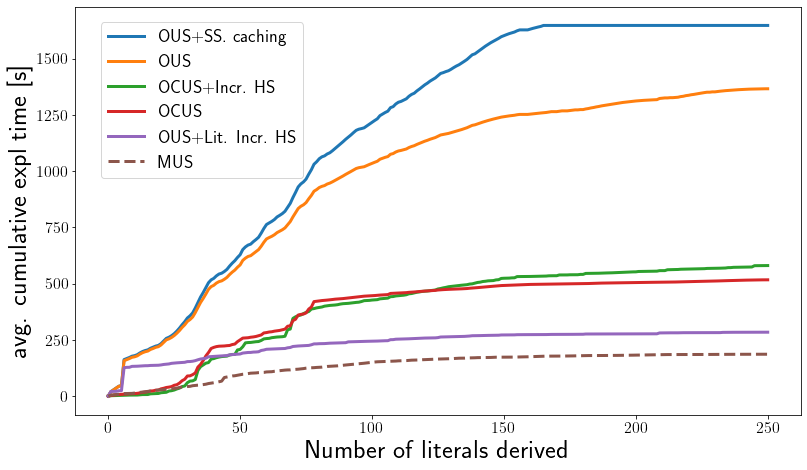

In [27]:
# init cumul average time per literal
from pathlib import Path
# dict with cumulative times
d_cumul_avg_time_incr = {config: {"x":None, "y": None} for config in set(df_rq34["params_explanation_computer"]) if config != "OUS_INCREMENTAL_SHARED"}

for config in set(df_rq34["params_explanation_computer"]):
    if config == "OUS_INCREMENTAL_SHARED":
        continue

    t_ordered = []
    # make it 1 graph
    for id, row in df_rq34[df_rq34["params_explanation_computer"]==config].iterrows():
        t_ordered+=row["average_lits_derived_time"]
    t_ordered.sort(key=lambda l: l[0])
    
    d_ordered = defaultdict(float)
    d_n_ordered = defaultdict(int)
    for step, ti in t_ordered:
        d_ordered[step] += ti
        d_n_ordered[step] += 1
        
    for step in d_ordered:
        d_ordered[step] /= d_n_ordered[step] 
    x=[]
    y=[]
    for step in sorted(d_ordered):
        x.append(step)
        y.append(d_ordered[step])

    d_cumul_avg_time_incr[config] = {"x": x, "y":y}
# display(df_rq34)

print(d_cumul_avg_time_incr.keys())
mapping = {"MUS": "MUS","OCUS": "OCUS","OCUS+I": "OCUS+Incr. HS","OUS": "OUS","OUS+I": "OUS+SS caching"}
paper_mapping = {
    'OCUS_NOT_INCREMENTAL':'OCUS', 
    'OUS_INCREMENTAL_NAIVE':'OUS+Lit. Incr. HS', 
    'OUS_SS':'OUS', 
    'OCUS':'OCUS+Incr. HS', 
    'MUS':'MUS', 
    'OUS_SS+I':'OUS+SS. caching', 
    #'OUS_INCREMENTAL_SHARED':'OUS+Incr.HS+SS. Sharing'
}
paper_ordering = ['OUS_SS+I','OUS_SS','OCUS','OCUS_NOT_INCREMENTAL','OUS_INCREMENTAL_NAIVE',
    'MUS']
ordering = ["OUS+I", "OUS", "OCUS+I", "OCUS","MUS"]

plot_derived_lits_avg_time(
    d_cumul_avg_time_incr, 
    figsize=(13,7.5), 
    ordering=paper_ordering, 
    figure_path=Path(PATH_FIGURES_POST_PAPER) / "cumul_incr_avg_time_lits_derived.pdf",
    mapping=paper_mapping,
    loc=(0.035, 0.58),
    with_line = False,
    next_to_graph=False
)

In [22]:
def rename_grow_config(row):
    grow_renaming = {
        "MAXSAT":"Max",
        'SAT':"no-grow", 
        'SUBSETMAX':"Greedy", 
        'ignore': "ignore",
        None: "ignore", 
    }
    
    base_name = "" +grow_renaming[row["params_grow"]]

    if row["params_grow"] in ["SAT"]:
        return base_name
    
    inteprretiaon_renaming = {
        "FINAL": "Iend",
        "ACTUAL": "Actual",
        "FULL": "Full",
        "ignore": ""
    }
    
    weighing_renaming = {
        "UNIFORM": "Unif",
        "POSITIVE": "Pos",
        "INVERSE": "Inv",
        "ignore":""
     }
    if row["params_interpretation"] not in ["","ignore"]:
        base_name +="-" + inteprretiaon_renaming[row["params_interpretation"]]
    if row["params_weighing"] not in ["","ignore"]: 
        base_name +="-" + weighing_renaming[row["params_weighing"]]
    
    return base_name


df2["params_grow_config"] = df2.apply(lambda row: rename_grow_config(row), axis=1)

df2_cous = df2[
    df2["params_grow"].isin(['SAT', 'MAXSAT', 'SUBSETMAX']) & 
    (df2["params_explanation_computer"] =="OCUS") &
    (df2["params_instance"].isin(['p12', 'p13', 'p18', 'pastaPuzzle', 'p25', 'p20', 'p93', 'p16', 'origin-problem', 'p19']))
][[ 'params_instance',
 'params_explanation_computer',
   'params_weighing',
   'params_grow',
   "params_grow_config",
   'params_interpretation',
 'lits_derived',
 'average_lits_derived_time',
 'cumul_explain_time']]

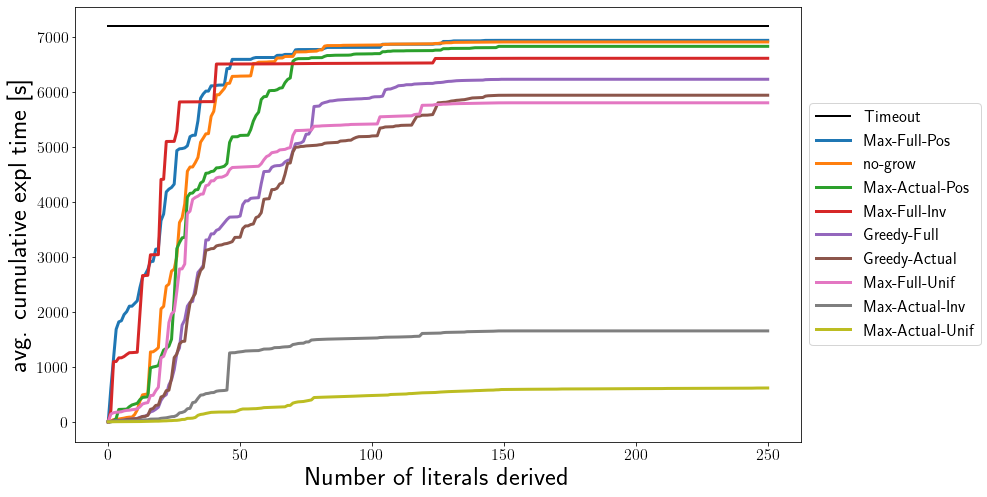

In [31]:
d_cumul_avg_time_grow_cous_incr = {}

for config in set(df2_cous["params_grow_config"]):
    t_ordered = []
    # make it 1 graph
    for id, row in df2_cous[df2_cous["params_grow_config"]==config].iterrows():
        t_ordered+=row["average_lits_derived_time"]
    t_ordered.sort(key=lambda l: l[0])
    
    d_ordered = defaultdict(float)
    d_n_ordered = defaultdict(int)

    for step, ti in t_ordered:
        d_ordered[step] += ti
        d_n_ordered[step] += 1
        
    
    for step in d_ordered:
        d_ordered[step] /= d_n_ordered[step] 
    
    x=[]
    y=[]
    for step in sorted(d_ordered):
        x.append(step)
        y.append(d_ordered[step])

    d_cumul_avg_time_grow_cous_incr[config] = {"x": x, "y":y}
    

grow_ordering = ['Max-Full-Pos','no-grow', 'Max-Actual-Pos','Max-Full-Inv', 'Greedy-Full', 'Greedy-Actual', 'Max-Full-Unif' , 'Max-Actual-Inv', 'Max-Actual-Unif'] 

plot_derived_lits_avg_time(
    d_cumul_avg_time_grow_cous_incr, 
    figsize=(13, 8), 
    ordering=grow_ordering, 
    figure_path=Path(PATH_FIGURES_POST_PAPER) / "new_cumul_grow_avg_time_lits_derived.pdf",
    #mapping=paper_mapping,
    loc=(0.71, 0.32),
    next_to_graph=True,
     with_line = True,
)

In [ ]:

df_explanation_times = df_paper[
    (df_paper["params_grow"] == "MAXSAT") & 
    (df_paper["params_weighing"] == "UNIFORM") &
    (df_paper["params_interpretation"] == "ACTUAL") & 
    (df_paper["params_explanation_computer"] == "OCUS")
][["time_explain"]]

explanation_times = []
for id, row in df_explanation_times.iterrows():
    explanation_times += row["time_explain"]

fig, ax = plt.subplots(figsize=(10, 6))

counts, bins, patches = ax.hist(explanation_times, bins=[0, 1, 2, 5, 10, 20, 50, 100, 200, 500], color='red', edgecolor='black')
y = [int(c) for c in list(counts)]
x = [int(c) for c in list(bins)]

header = [f"\\textbf{{{str(x[i-1])}-{str(x[i])}}}"for i in range(1, len(x)) ]
footer = [f"{str(y[i])}" for i in range(len(y))]
print("\\begin{tabular}{" +  "c|"*(len(x)-1)+ "c}")
print("Time [s] &" + " & ". join(header) + "\\\\")
print("\\midrule")
print("$\# expl$ &" + " & ". join(footer) + "\\\\")
print("\\end{tabular}")